# Enhanced Reddit Sentiment Analysis - Experiment 3: Class Balancing and Advanced Techniques

This notebook addresses class imbalance using combined over/under sampling techniques,
introduces new vectorization methods and models, and provides comprehensive evaluation.

## Table of Contents
1. Setup and Enhanced Dependencies
2. Data Loading and Class Imbalance Analysis
3. Class Balancing Techniques Implementation
4. Enhanced Vectorization Methods
5. Multiple Model Implementation
6. Comprehensive Evaluation Framework
7. MLflow Experiment Tracking

In [1]:
pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.6/680.6 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 19.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           precision_recall_fscore_support, f1_score, roc_auc_score,
                           roc_curve, precision_recall_curve, matthews_corrcoef,
                           balanced_accuracy_score, cohen_kappa_score)

# Imbalanced learning imports
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# MLflow imports
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

# Additional visualization
from sklearn.manifold import TSNE
from wordcloud import WordCloud

In [3]:
# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [17]:
from mlflow.tracking import MlflowClient

client = MlflowClient(tracking_uri="file:///content/drive/MyDrive/mlflow_logs")
experiments = client.search_experiments()

for exp in experiments:
    print(f"Name: {exp.name} | ID: {exp.experiment_id} | Artifact Location: {exp.artifact_location}")

Name: Reddit_Sentiment_Baseline | ID: 300921718200322684 | Artifact Location: file:///content/drive/MyDrive/mlflow_logs/300921718200322684
Name: BoW_vs_TfIdf_Comparison | ID: 147337520425050598 | Artifact Location: file:///content/drive/MyDrive/mlflow_logs/147337520425050598
Name: Default | ID: 0 | Artifact Location: file:///content/drive/MyDrive/mlflow_logs/0


In [18]:
 """## 1. Utility Functions"""

def analyze_class_distribution(y, title="Class Distribution", labels=None):
    """Analyze and visualize class distribution with detailed statistics."""
    if labels is None:
        labels = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}

    # Calculate distribution
    class_counts = pd.Series(y).value_counts().sort_index()
    total_samples = len(y)

    print(f"\n{title}:")
    print("-" * 50)
    for class_val, count in class_counts.items():
        label = labels.get(class_val, f'Class {class_val}')
        percentage = (count / total_samples) * 100
        print(f"  {label}: {count:,} ({percentage:.2f}%)")

    print(f"  Total: {total_samples:,}")

    # Calculate imbalance ratio
    max_class = class_counts.max()
    min_class = class_counts.min()
    imbalance_ratio = max_class / min_class
    print(f"  Imbalance Ratio: {imbalance_ratio:.2f}:1")

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar plot
    class_names = [labels.get(cls, f'Class {cls}') for cls in class_counts.index]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    bars = ax1.bar(class_names, class_counts.values, color=colors)
    ax1.set_title(f'{title} - Counts', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=45)

    # Add count labels on bars
    for bar, count in zip(bars, class_counts.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(class_counts)*0.01,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')

    # Pie chart
    ax2.pie(class_counts.values, labels=class_names, autopct='%1.1f%%',
            colors=colors, startangle=90)
    ax2.set_title(f'{title} - Proportions', fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.show()

    return class_counts, imbalance_ratio

def apply_class_balancing(X, y, method='smoteenn', random_state=42):
    """Apply various class balancing techniques."""
    print(f"\nApplying class balancing method: {method.upper()}")

    # Define balancing strategies
    strategies = {
        'smote': SMOTE(random_state=random_state),
        'adasyn': ADASYN(random_state=random_state),
        'random_over': RandomOverSampler(random_state=random_state),
        'random_under': RandomUnderSampler(random_state=random_state),
        'smoteenn': SMOTEENN(random_state=random_state),
        'smotetomek': SMOTETomek(random_state=random_state),
        'tomek': TomekLinks(),
        'enn': EditedNearestNeighbours()
    }

    if method not in strategies:
        raise ValueError(f"Method {method} not supported. Available: {list(strategies.keys())}")

    balancer = strategies[method]

    # For text data, we need to vectorize first for resampling
    temp_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X_temp = temp_vectorizer.fit_transform(X)

    # Convert sparse to dense
    X_temp = X_temp.toarray()

    # Apply balancing
    X_balanced, y_balanced = balancer.fit_resample(X_temp, y)

    # Approximate mapping to original text
    if hasattr(balancer, 'sample_indices_'):
        indices = balancer.sample_indices_
    else:
        indices = range(len(X_balanced))

    original_indices = []
    synthetic_count = 0

    for i in range(len(X_balanced)):
        if i < len(X):
            original_indices.append(i)
        else:
            original_indices.append(i % len(X))
            synthetic_count += 1

    X_text_balanced = [X.iloc[idx] if idx < len(X) else X.iloc[idx % len(X)] for idx in original_indices]

    print(f"  Original samples: {len(X):,}")
    print(f"  Balanced samples: {len(X_text_balanced):,}")
    print(f"  Synthetic samples (approx): {synthetic_count:,}")

    return pd.Series(X_text_balanced), pd.Series(y_balanced)


def create_enhanced_vectorizers():
    """Create dictionary of various vectorization techniques."""
    vectorizers = {
        'bow_unigram': CountVectorizer(
            ngram_range=(1, 1), max_features=10000, min_df=2, max_df=0.8, stop_words='english'
        ),
        'bow_bigram': CountVectorizer(
            ngram_range=(1, 2), max_features=15000, min_df=2, max_df=0.8, stop_words='english'
        ),
        'tfidf_unigram': TfidfVectorizer(
            ngram_range=(1, 1), max_features=10000, min_df=2, max_df=0.8, stop_words='english'
        ),
        'tfidf_bigram': TfidfVectorizer(
            ngram_range=(1, 2), max_features=15000, min_df=2, max_df=0.8, stop_words='english'
        ),
        'tfidf_trigram': TfidfVectorizer(
            ngram_range=(1, 3), max_features=20000, min_df=2, max_df=0.8, stop_words='english'
        ),
        'hashing': HashingVectorizer(
            n_features=10000, ngram_range=(1, 2), stop_words='english'
        )
    }
    return vectorizers

def create_enhanced_models():
    """Create dictionary of various machine learning models."""
    models = {
        'random_forest': RandomForestClassifier(
            n_estimators=200, max_depth=15, random_state=42, n_jobs=-1,
            class_weight='balanced'
        ),
        'gradient_boosting': GradientBoostingClassifier(
            n_estimators=100, max_depth=10, random_state=42
        ),
        'logistic_regression': LogisticRegression(
            random_state=42, max_iter=1000, class_weight='balanced'
        ),
        'naive_bayes': MultinomialNB(alpha=1.0),
        'ensemble_voting': VotingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')),
                ('lr', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')),
                ('nb', MultinomialNB(alpha=1.0))
            ],
            voting='soft'
        )
    }
    return models

def comprehensive_evaluation(model, X_test, y_test, y_pred=None, y_pred_proba=None):
    """Perform comprehensive model evaluation with all possible metrics."""

    if y_pred is None:
        y_pred = model.predict(X_test)
    if y_pred_proba is None and hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)

    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # F1 scores
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_micro = f1_score(y_test, y_pred, average='micro')

    # Precision and Recall
    precision_macro = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
    recall_macro = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
    precision_weighted = precision_recall_fscore_support(y_test, y_pred, average='weighted')[0]
    recall_weighted = precision_recall_fscore_support(y_test, y_pred, average='weighted')[1]

    # Additional metrics
    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    # ROC AUC (for multiclass)
    roc_auc = None
    if y_pred_proba is not None and len(np.unique(y_test)) > 2:
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    elif y_pred_proba is not None and len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

    # Per-class metrics
    class_report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_micro': f1_micro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'matthews_corrcoef': mcc,
        'cohen_kappa': kappa,
        'roc_auc_macro': roc_auc,
        'classification_report': class_report,
        'confusion_matrix': conf_matrix,
        'predictions': y_pred,
        'prediction_probabilities': y_pred_proba
    }

def create_comprehensive_visualizations(results, class_names=['Negative', 'Neutral', 'Positive']):
    """Create comprehensive visualizations for model evaluation."""

    # 1. Confusion Matrix
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Comprehensive Model Evaluation', fontsize=16, fontweight='bold')

    # Confusion Matrix
    conf_matrix = results['confusion_matrix']
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix (Counts)', fontweight='bold')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')

    # Normalized Confusion Matrix
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[0,1])
    axes[0,1].set_title('Confusion Matrix (Normalized)', fontweight='bold')
    axes[0,1].set_xlabel('Predicted')
    axes[0,1].set_ylabel('Actual')

    # Metrics comparison
    metrics_data = {
        'Accuracy': results['accuracy'],
        'Balanced Accuracy': results['balanced_accuracy'],
        'F1 Macro': results['f1_macro'],
        'F1 Weighted': results['f1_weighted'],
        'Precision Macro': results['precision_macro'],
        'Recall Macro': results['recall_macro'],
        'Matthews Corr.': results['matthews_corrcoef'],
        'Cohen Kappa': results['cohen_kappa']
    }

    metric_names = list(metrics_data.keys())
    metric_values = list(metrics_data.values())

    bars = axes[1,0].bar(metric_names, metric_values, color='skyblue', alpha=0.7)
    axes[1,0].set_title('Performance Metrics', fontweight='bold')
    axes[1,0].set_ylabel('Score')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].set_ylim(0, 1)

    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        if value is not None:
            axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                          f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Per-class metrics
    class_report = results['classification_report']
    class_metrics = []
    for class_idx, class_name in enumerate(class_names):
        if str(class_idx-1) in class_report:  # Adjust for class labels
            metrics = class_report[str(class_idx-1)]
            class_metrics.append([metrics['precision'], metrics['recall'], metrics['f1-score']])
        elif class_name.lower() in class_report:
            metrics = class_report[class_name.lower()]
            class_metrics.append([metrics['precision'], metrics['recall'], metrics['f1-score']])

    if class_metrics:
        class_metrics = np.array(class_metrics)
        x = np.arange(len(class_names))
        width = 0.25

        axes[1,1].bar(x - width, class_metrics[:, 0], width, label='Precision', alpha=0.8)
        axes[1,1].bar(x, class_metrics[:, 1], width, label='Recall', alpha=0.8)
        axes[1,1].bar(x + width, class_metrics[:, 2], width, label='F1-Score', alpha=0.8)

        axes[1,1].set_title('Per-Class Metrics', fontweight='bold')
        axes[1,1].set_ylabel('Score')
        axes[1,1].set_xlabel('Classes')
        axes[1,1].set_xticks(x)
        axes[1,1].set_xticklabels(class_names)
        axes[1,1].legend()
        axes[1,1].set_ylim(0, 1)

    plt.tight_layout()
    return fig

def plot_class_balance_comparison(original_y, balanced_y, method_name):
    """Plot before and after class balancing."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    class_labels = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}

    # Original distribution
    original_counts = pd.Series(original_y).value_counts().sort_index()
    original_names = [class_labels[cls] for cls in original_counts.index]

    ax1.bar(original_names, original_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.7)
    ax1.set_title('Original Class Distribution', fontweight='bold')
    ax1.set_ylabel('Number of Samples')

    for i, v in enumerate(original_counts.values):
        ax1.text(i, v + max(original_counts)*0.01, f'{v:,}', ha='center', va='bottom', fontweight='bold')

    # Balanced distribution
    balanced_counts = pd.Series(balanced_y).value_counts().sort_index()
    balanced_names = [class_labels[cls] for cls in balanced_counts.index]

    ax2.bar(balanced_names, balanced_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.7)
    ax2.set_title(f'After {method_name.upper()} Balancing', fontweight='bold')
    ax2.set_ylabel('Number of Samples')

    for i, v in enumerate(balanced_counts.values):
        ax2.text(i, v + max(balanced_counts)*0.01, f'{v:,}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    return fig

## 2. Data Loading and Analysis

In [19]:
# Load data
reddit_df = pd.read_pickle("/content/reddit_processed.pkl")
reddit_df['clean_comment'] = reddit_df['processed_comment']
reddit_df.drop(columns=['processed_comment'], inplace=True)

print(f"\nDataset Overview:")
print(f"Shape: {reddit_df.shape}")
print(f"Columns: {list(reddit_df.columns)}")

# Ensure correct data types
reddit_df['category'] = reddit_df['category'].astype(int)


Dataset Overview:
Shape: (36662, 2)
Columns: ['clean_comment', 'category']



Original Class Distribution:
--------------------------------------------------
  Negative: 8,248 (22.50%)
  Neutral: 12,644 (34.49%)
  Positive: 15,770 (43.01%)
  Total: 36,662
  Imbalance Ratio: 1.91:1


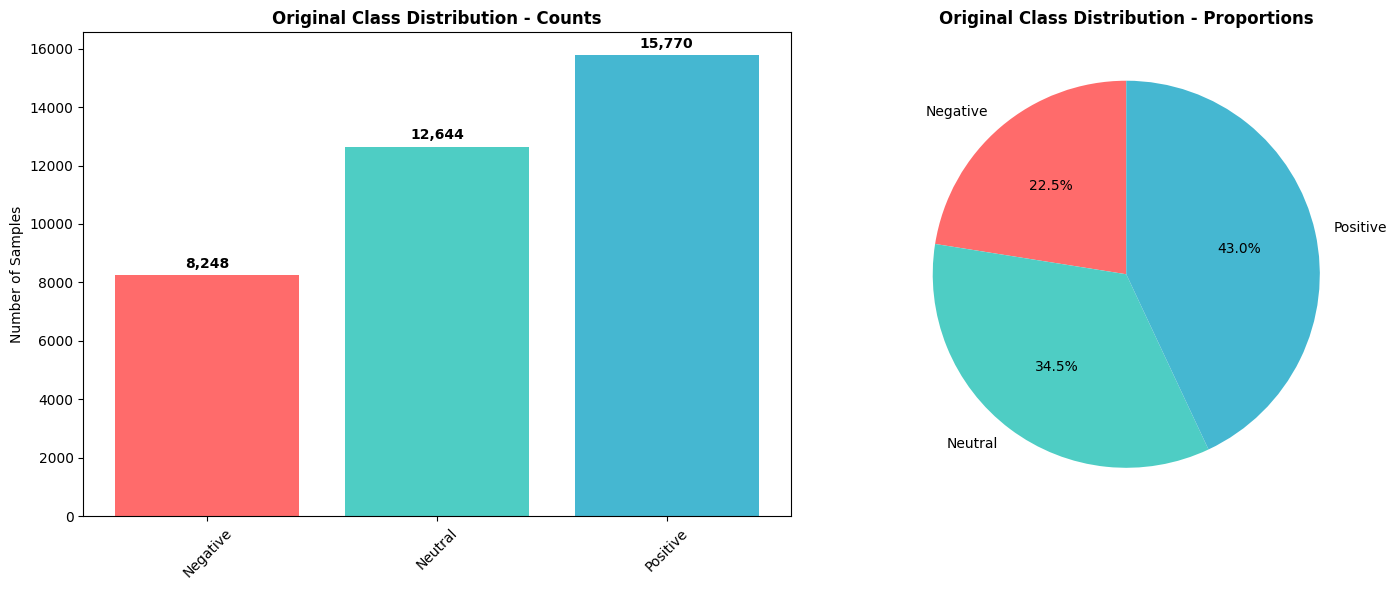

In [21]:
# Analyze original class distribution
original_counts, original_imbalance = analyze_class_distribution(
    reddit_df['category'],
    title="Original Class Distribution"
)

## 3. Class Balancing Experiments


Testing SMOTEENN Balancing

Applying class balancing method: SMOTEENN
  Original samples: 36,662
  Balanced samples: 18,244
  Synthetic samples (approx): 0

After SMOTEENN Balancing:
--------------------------------------------------
  Negative: 10,343 (56.69%)
  Neutral: 6,268 (34.36%)
  Positive: 1,633 (8.95%)
  Total: 18,244
  Imbalance Ratio: 6.33:1


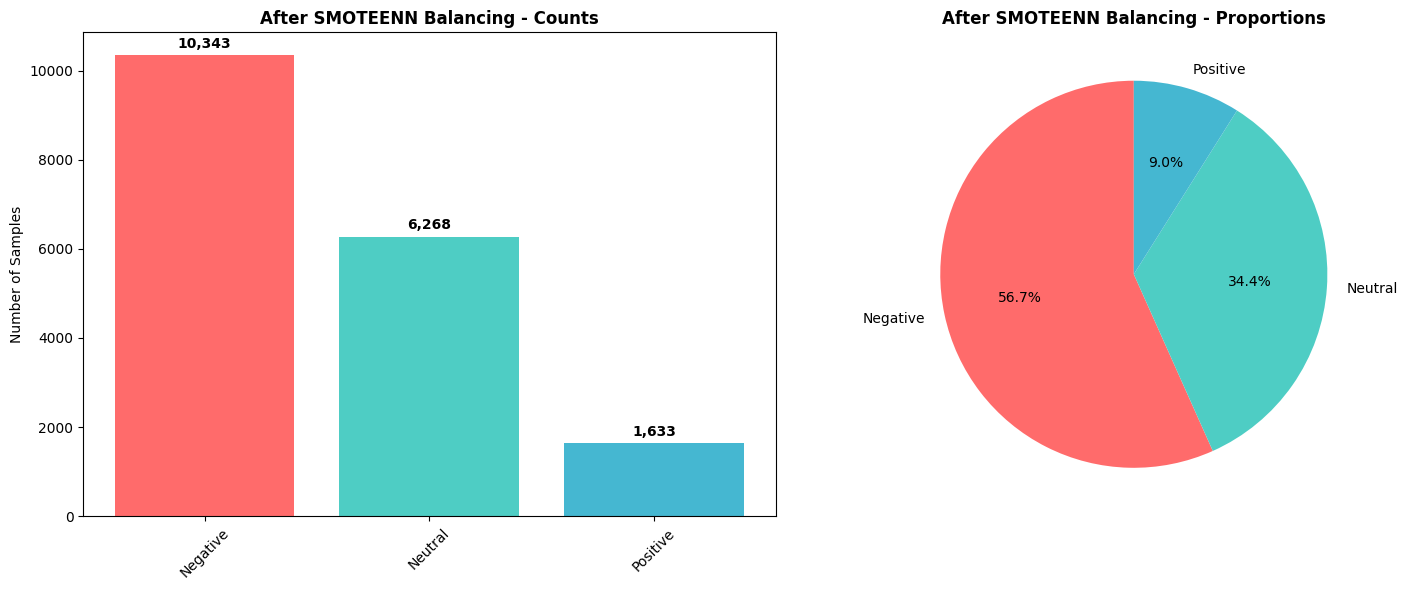

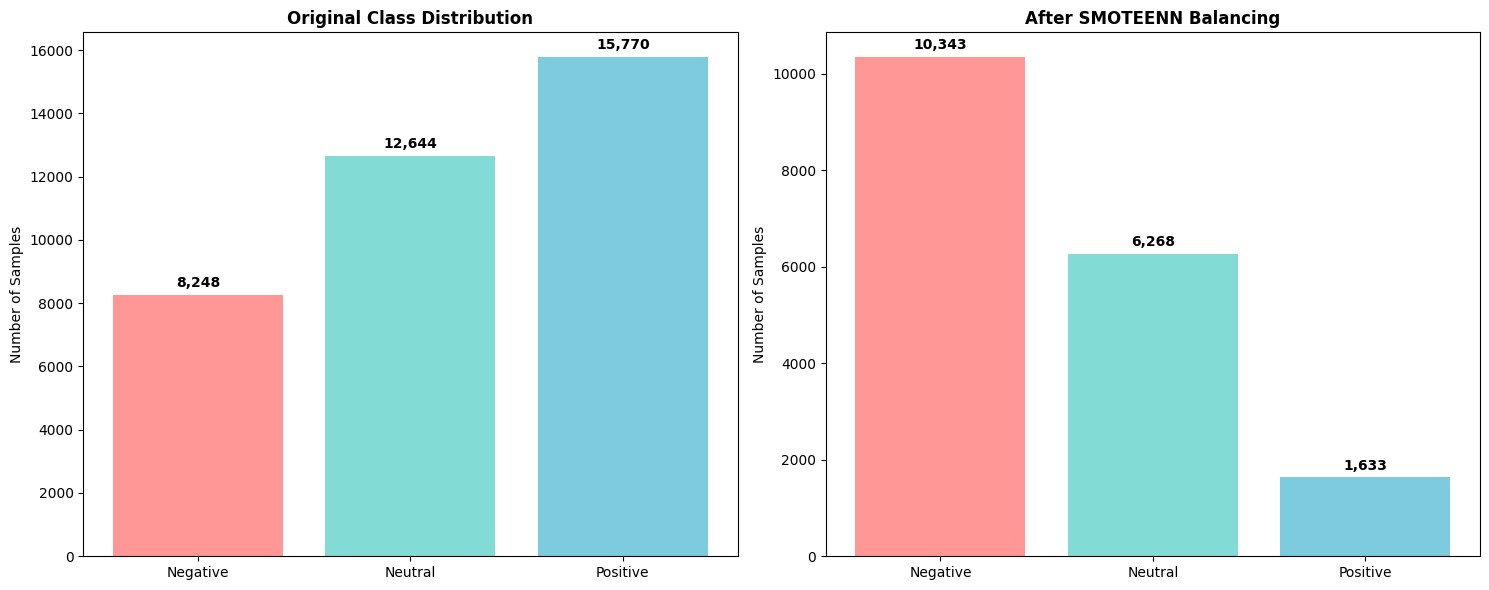

Imbalance ratio improved from 1.91:1 to 6.33:1

Testing SMOTETOMEK Balancing

Applying class balancing method: SMOTETOMEK
  Original samples: 36,662
  Balanced samples: 46,742
  Synthetic samples (approx): 10,080

After SMOTETOMEK Balancing:
--------------------------------------------------
  Negative: 15,667 (33.52%)
  Neutral: 15,528 (33.22%)
  Positive: 15,547 (33.26%)
  Total: 46,742
  Imbalance Ratio: 1.01:1


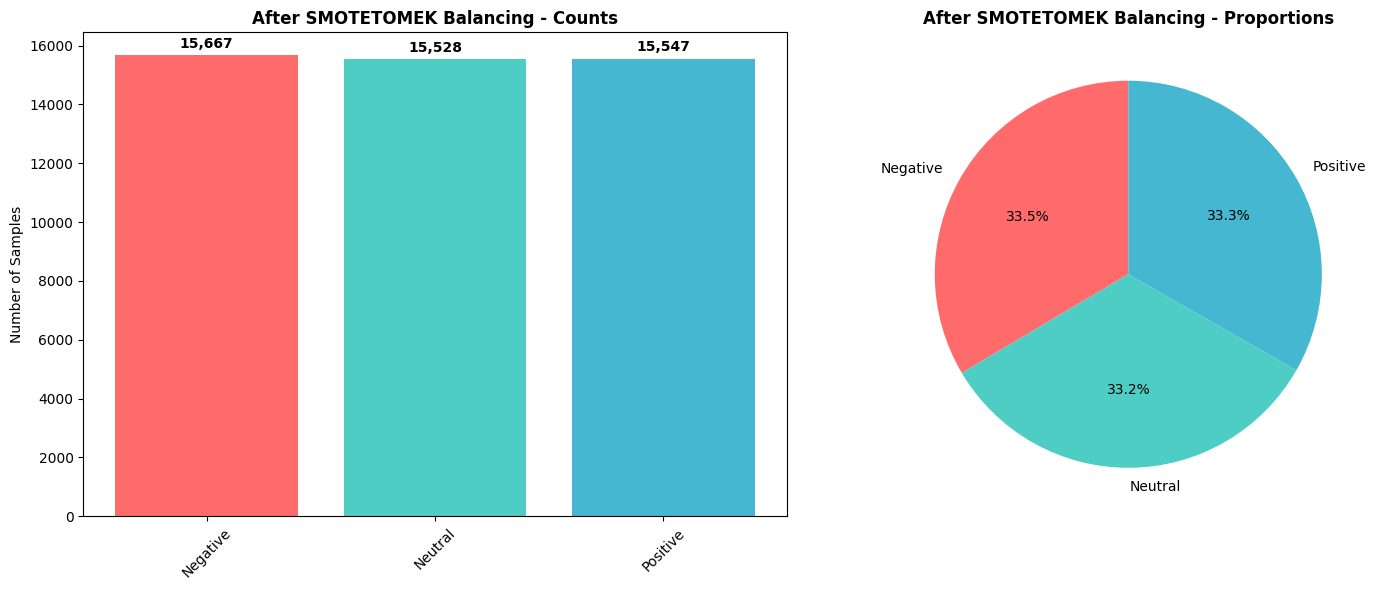

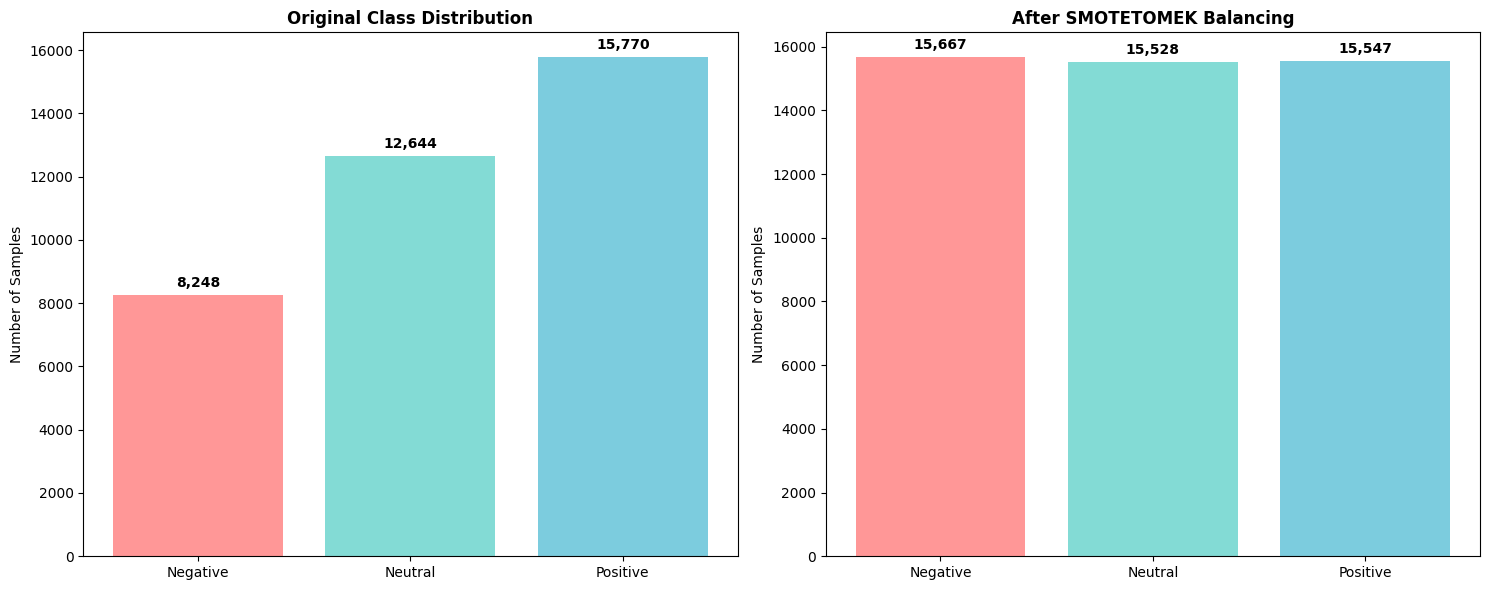

Imbalance ratio improved from 1.91:1 to 1.01:1

Testing SMOTE Balancing

Applying class balancing method: SMOTE
  Original samples: 36,662
  Balanced samples: 47,310
  Synthetic samples (approx): 10,648

After SMOTE Balancing:
--------------------------------------------------
  Negative: 15,770 (33.33%)
  Neutral: 15,770 (33.33%)
  Positive: 15,770 (33.33%)
  Total: 47,310
  Imbalance Ratio: 1.00:1


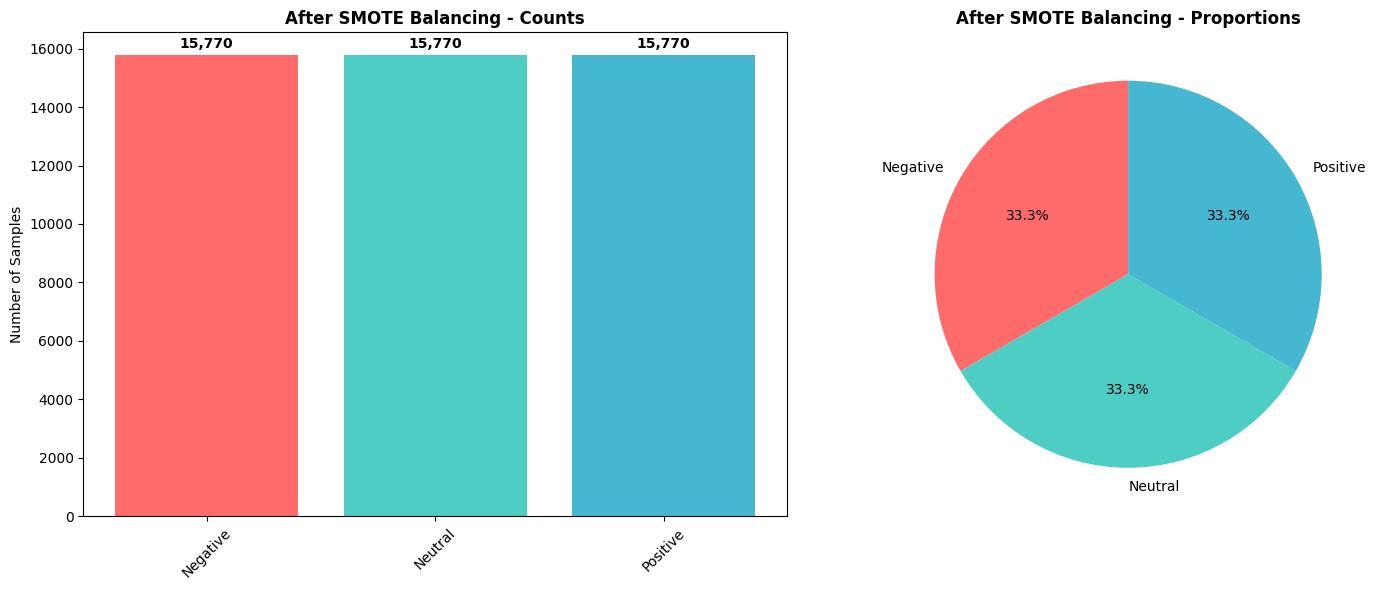

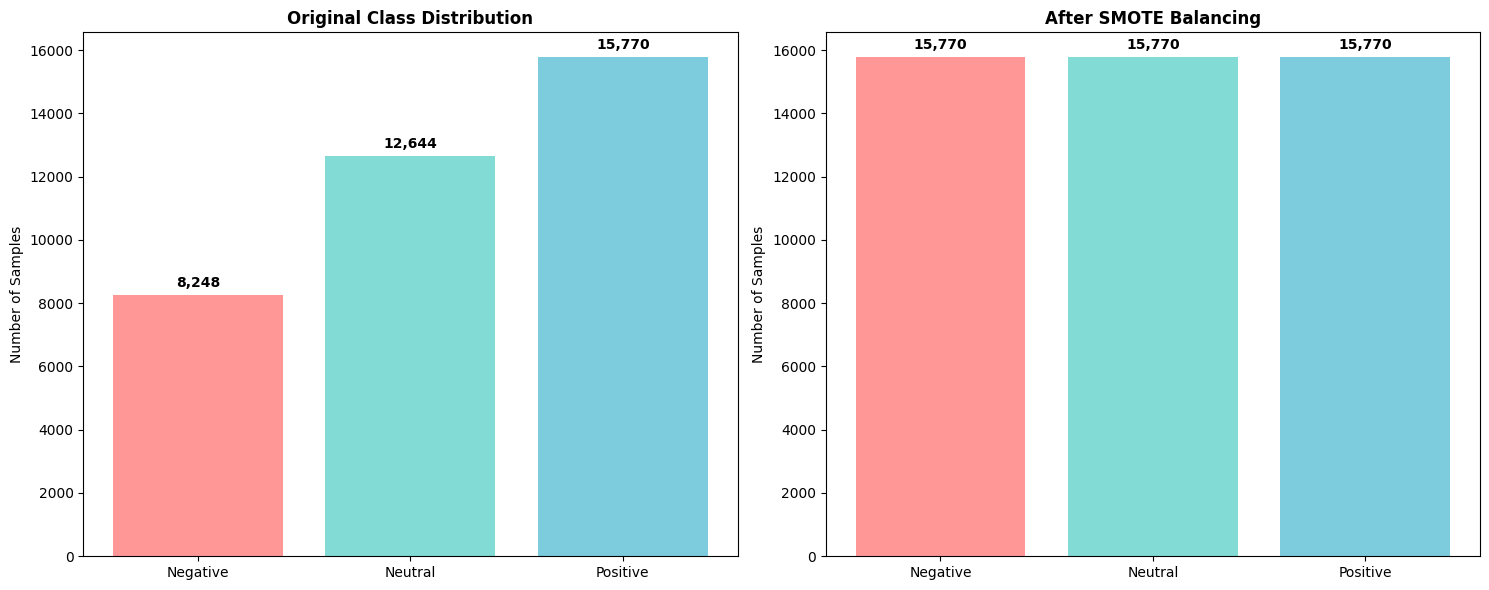

Imbalance ratio improved from 1.91:1 to 1.00:1

Testing ADASYN Balancing

Applying class balancing method: ADASYN
  Original samples: 36,662
  Balanced samples: 44,843
  Synthetic samples (approx): 8,181

After ADASYN Balancing:
--------------------------------------------------
  Negative: 15,190 (33.87%)
  Neutral: 13,883 (30.96%)
  Positive: 15,770 (35.17%)
  Total: 44,843
  Imbalance Ratio: 1.14:1


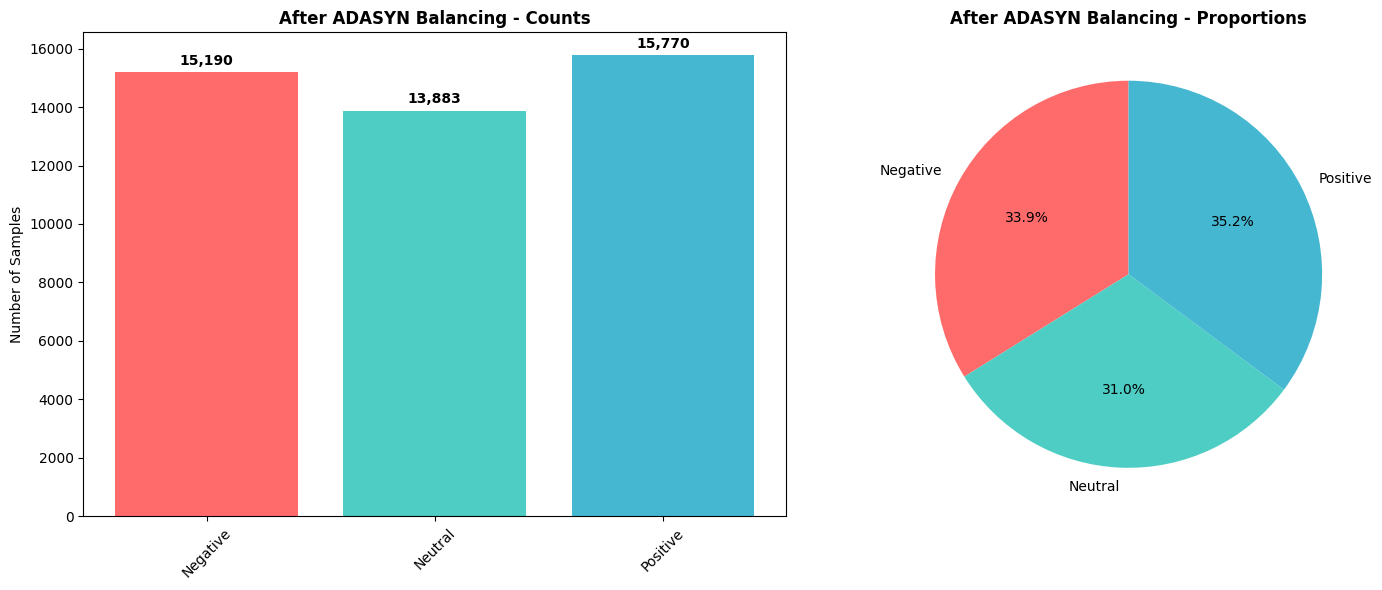

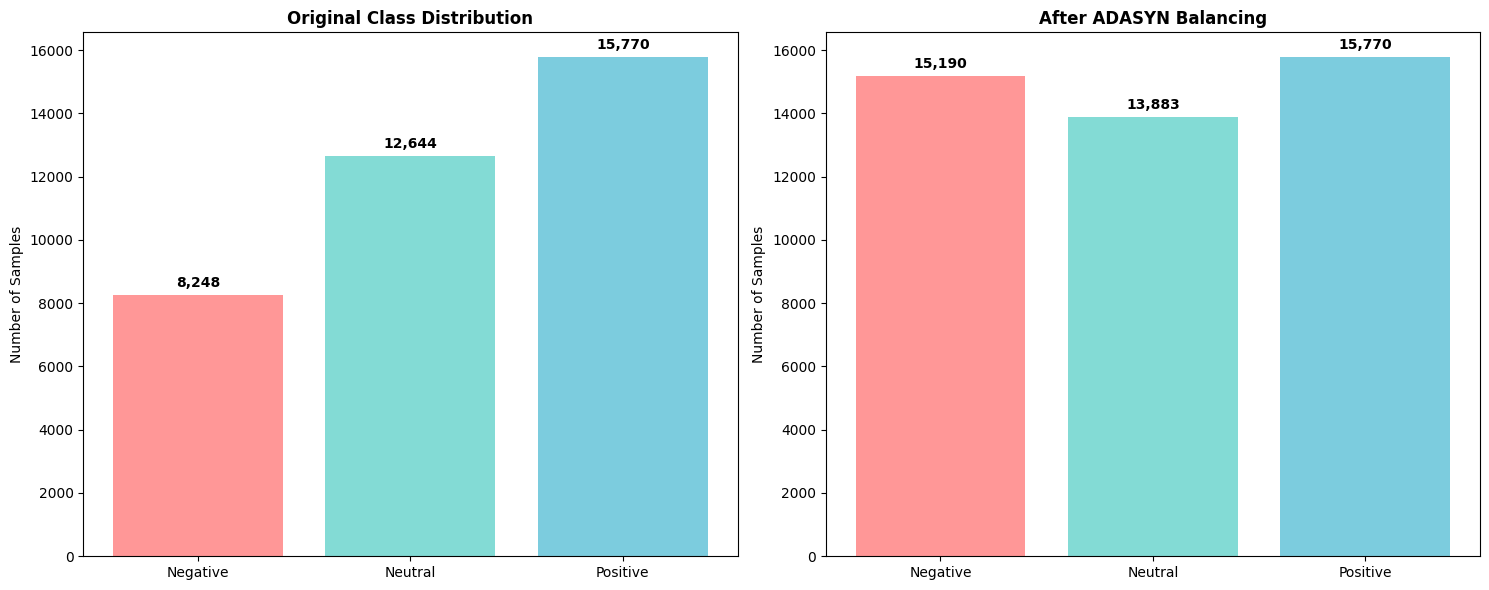

Imbalance ratio improved from 1.91:1 to 1.14:1


In [22]:
# Test different balancing strategies
balancing_methods = ['smoteenn', 'smotetomek', 'smote', 'adasyn']
balanced_datasets = {}

for method in balancing_methods:
    print(f"\n{'='*40}")
    print(f"Testing {method.upper()} Balancing")
    print(f"{'='*40}")

    try:
        X_balanced, y_balanced = apply_class_balancing(
            reddit_df['clean_comment'],
            reddit_df['category'],
            method=method
        )

        balanced_datasets[method] = (X_balanced, y_balanced)

        # Analyze balanced distribution
        balanced_counts, balanced_imbalance = analyze_class_distribution(
            y_balanced,
            title=f"After {method.upper()} Balancing"
        )

        # Create comparison plot
        comparison_fig = plot_class_balance_comparison(
            reddit_df['category'], y_balanced, method
        )
        comparison_fig.savefig(f"class_balance_comparison_{method}.png", dpi=300, bbox_inches='tight')
        plt.show()

        print(f"Imbalance ratio improved from {original_imbalance:.2f}:1 to {balanced_imbalance:.2f}:1")

    except Exception as e:
        print(f"Error with {method}: {e}")
        continue

In [23]:
selected_method = 'smote'
if selected_method in balanced_datasets:
    X_balanced, y_balanced = balanced_datasets[selected_method]
    print(f"\n✓ Selected balancing method: {selected_method.upper()}")
else:
    X_balanced, y_balanced = reddit_df['clean_comment'], reddit_df['category']
    print(f"\n⚠ Using original unbalanced data")


✓ Selected balancing method: SMOTE


## 4. Enhanced Experiment Framework

In [24]:
# Setup MLflow experiment
mlflow.set_tracking_uri("file:///content/drive/MyDrive/mlflow_logs")
experiment_name = "Enhanced_Sentiment_Analysis_with_Balancing"
mlflow.set_experiment(experiment_name)
print(f"✓ MLflow experiment set: {experiment_name}")

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced
)

print(f"\nData Split:")
print(f"  Training samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")

# Get vectorizers and models
vectorizers = create_enhanced_vectorizers()
models = create_enhanced_models()

print(f"\nVectorization Methods: {list(vectorizers.keys())}")
print(f"Model Types: {list(models.keys())}")

total_experiments = len(vectorizers) * len(models)
print(f"\nTotal Experiments: {total_experiments}")

2025/07/31 18:38:10 INFO mlflow.tracking.fluent: Experiment with name 'Enhanced_Sentiment_Analysis_with_Balancing' does not exist. Creating a new experiment.


✓ MLflow experiment set: Enhanced_Sentiment_Analysis_with_Balancing

Data Split:
  Training samples: 37,848
  Test samples: 9,462

Vectorization Methods: ['bow_unigram', 'bow_bigram', 'tfidf_unigram', 'tfidf_bigram', 'tfidf_trigram', 'hashing']
Model Types: ['random_forest', 'gradient_boosting', 'logistic_regression', 'naive_bayes', 'ensemble_voting']

Total Experiments: 30


## 5. Experiment Execution


EXPERIMENT 1/30
Vectorizer: bow_unigram | Model: random_forest
Vectorizing text...
  Feature matrix shape: (37848, 10000)
Training model...
Evaluating model...


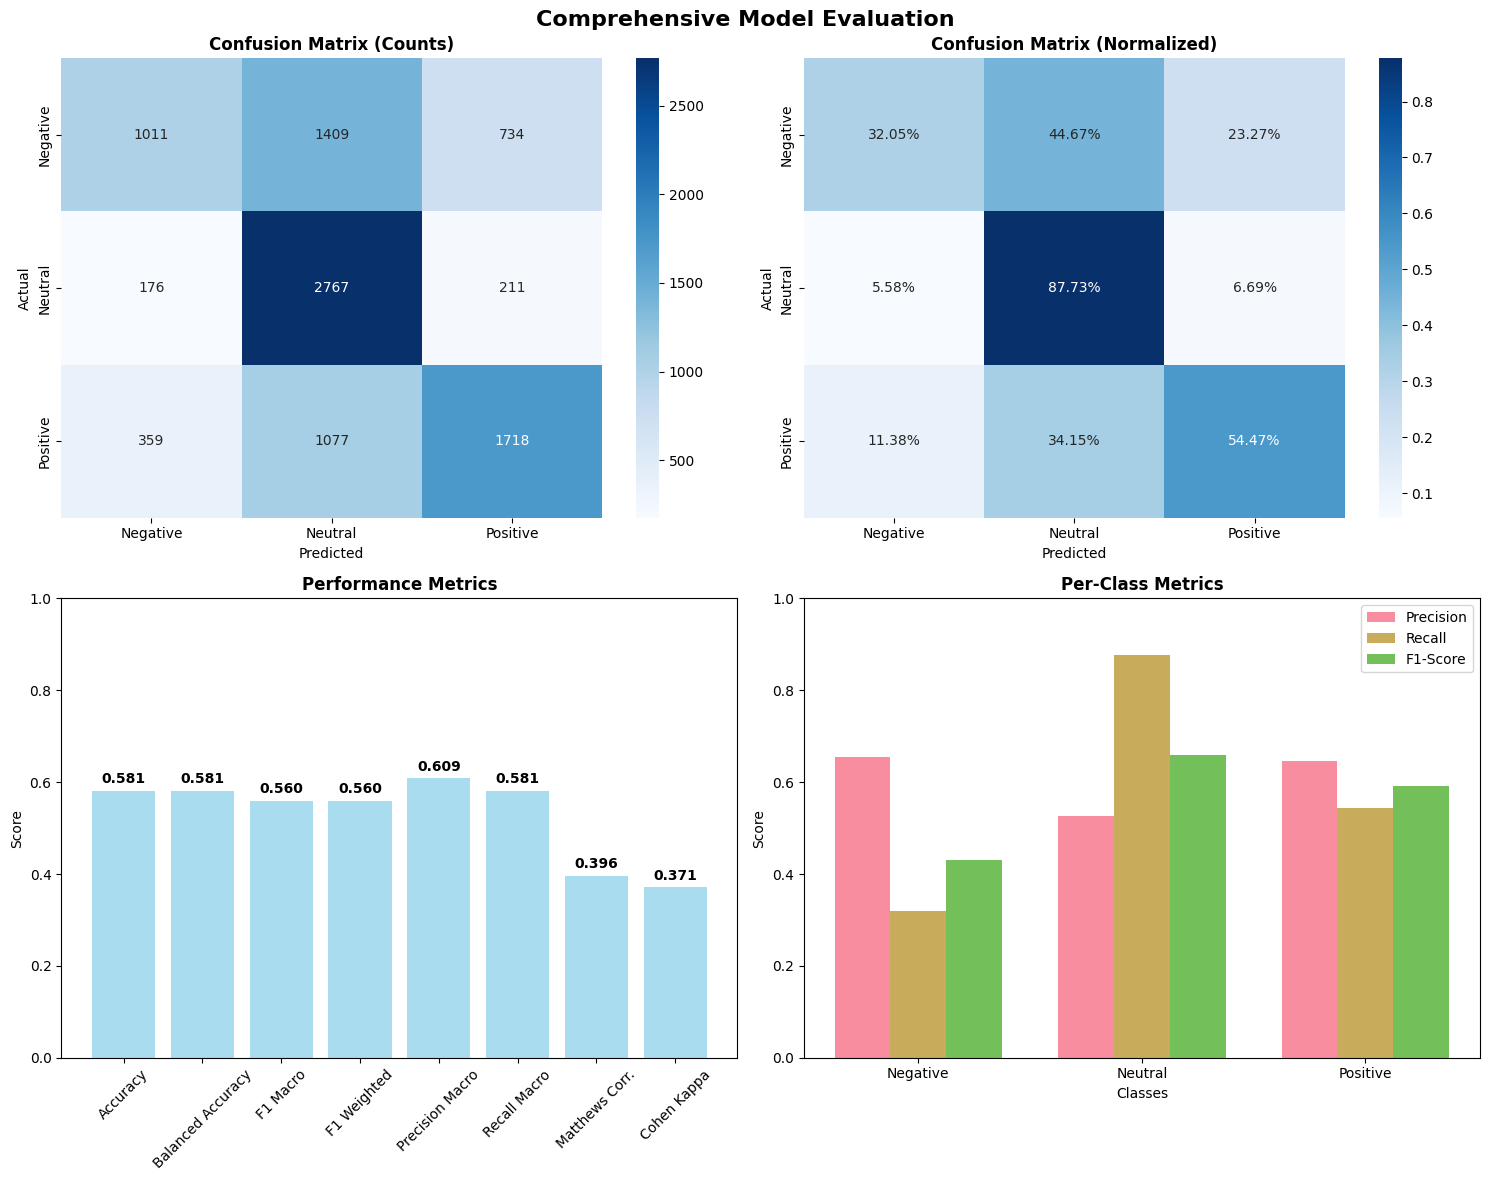

✓ Experiment completed successfully
  Accuracy: 0.5808
  Balanced Accuracy: 0.5808
  F1-Score (Macro): 0.5597

EXPERIMENT 2/30
Vectorizer: bow_unigram | Model: gradient_boosting
Vectorizing text...
  Feature matrix shape: (37848, 10000)
Training model...
Evaluating model...


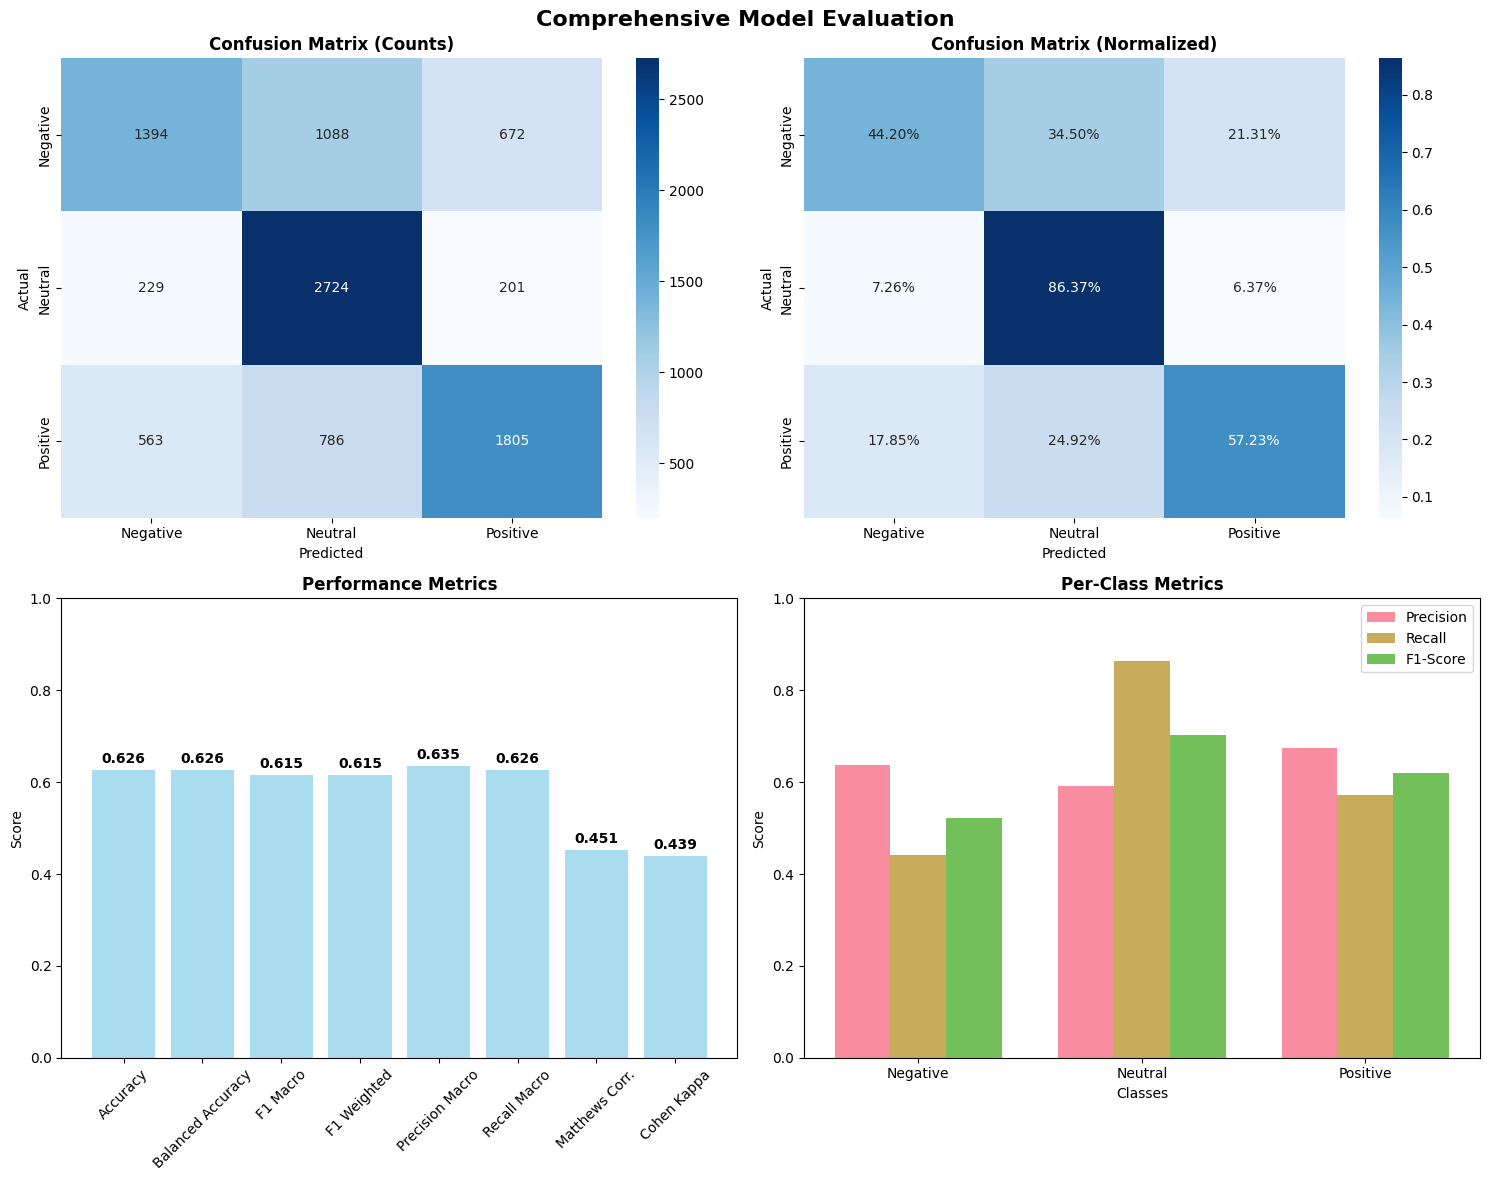

✓ Experiment completed successfully
  Accuracy: 0.6260
  Balanced Accuracy: 0.6260
  F1-Score (Macro): 0.6146

EXPERIMENT 3/30
Vectorizer: bow_unigram | Model: logistic_regression
Vectorizing text...
  Feature matrix shape: (37848, 10000)
Training model...
Evaluating model...


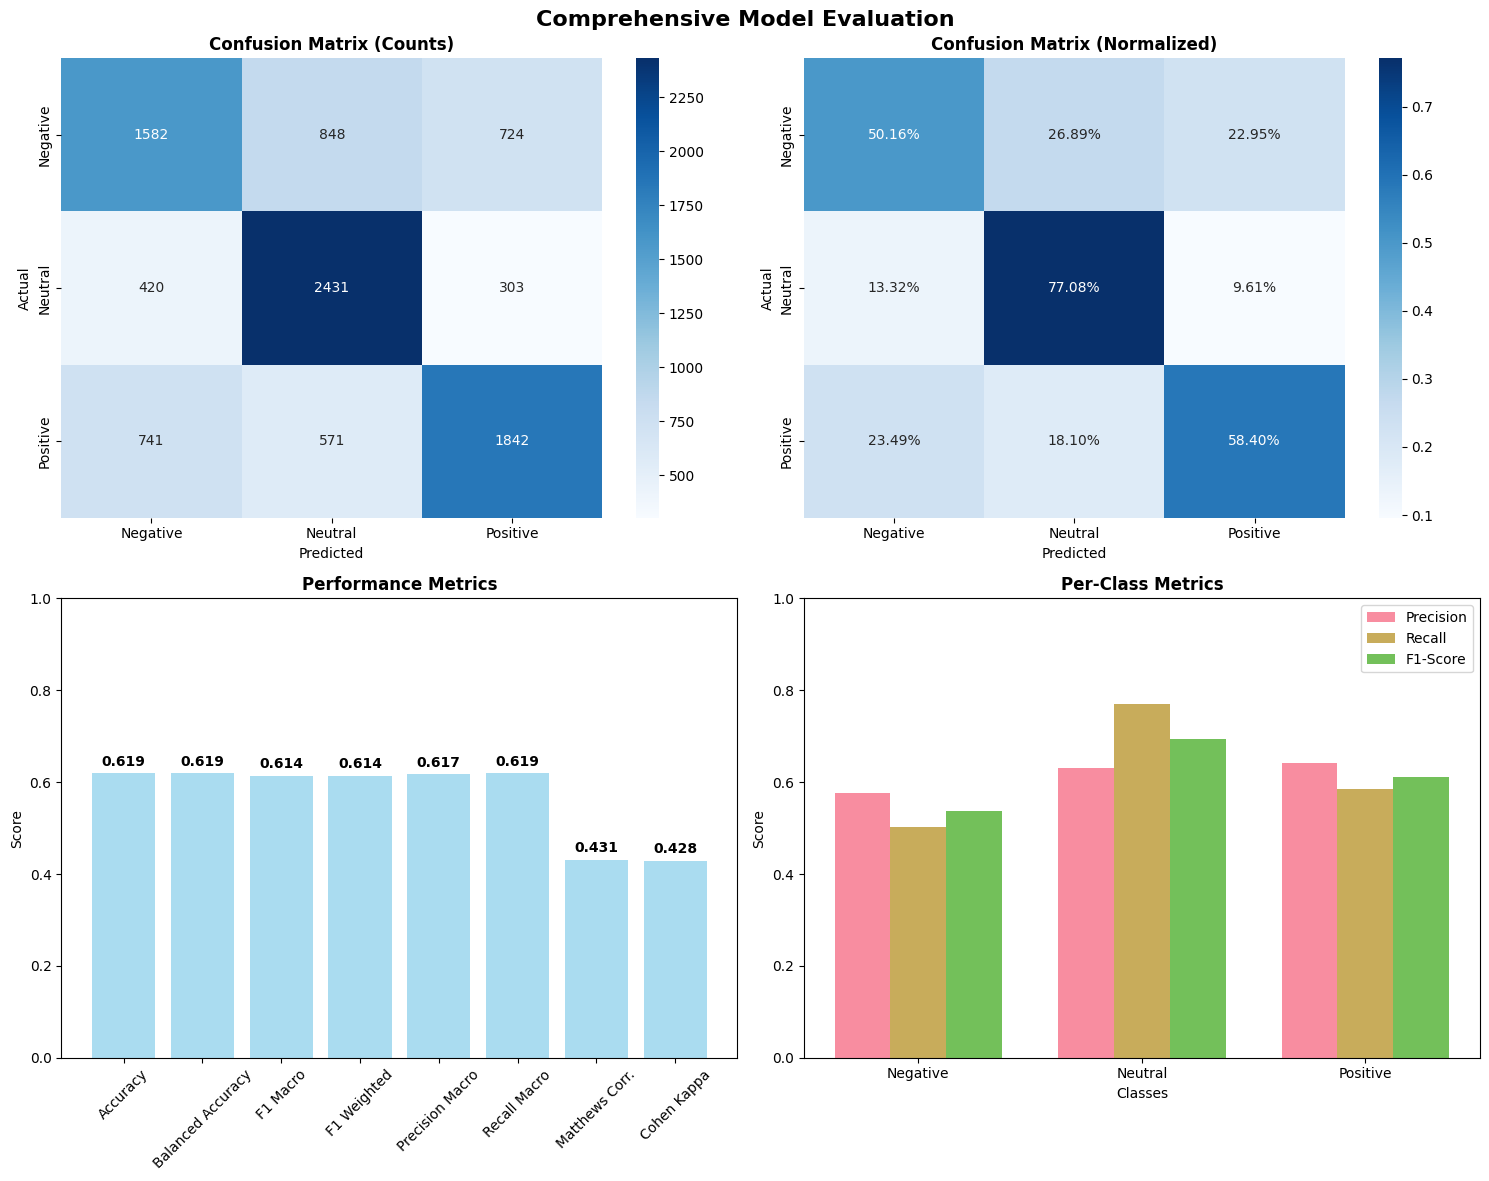

✓ Experiment completed successfully
  Accuracy: 0.6188
  Balanced Accuracy: 0.6188
  F1-Score (Macro): 0.6141

EXPERIMENT 4/30
Vectorizer: bow_unigram | Model: naive_bayes
Vectorizing text...
  Feature matrix shape: (37848, 10000)
Training model...
Evaluating model...


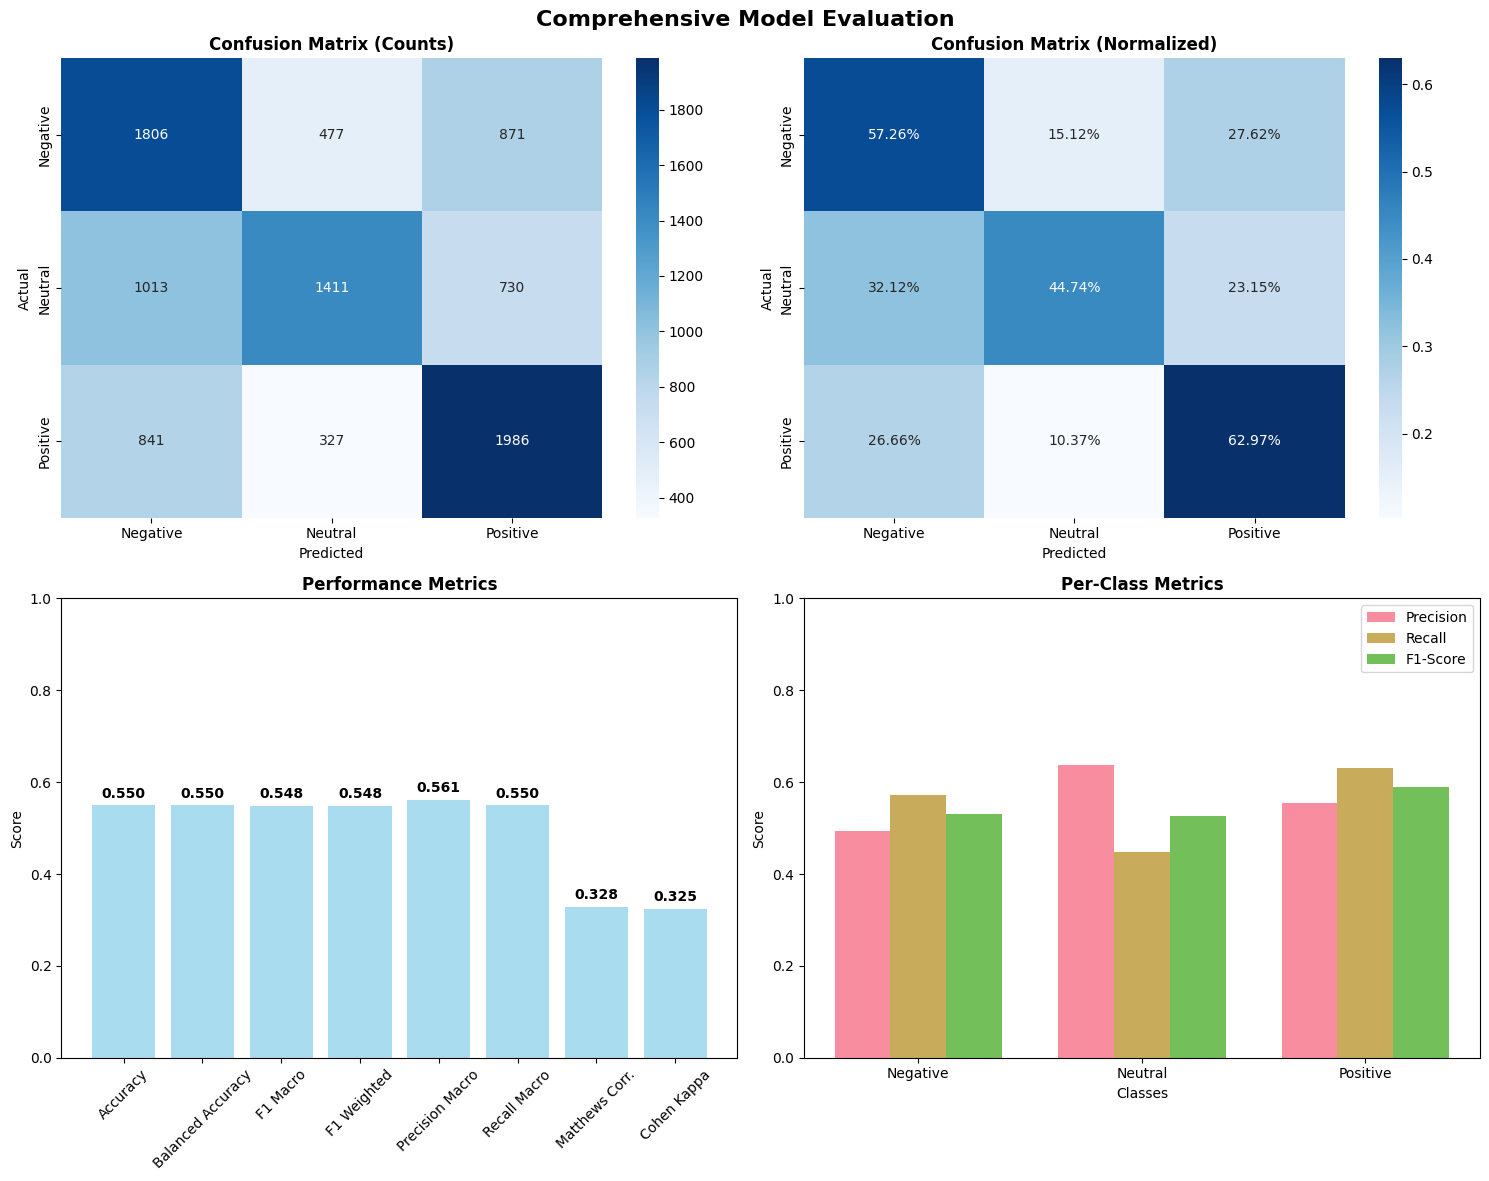

✓ Experiment completed successfully
  Accuracy: 0.5499
  Balanced Accuracy: 0.5499
  F1-Score (Macro): 0.5483

EXPERIMENT 5/30
Vectorizer: bow_unigram | Model: ensemble_voting
Vectorizing text...
  Feature matrix shape: (37848, 10000)
Training model...
Evaluating model...


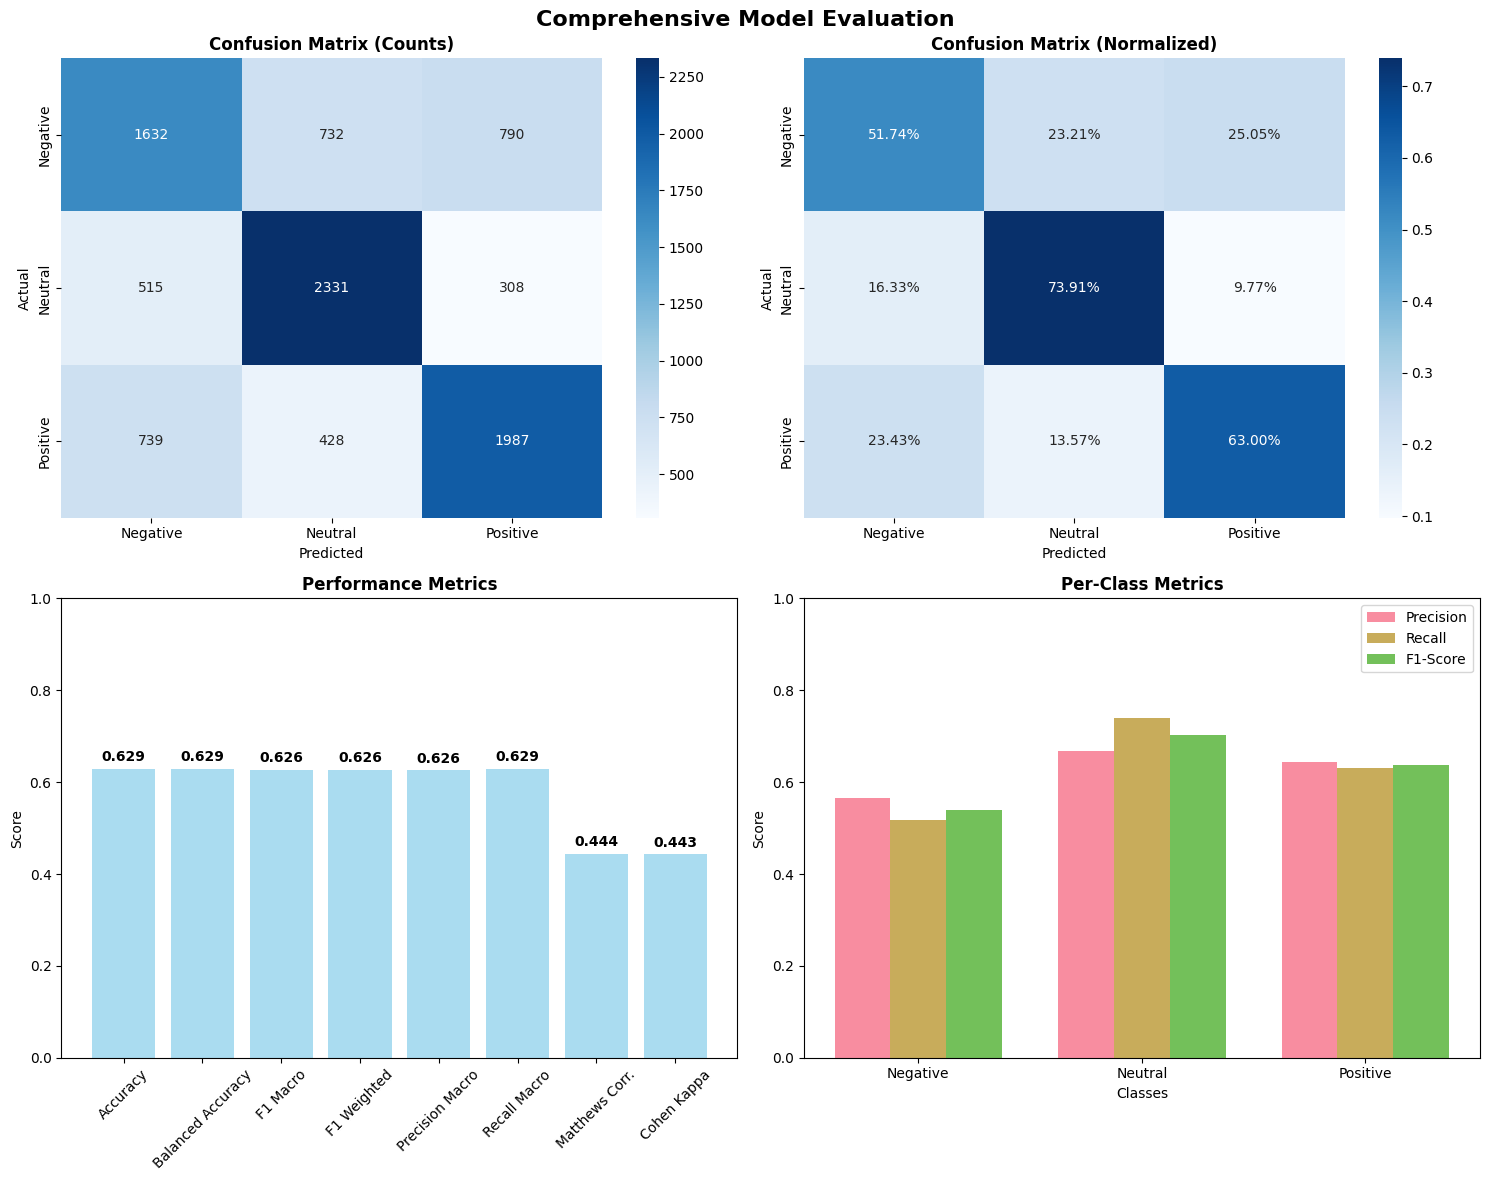

✓ Experiment completed successfully
  Accuracy: 0.6288
  Balanced Accuracy: 0.6288
  F1-Score (Macro): 0.6263

EXPERIMENT 6/30
Vectorizer: bow_bigram | Model: random_forest
Vectorizing text...
  Feature matrix shape: (37848, 15000)
Training model...
Evaluating model...


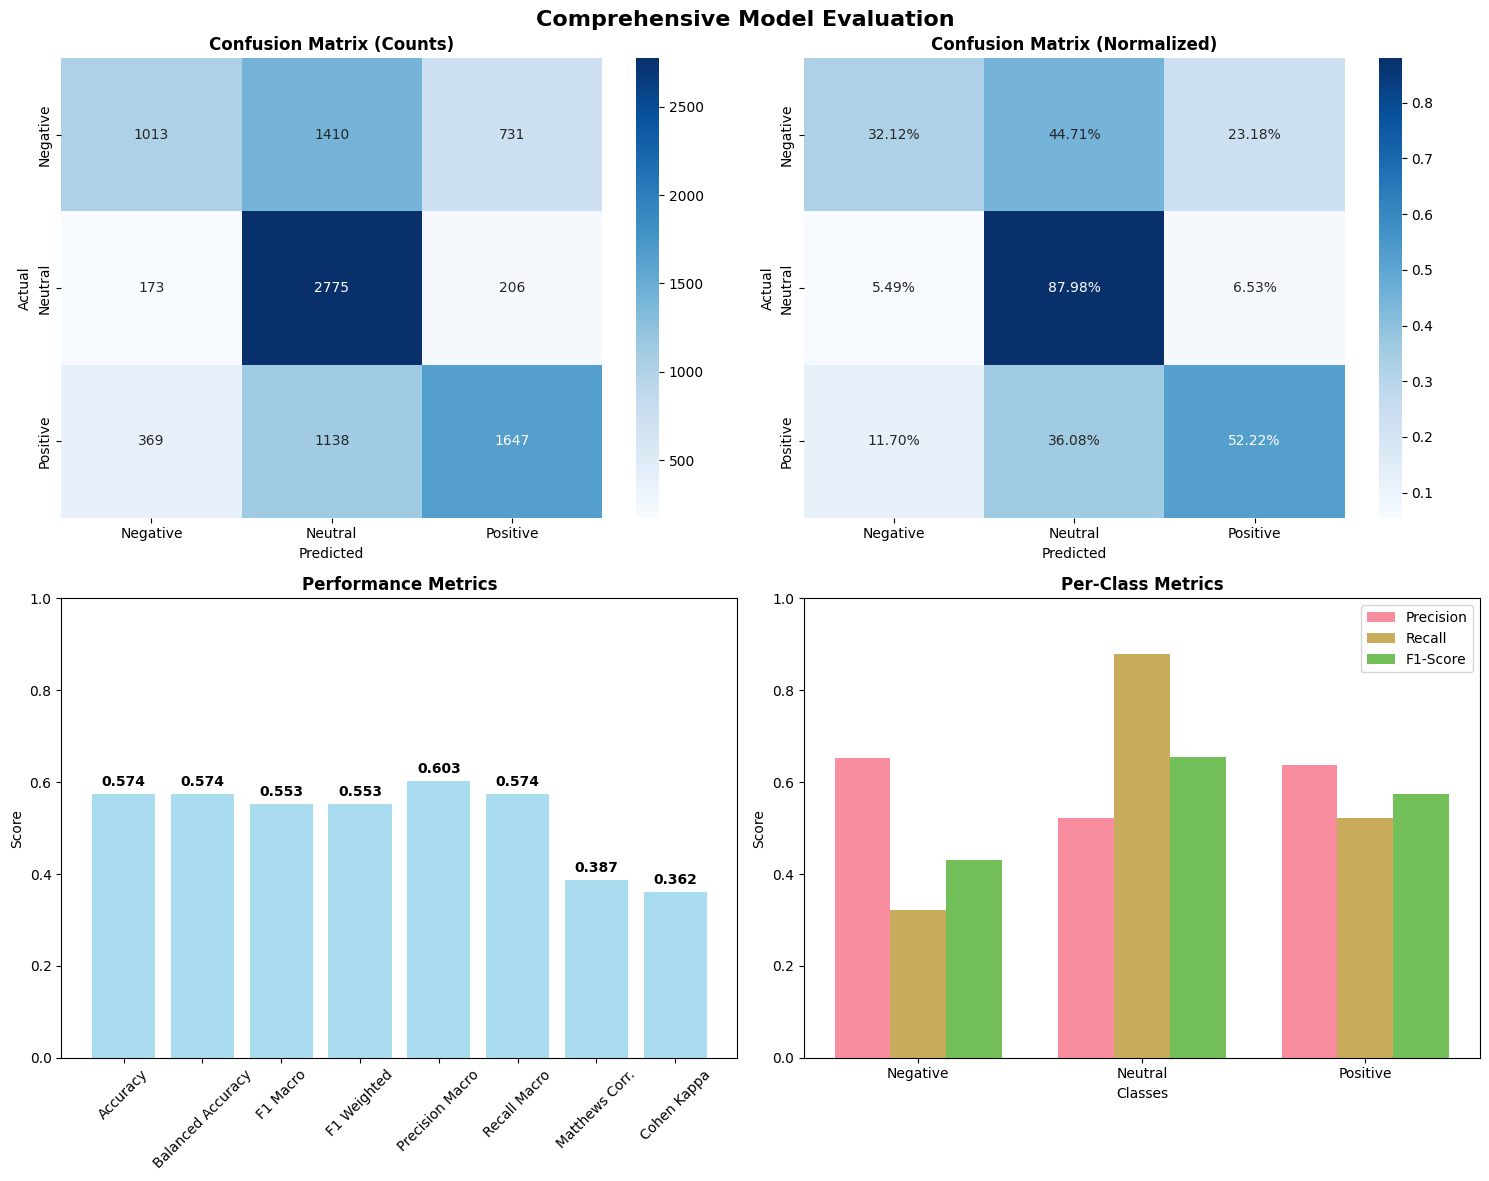

✓ Experiment completed successfully
  Accuracy: 0.5744
  Balanced Accuracy: 0.5744
  F1-Score (Macro): 0.5530

EXPERIMENT 7/30
Vectorizer: bow_bigram | Model: gradient_boosting
Vectorizing text...
  Feature matrix shape: (37848, 15000)
Training model...
Evaluating model...


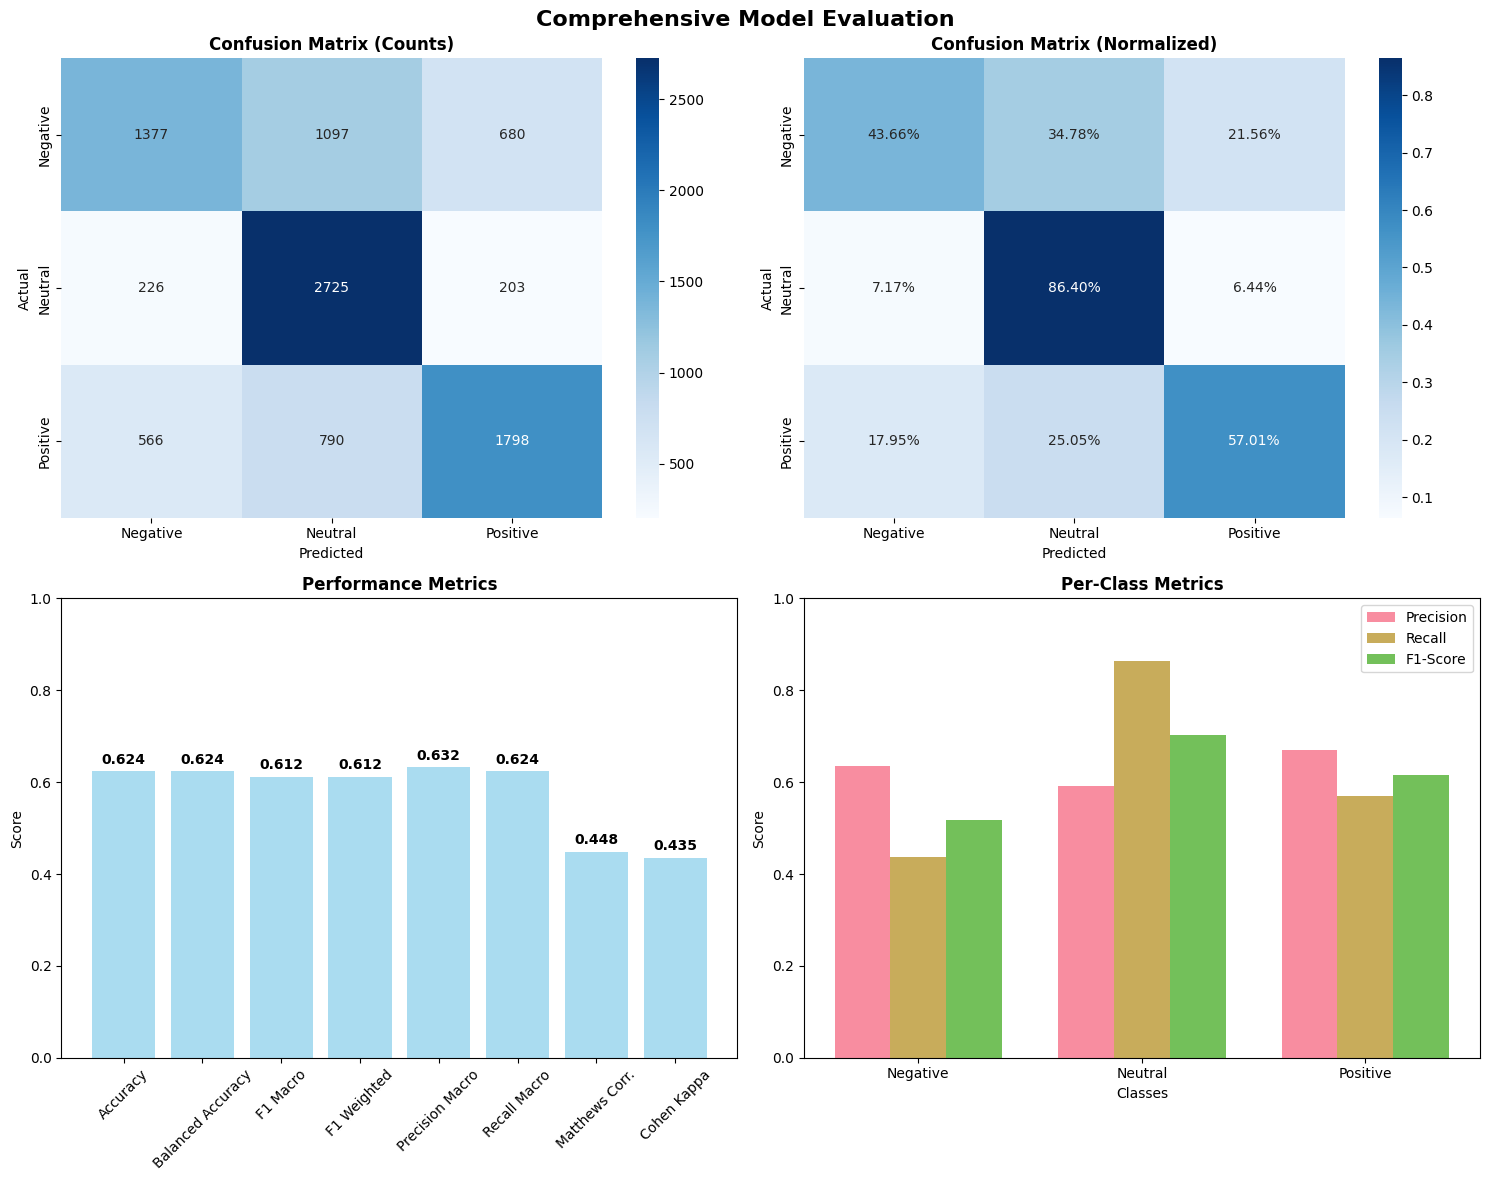

✓ Experiment completed successfully
  Accuracy: 0.6235
  Balanced Accuracy: 0.6235
  F1-Score (Macro): 0.6118

EXPERIMENT 8/30
Vectorizer: bow_bigram | Model: logistic_regression
Vectorizing text...
  Feature matrix shape: (37848, 15000)
Training model...
Evaluating model...


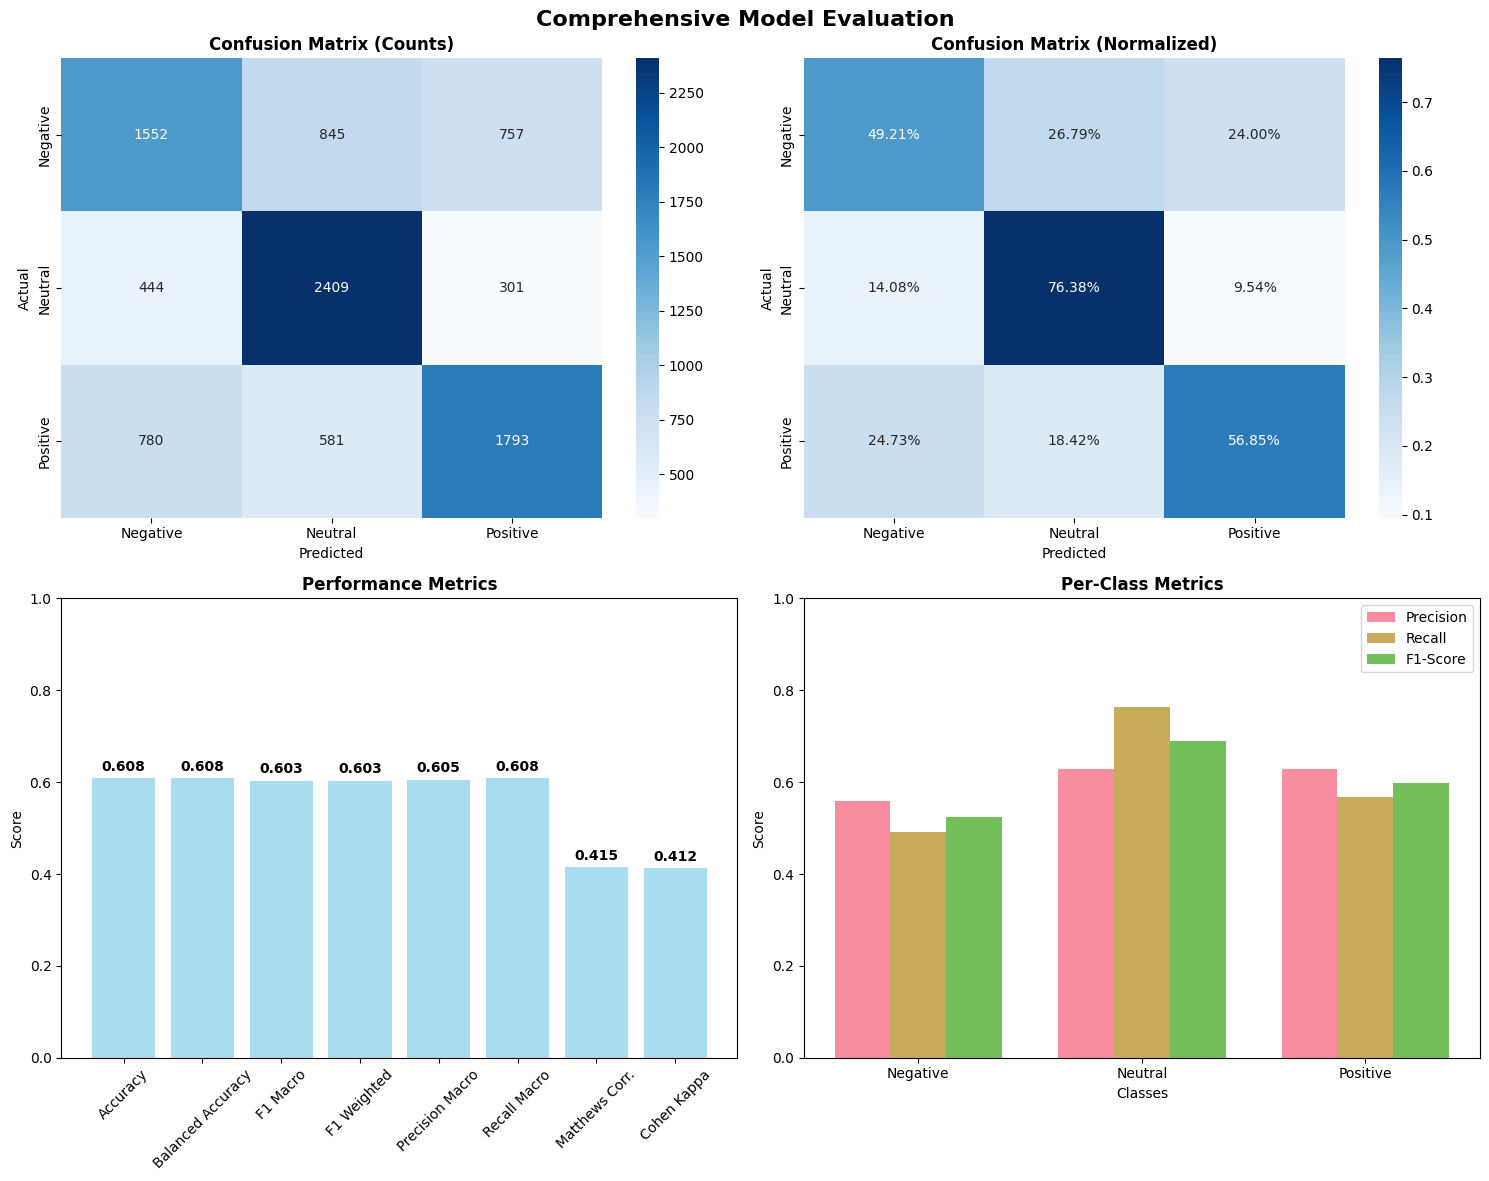

✓ Experiment completed successfully
  Accuracy: 0.6081
  Balanced Accuracy: 0.6081
  F1-Score (Macro): 0.6033

EXPERIMENT 9/30
Vectorizer: bow_bigram | Model: naive_bayes
Vectorizing text...
  Feature matrix shape: (37848, 15000)
Training model...
Evaluating model...


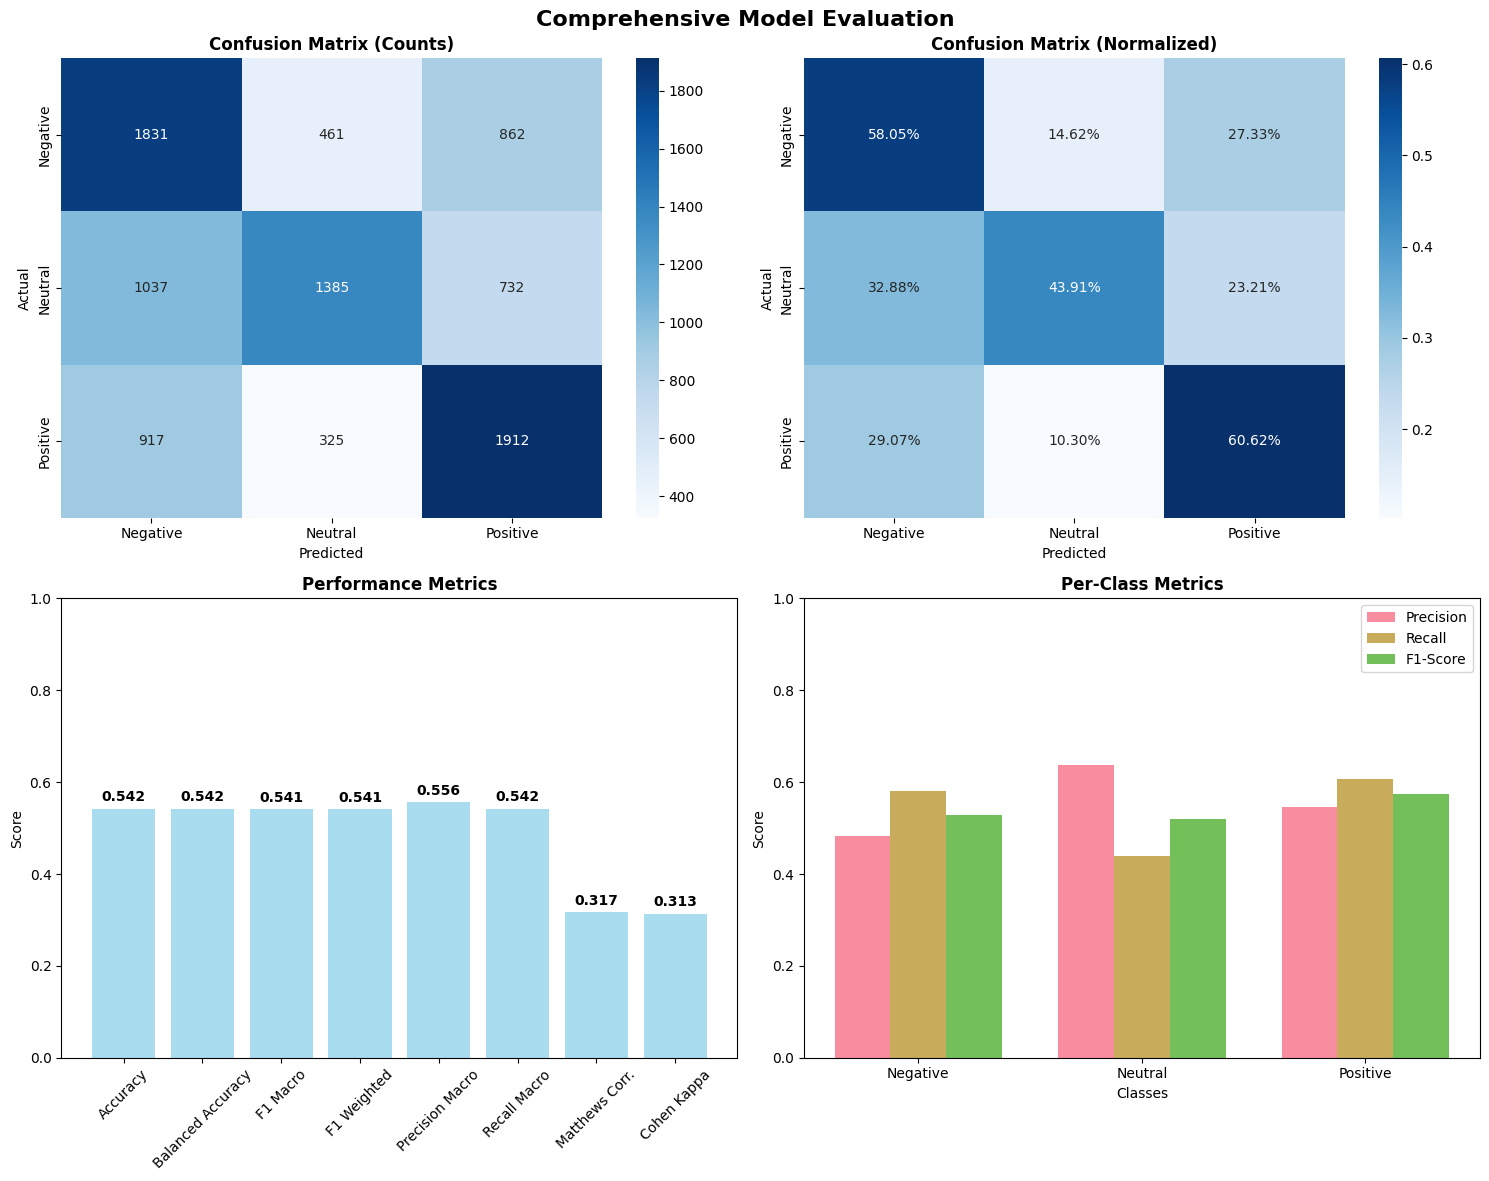

✓ Experiment completed successfully
  Accuracy: 0.5420
  Balanced Accuracy: 0.5420
  F1-Score (Macro): 0.5407

EXPERIMENT 10/30
Vectorizer: bow_bigram | Model: ensemble_voting
Vectorizing text...
  Feature matrix shape: (37848, 15000)
Training model...
Evaluating model...


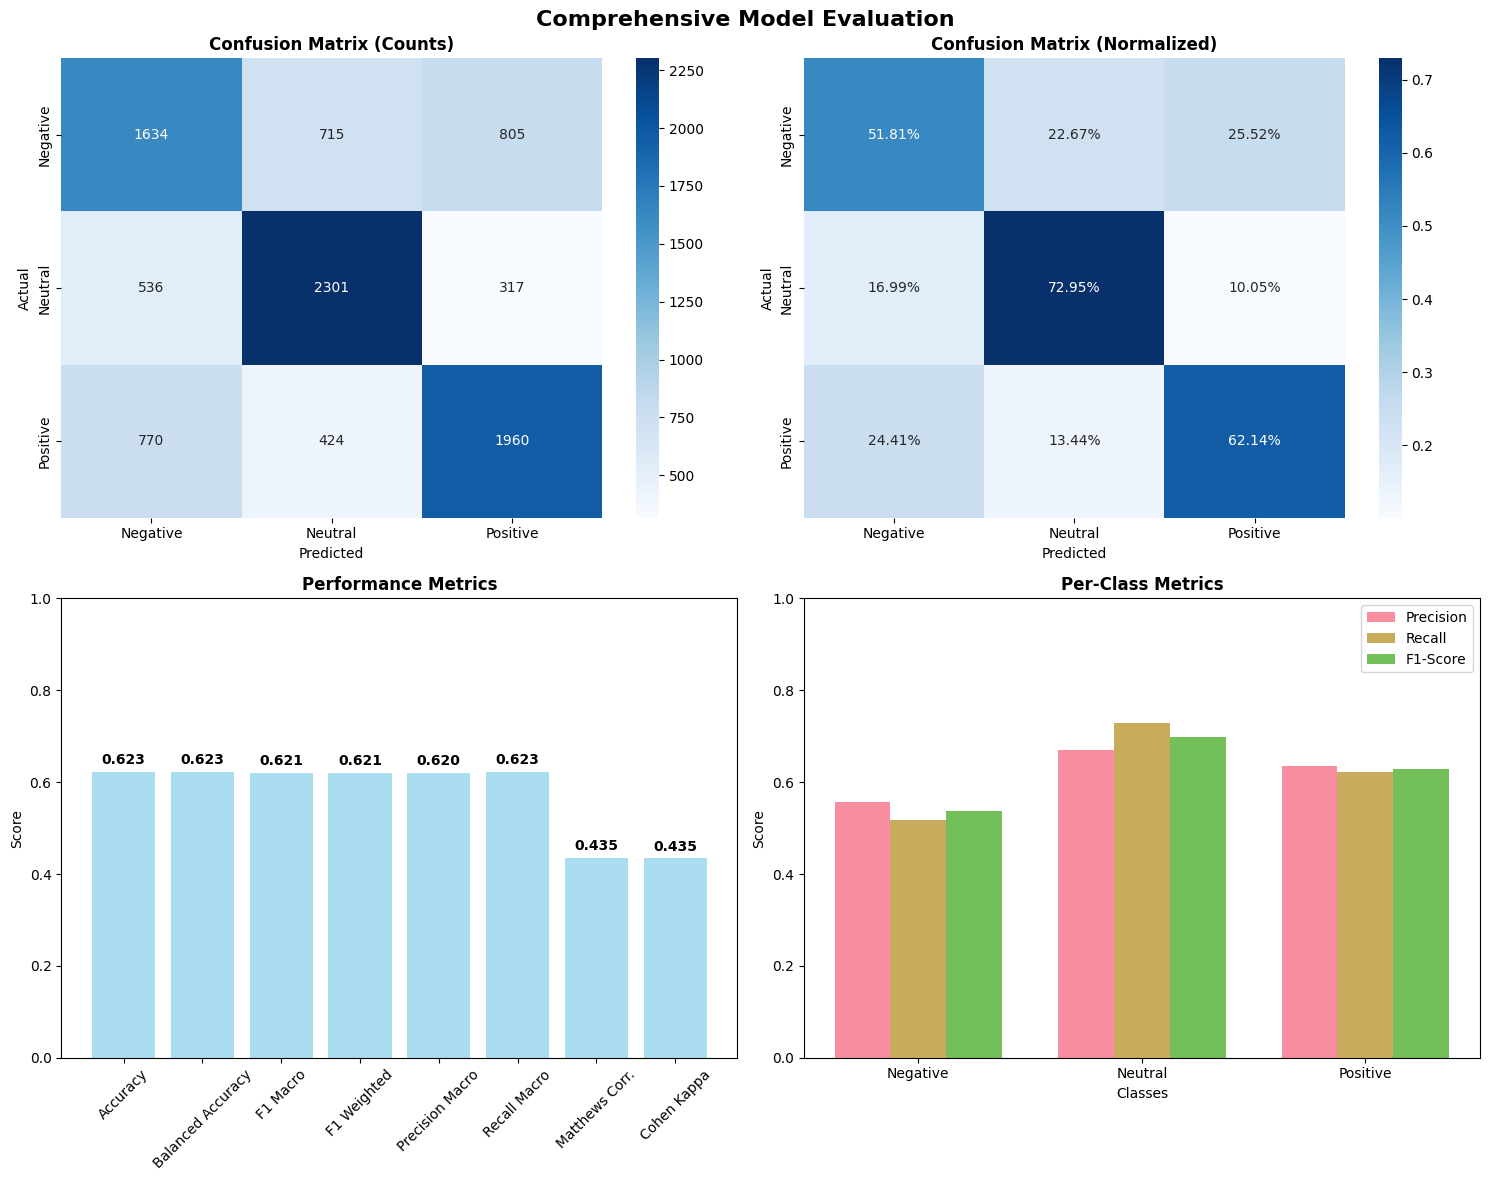

✓ Experiment completed successfully
  Accuracy: 0.6230
  Balanced Accuracy: 0.6230
  F1-Score (Macro): 0.6209

EXPERIMENT 11/30
Vectorizer: tfidf_unigram | Model: random_forest
Vectorizing text...
  Feature matrix shape: (37848, 10000)
Training model...
Evaluating model...


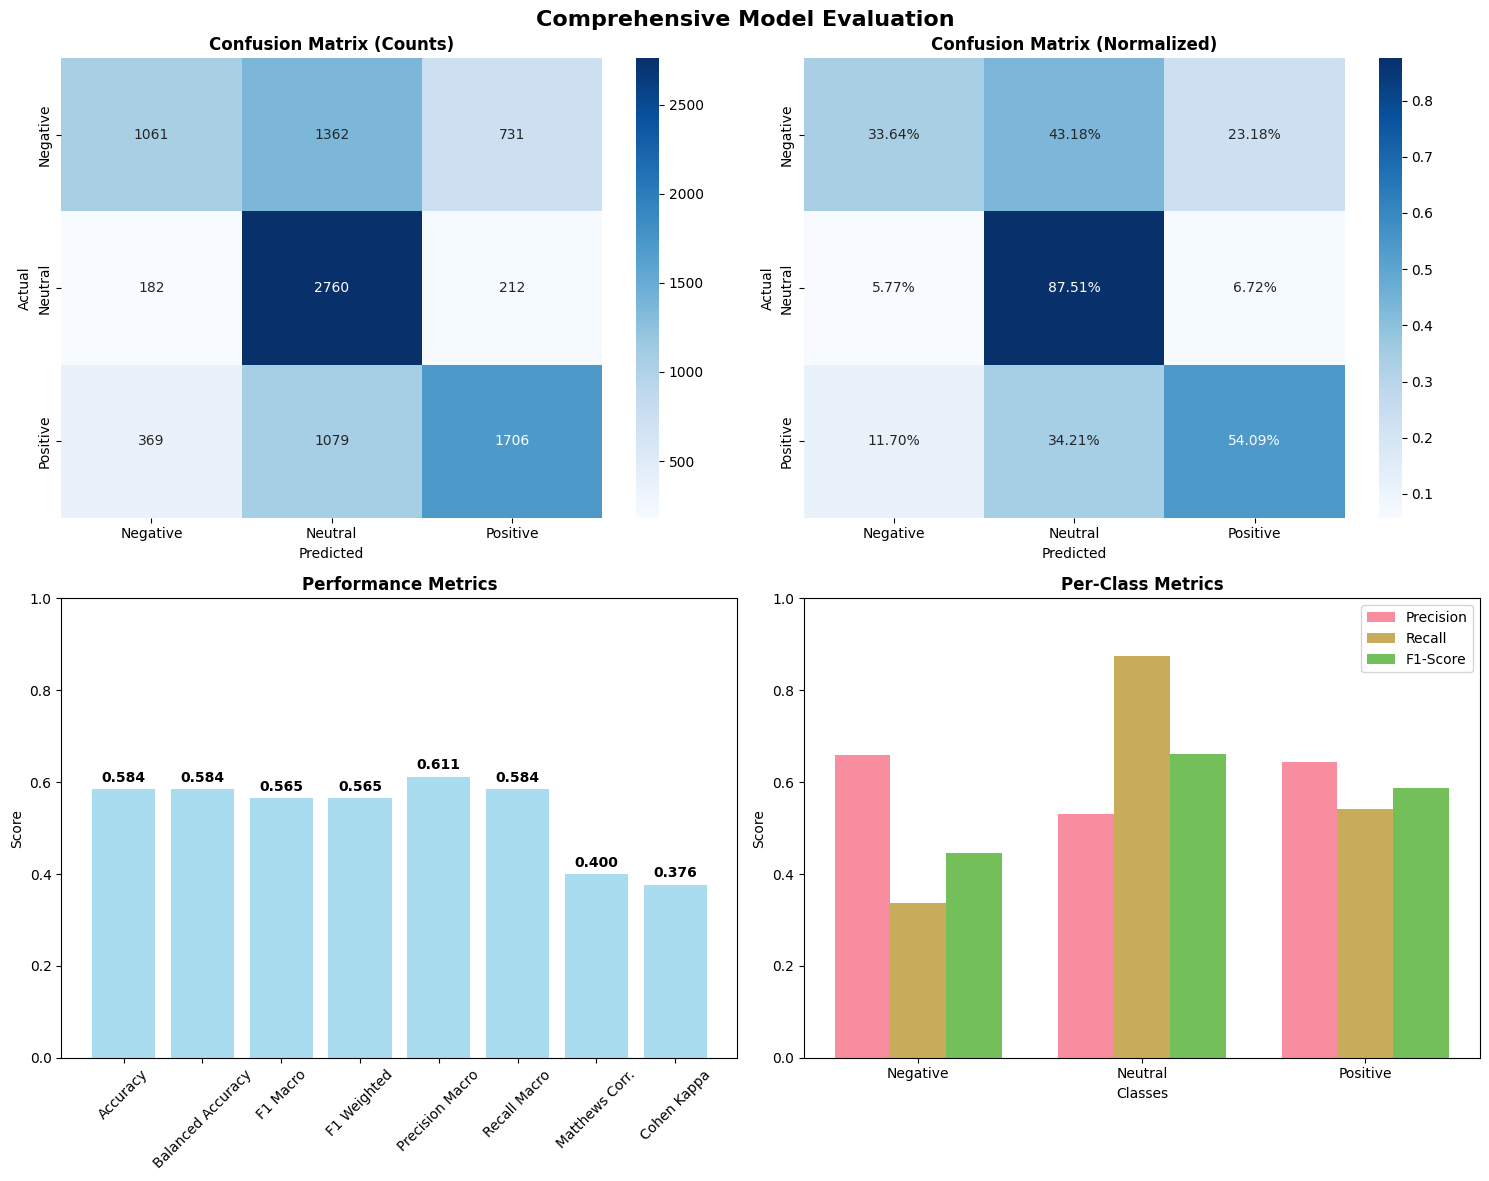

✓ Experiment completed successfully
  Accuracy: 0.5841
  Balanced Accuracy: 0.5841
  F1-Score (Macro): 0.5646

EXPERIMENT 12/30
Vectorizer: tfidf_unigram | Model: gradient_boosting
Vectorizing text...
  Feature matrix shape: (37848, 10000)
Training model...
Evaluating model...


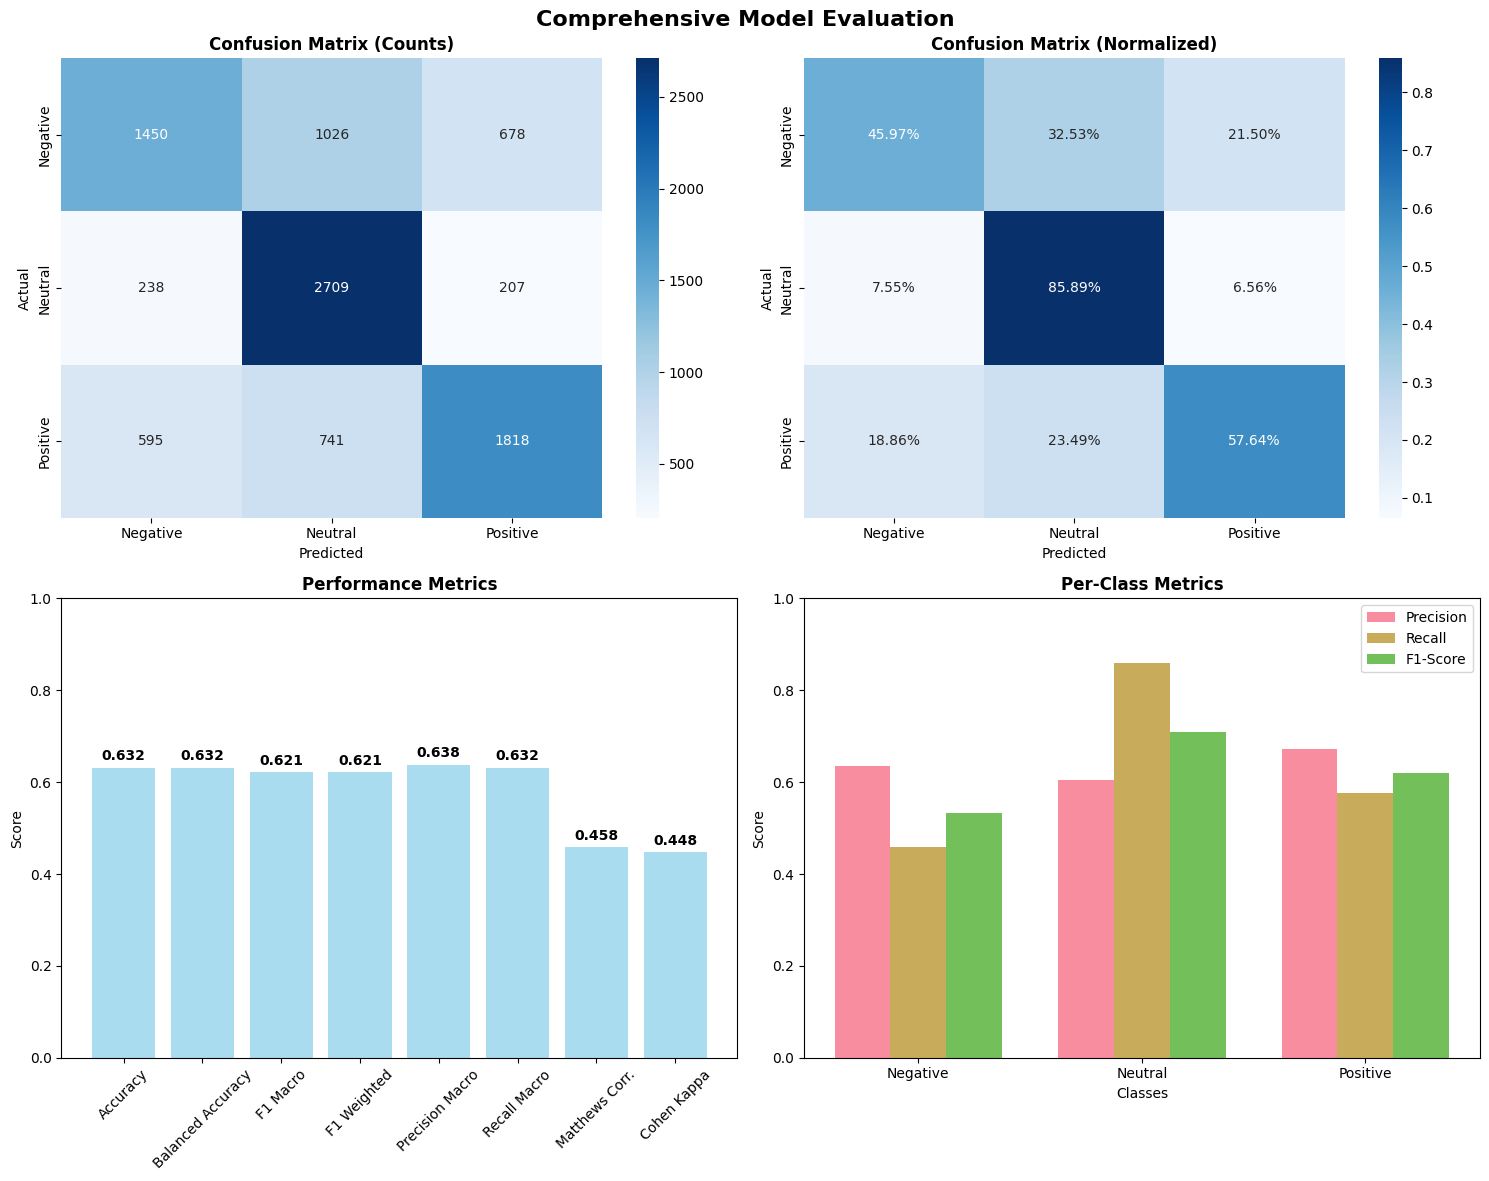

✓ Experiment completed successfully
  Accuracy: 0.6317
  Balanced Accuracy: 0.6317
  F1-Score (Macro): 0.6214

EXPERIMENT 13/30
Vectorizer: tfidf_unigram | Model: logistic_regression
Vectorizing text...
  Feature matrix shape: (37848, 10000)
Training model...
Evaluating model...


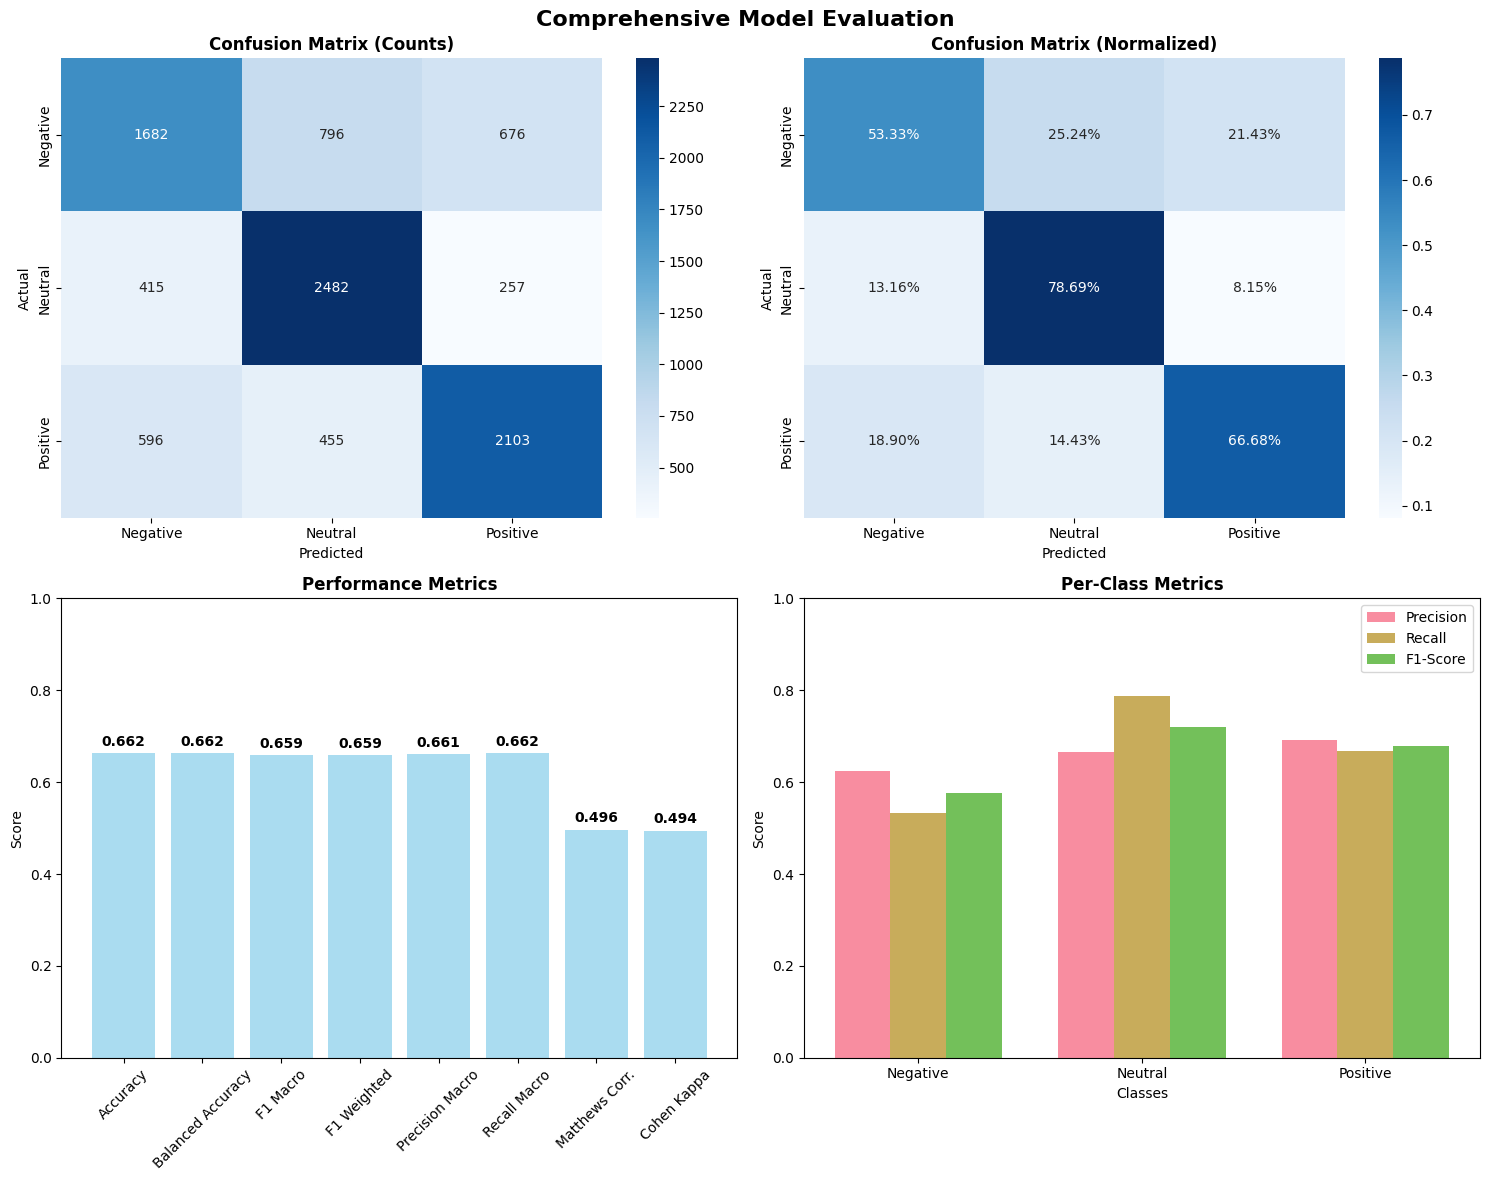

✓ Experiment completed successfully
  Accuracy: 0.6623
  Balanced Accuracy: 0.6623
  F1-Score (Macro): 0.6585

EXPERIMENT 14/30
Vectorizer: tfidf_unigram | Model: naive_bayes
Vectorizing text...
  Feature matrix shape: (37848, 10000)
Training model...
Evaluating model...


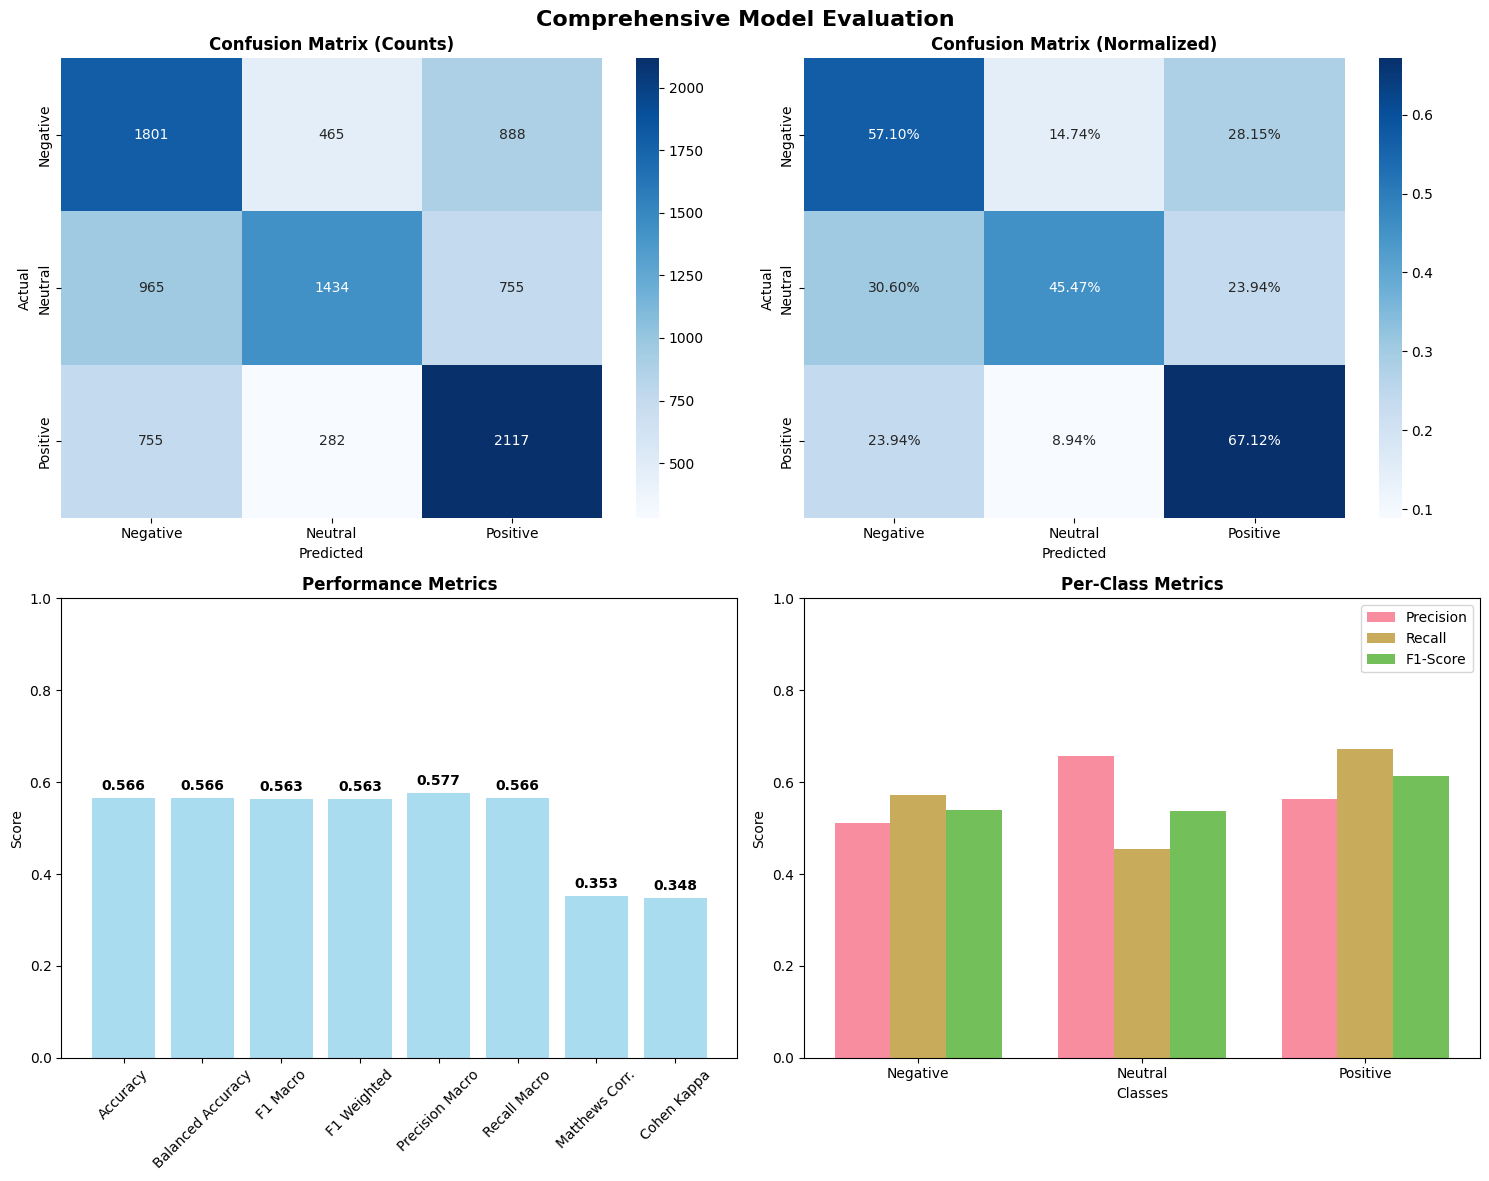

✓ Experiment completed successfully
  Accuracy: 0.5656
  Balanced Accuracy: 0.5656
  F1-Score (Macro): 0.5632

EXPERIMENT 15/30
Vectorizer: tfidf_unigram | Model: ensemble_voting
Vectorizing text...
  Feature matrix shape: (37848, 10000)
Training model...
Evaluating model...


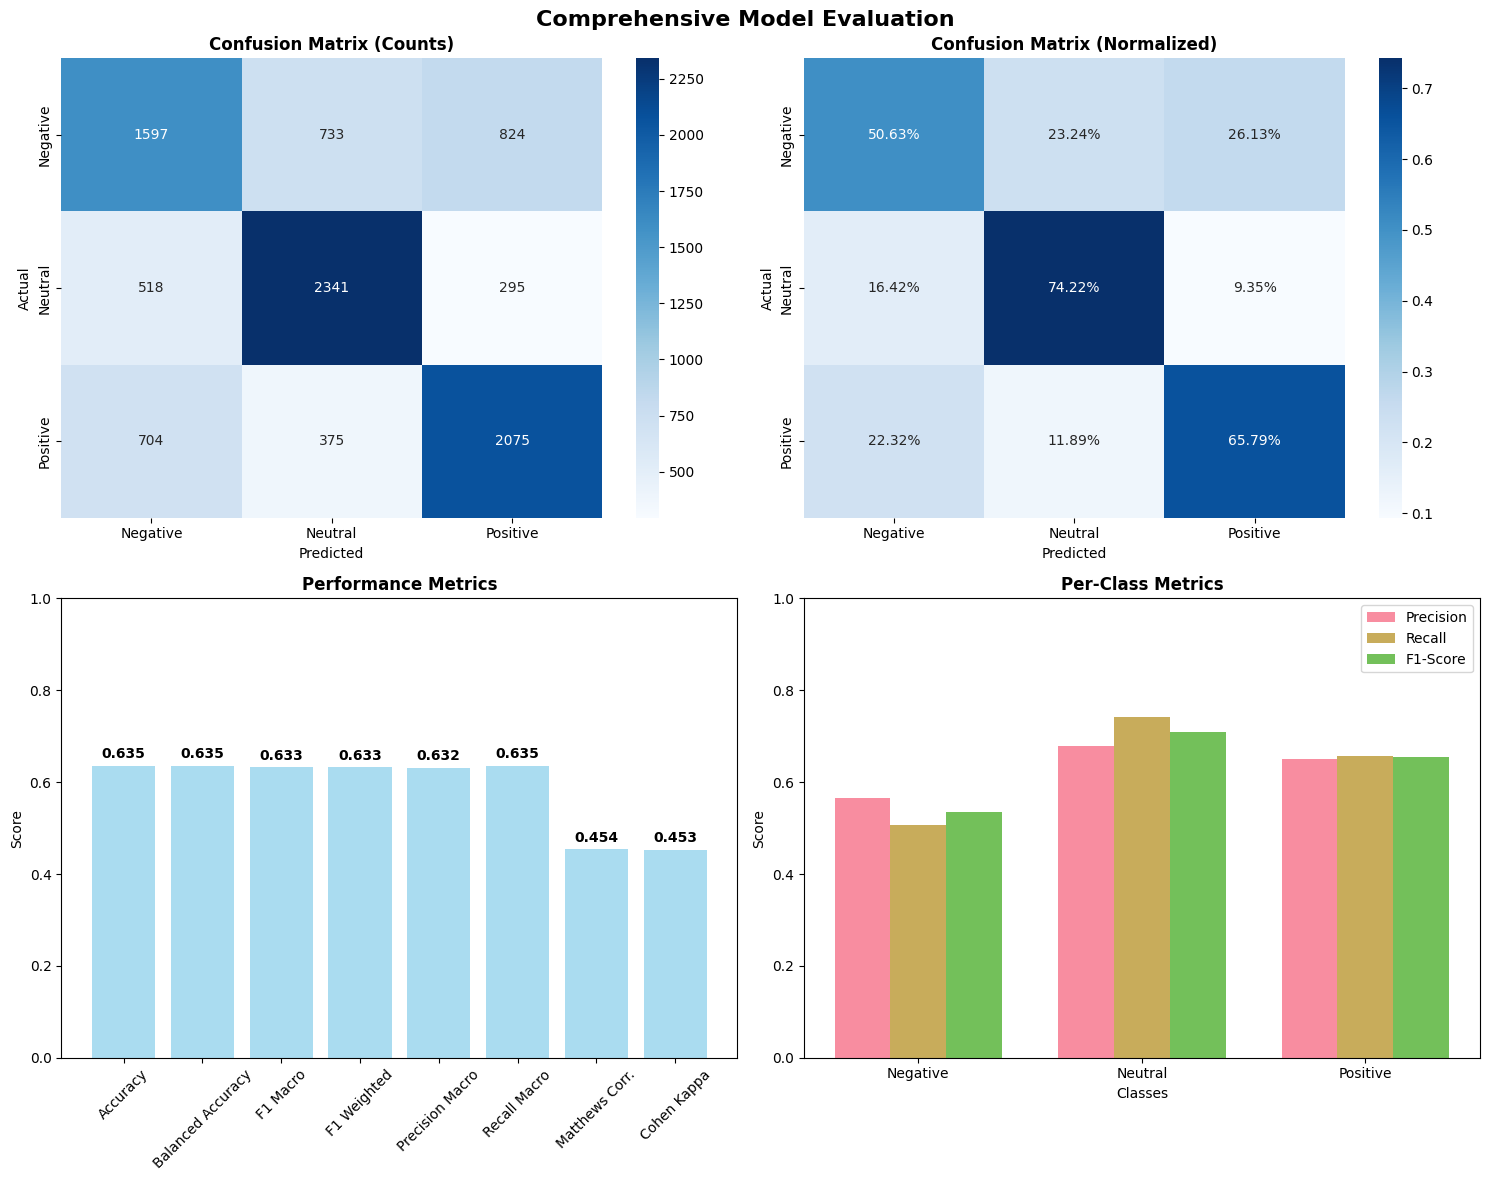

✓ Experiment completed successfully
  Accuracy: 0.6355
  Balanced Accuracy: 0.6355
  F1-Score (Macro): 0.6325

EXPERIMENT 16/30
Vectorizer: tfidf_bigram | Model: random_forest
Vectorizing text...
  Feature matrix shape: (37848, 15000)
Training model...
Evaluating model...


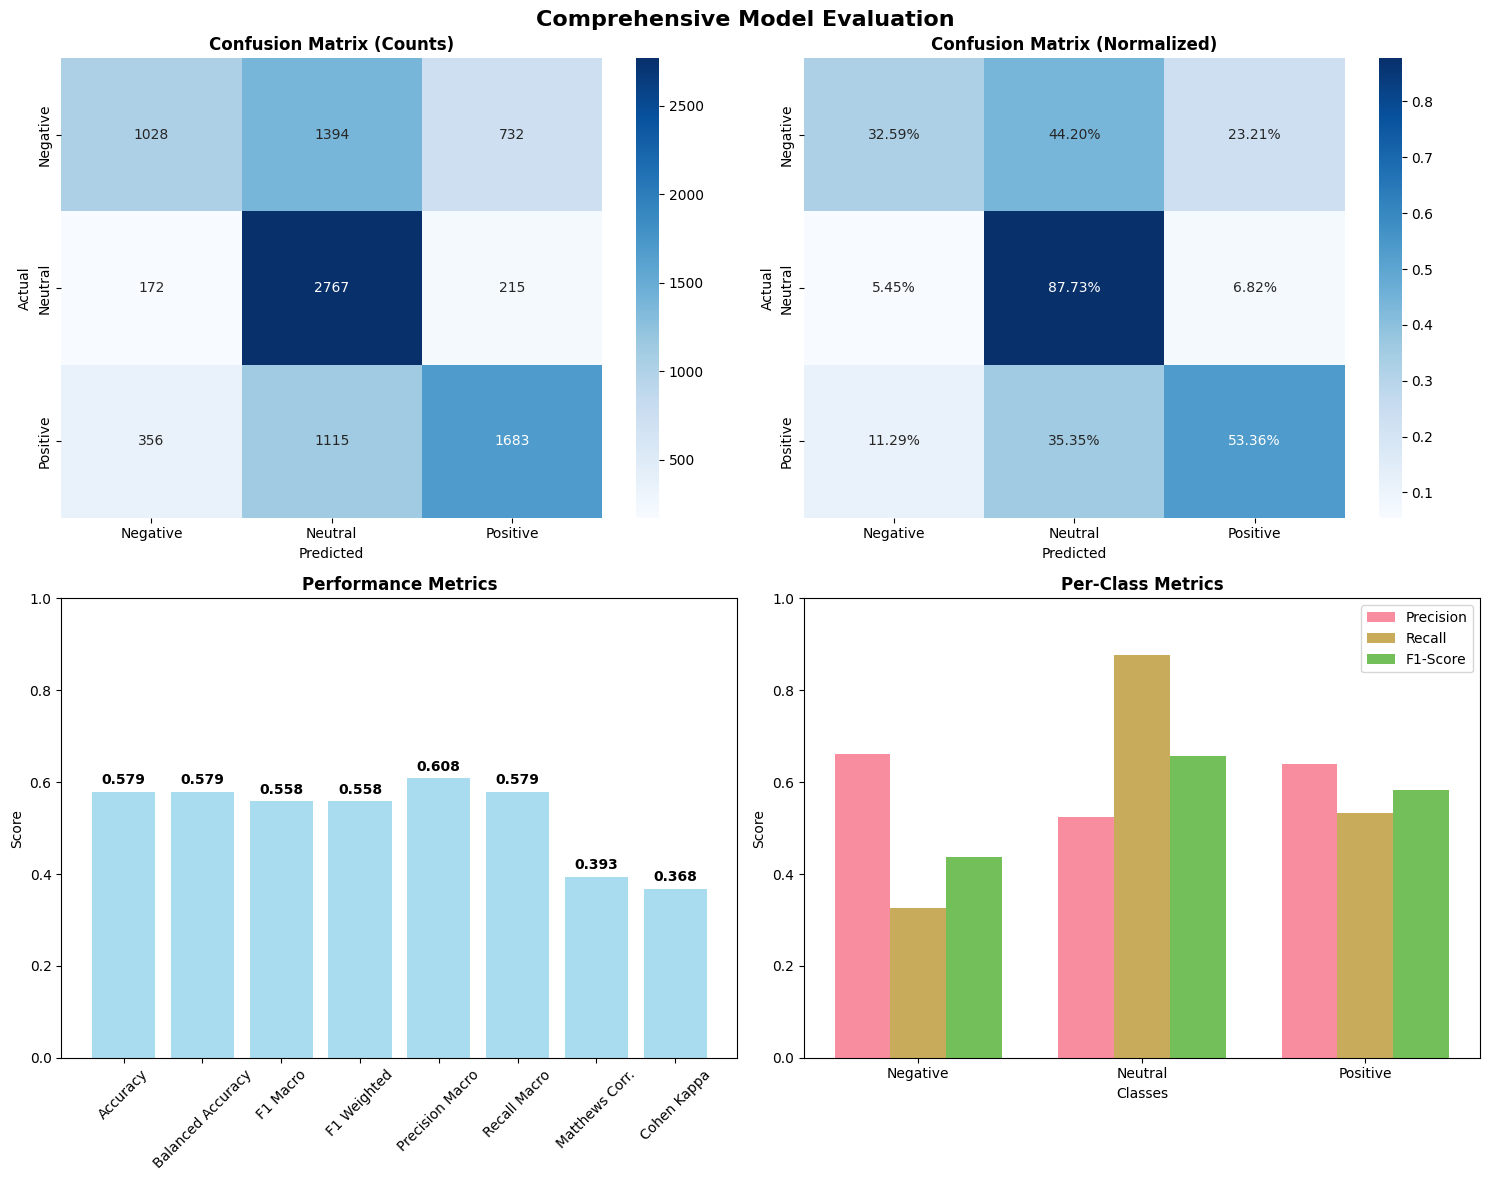

✓ Experiment completed successfully
  Accuracy: 0.5789
  Balanced Accuracy: 0.5789
  F1-Score (Macro): 0.5583

EXPERIMENT 17/30
Vectorizer: tfidf_bigram | Model: gradient_boosting
Vectorizing text...
  Feature matrix shape: (37848, 15000)
Training model...
Evaluating model...


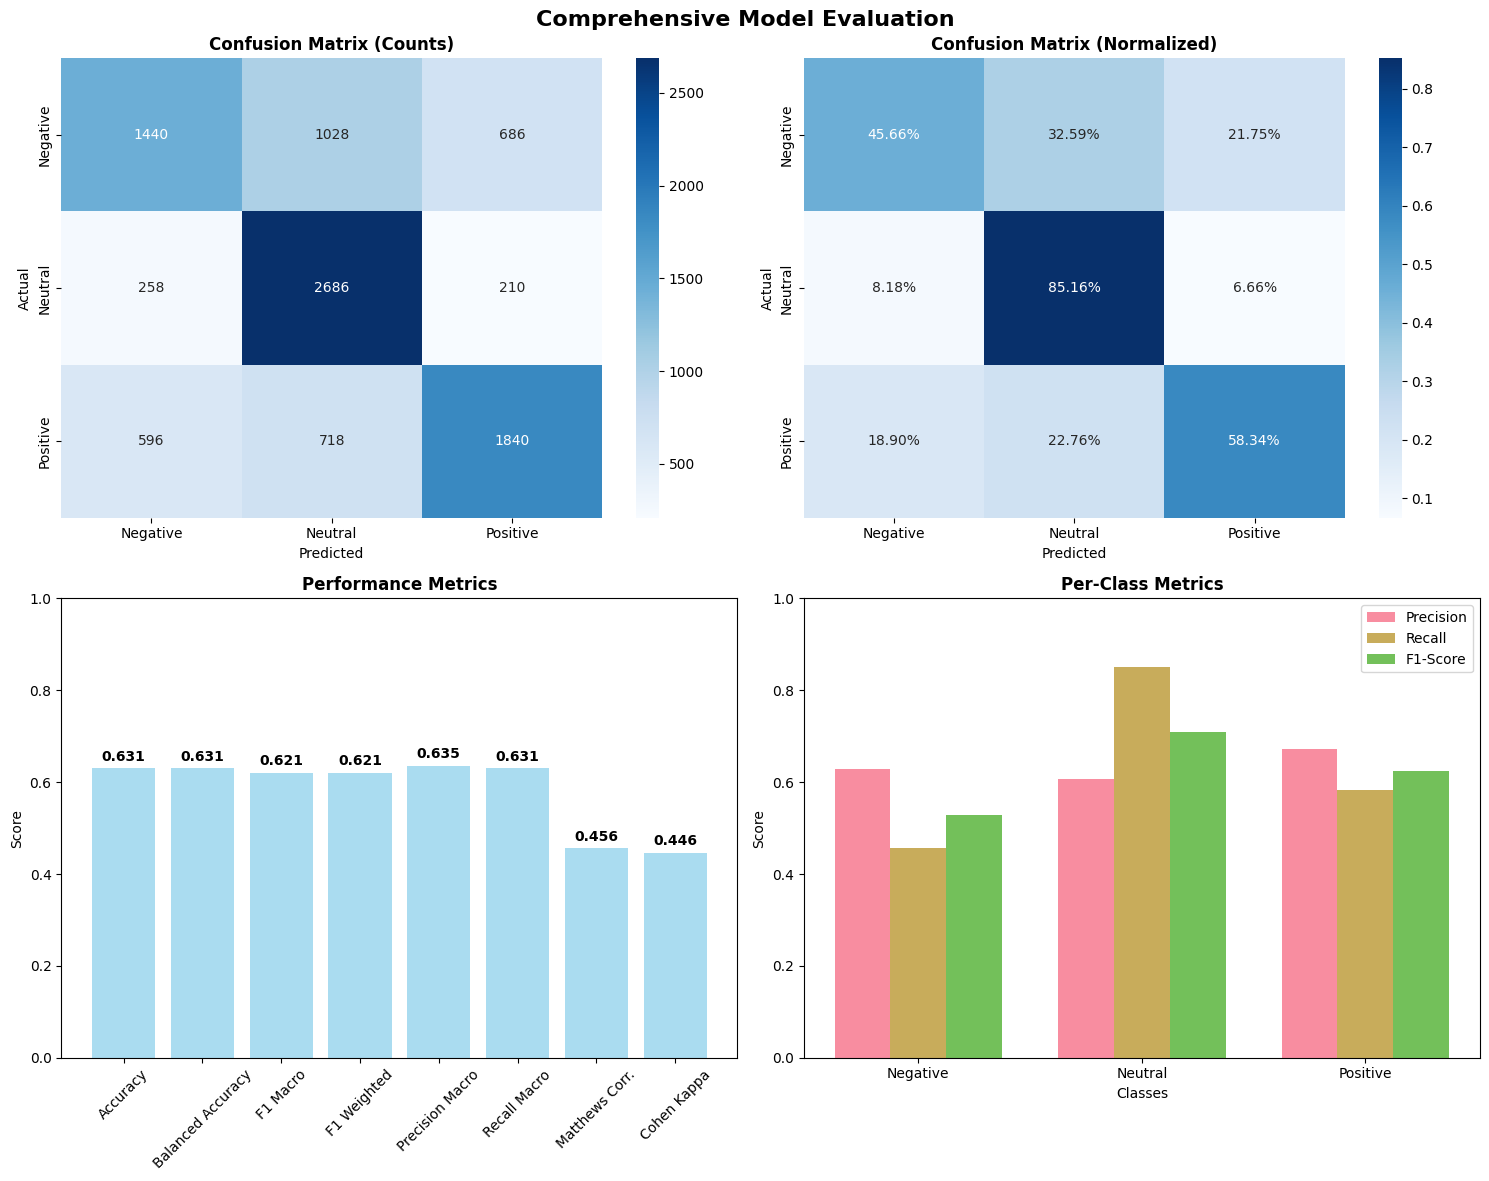

✓ Experiment completed successfully
  Accuracy: 0.6305
  Balanced Accuracy: 0.6305
  F1-Score (Macro): 0.6205

EXPERIMENT 18/30
Vectorizer: tfidf_bigram | Model: logistic_regression
Vectorizing text...
  Feature matrix shape: (37848, 15000)
Training model...
Evaluating model...


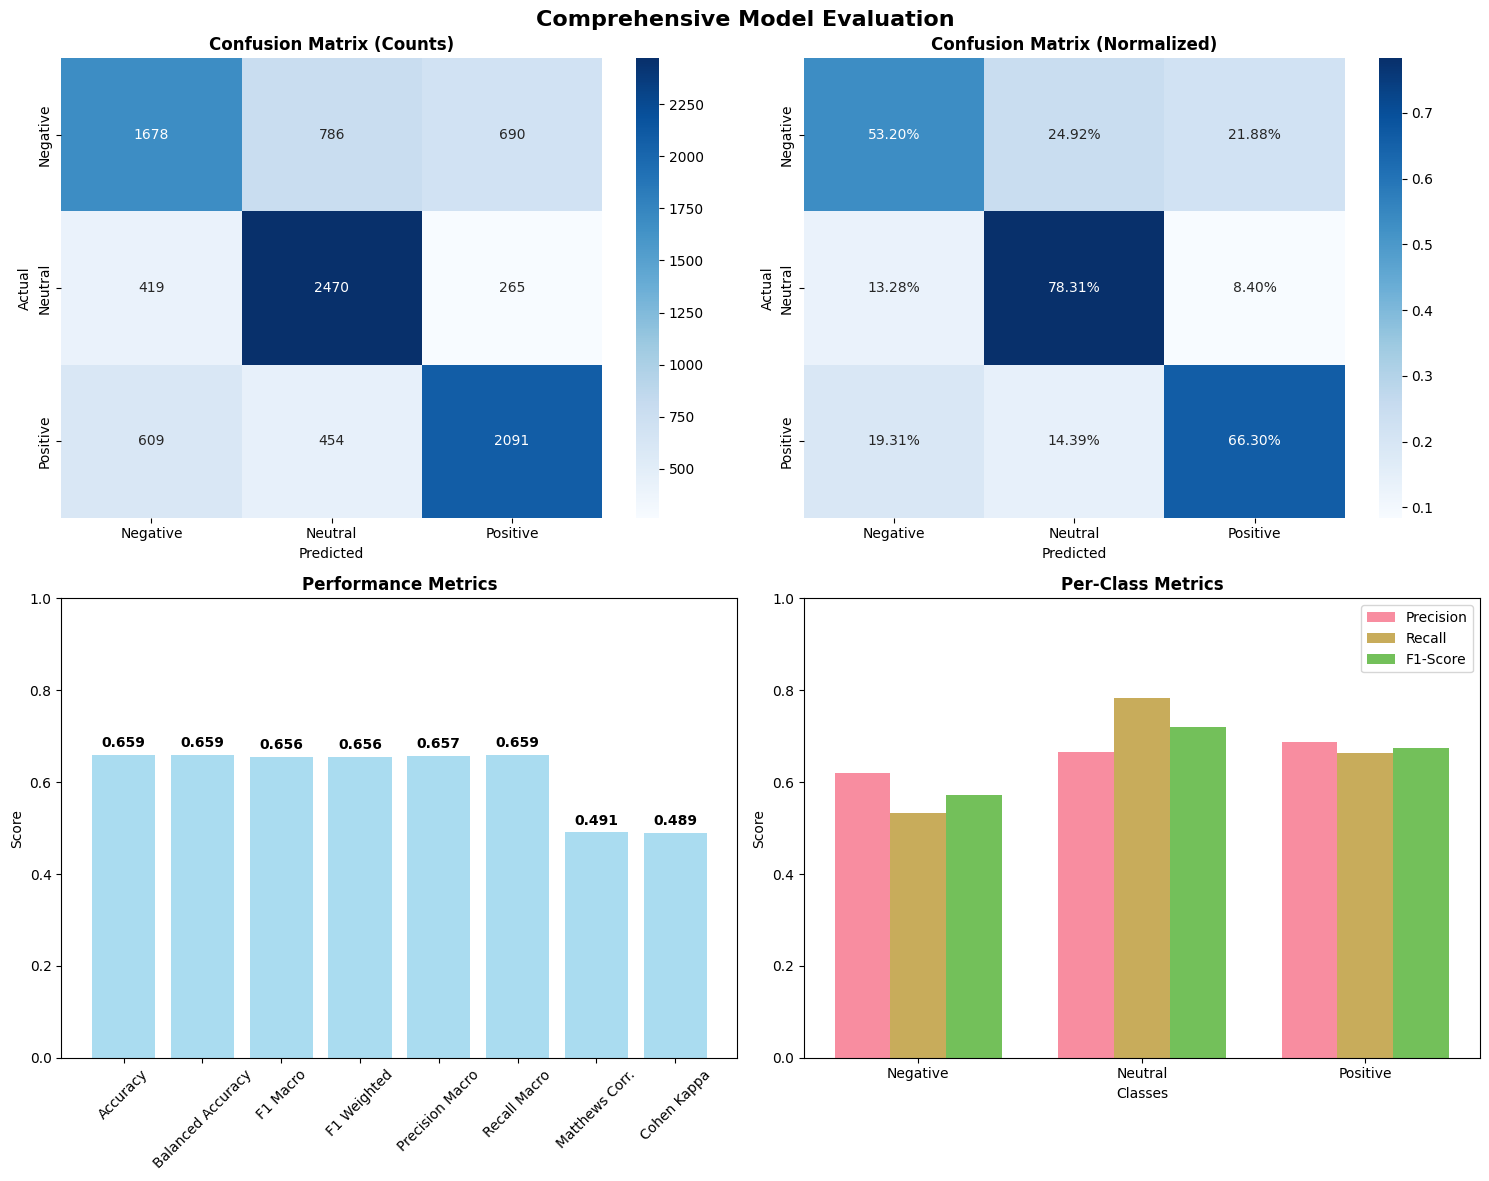

✓ Experiment completed successfully
  Accuracy: 0.6594
  Balanced Accuracy: 0.6594
  F1-Score (Macro): 0.6556

EXPERIMENT 19/30
Vectorizer: tfidf_bigram | Model: naive_bayes
Vectorizing text...
  Feature matrix shape: (37848, 15000)
Training model...
Evaluating model...


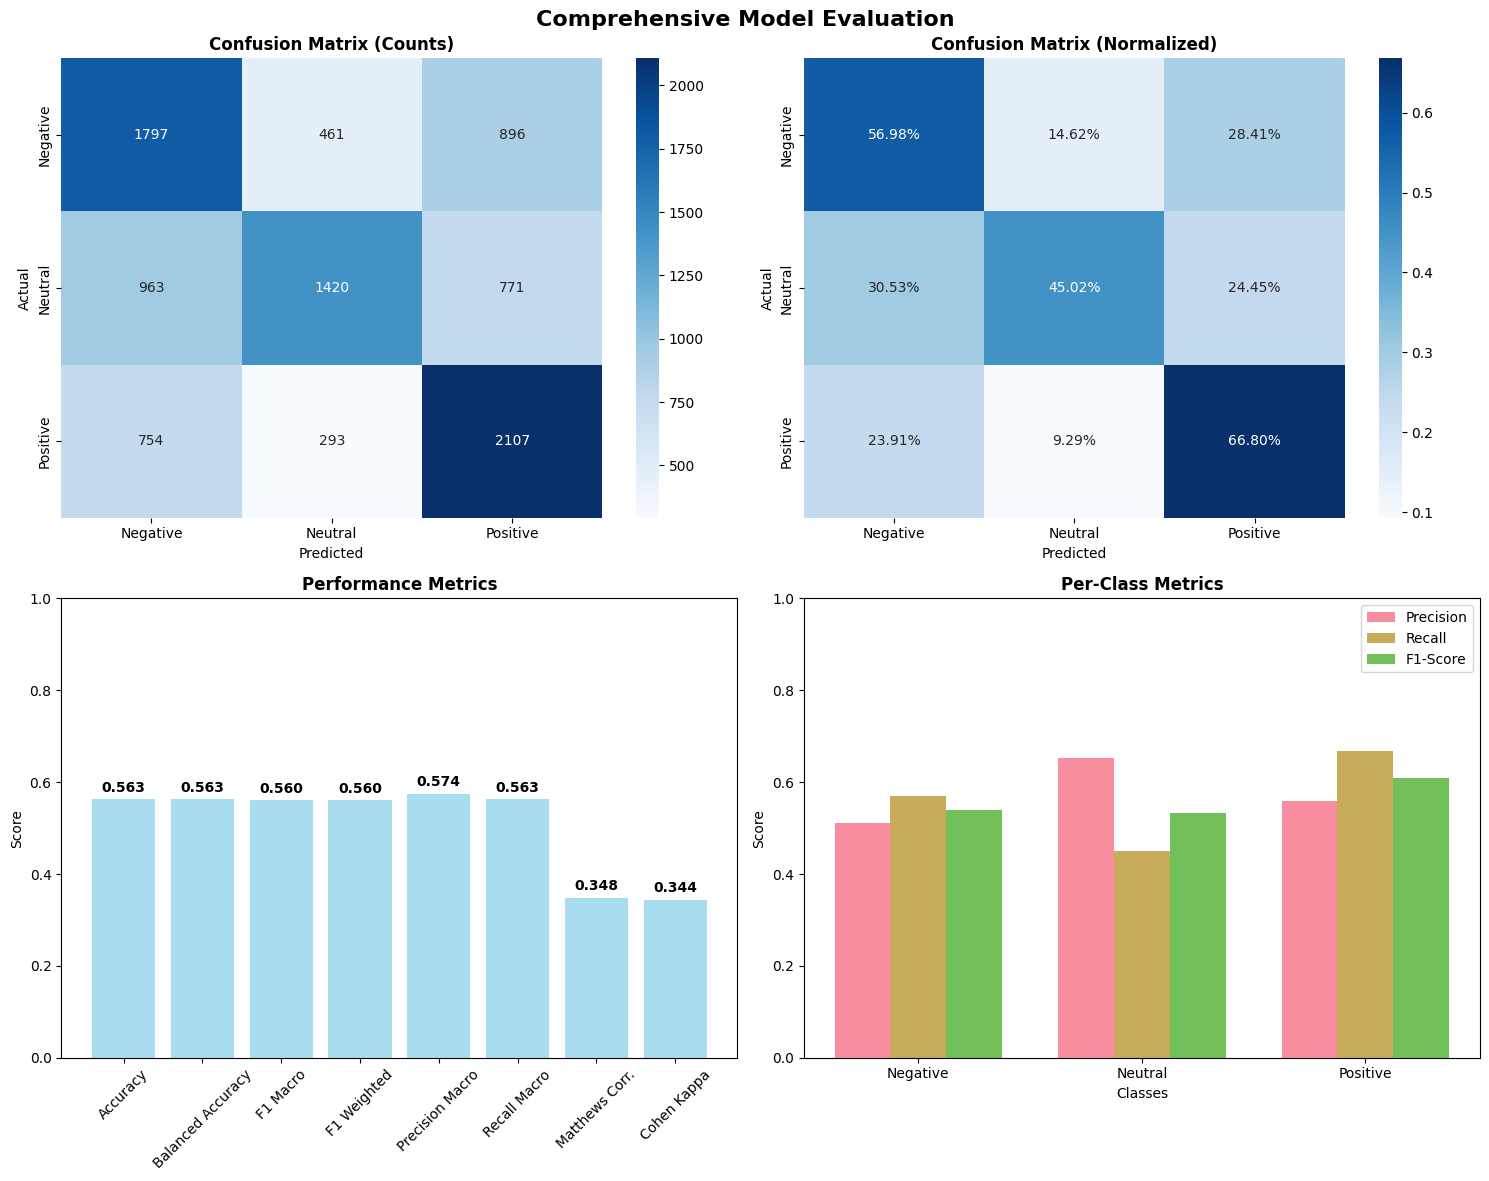

✓ Experiment completed successfully
  Accuracy: 0.5627
  Balanced Accuracy: 0.5627
  F1-Score (Macro): 0.5601

EXPERIMENT 20/30
Vectorizer: tfidf_bigram | Model: ensemble_voting
Vectorizing text...
  Feature matrix shape: (37848, 15000)
Training model...
Evaluating model...


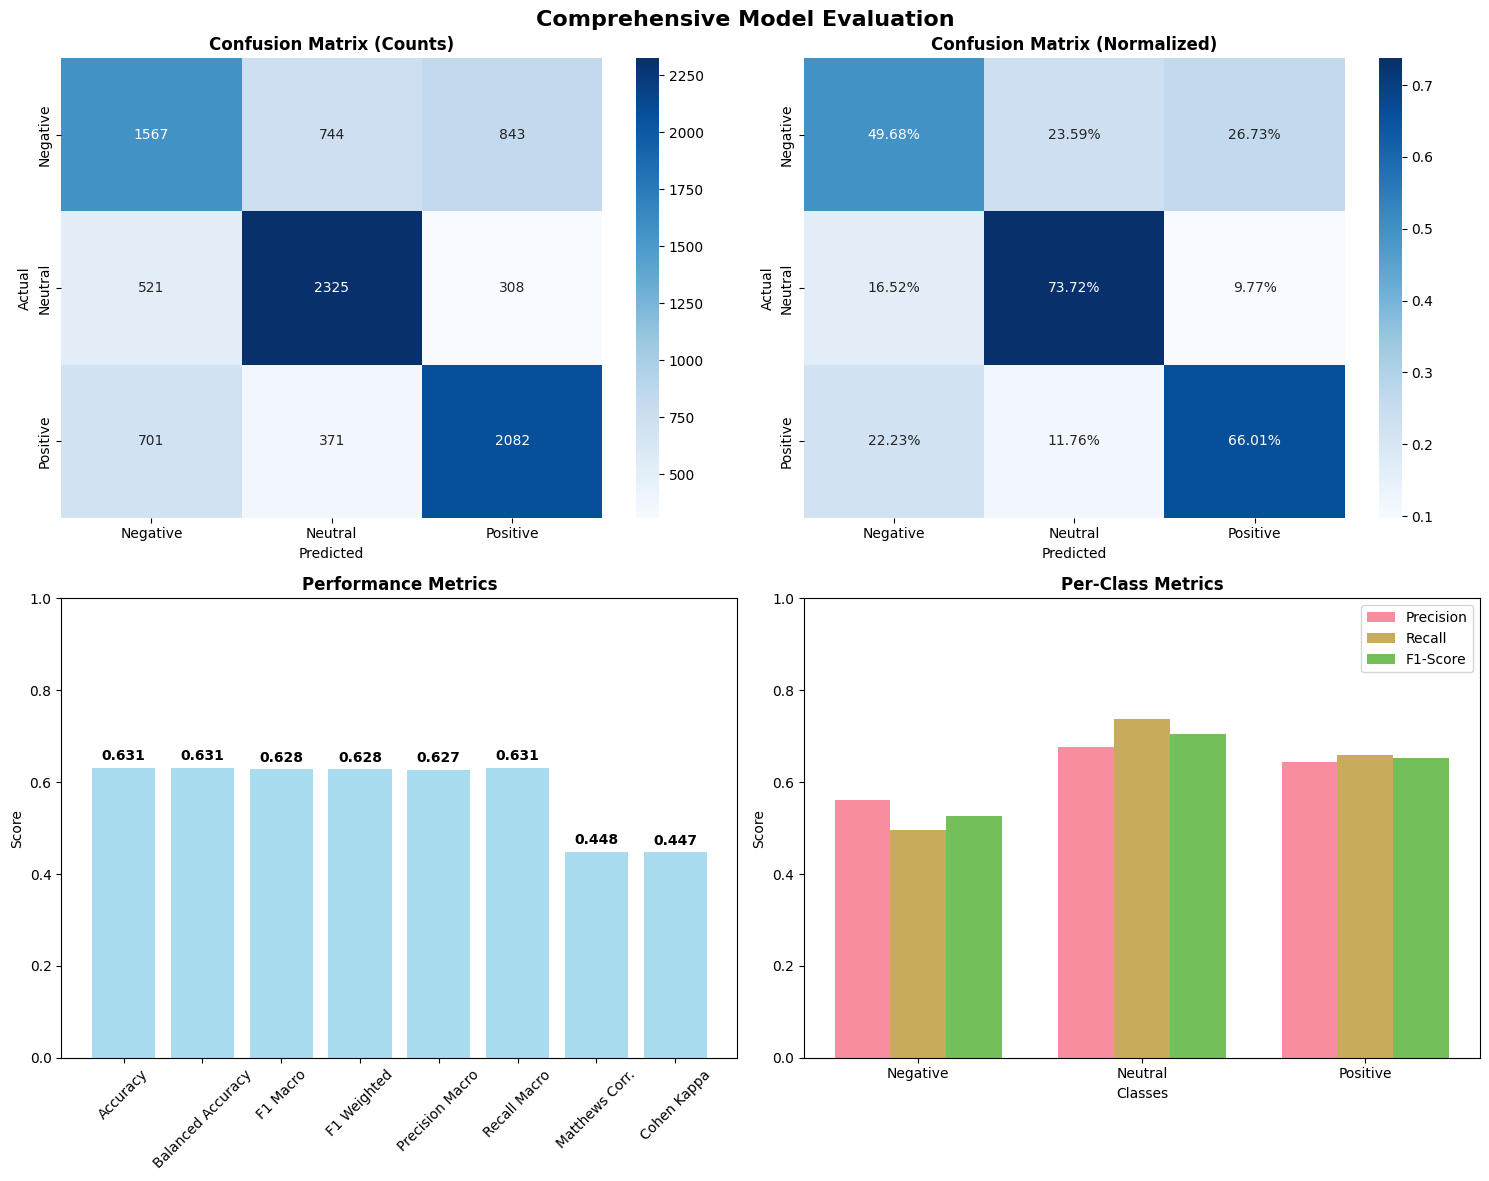

✓ Experiment completed successfully
  Accuracy: 0.6314
  Balanced Accuracy: 0.6314
  F1-Score (Macro): 0.6282

EXPERIMENT 21/30
Vectorizer: tfidf_trigram | Model: random_forest
Vectorizing text...
  Feature matrix shape: (37848, 20000)
Training model...
Evaluating model...


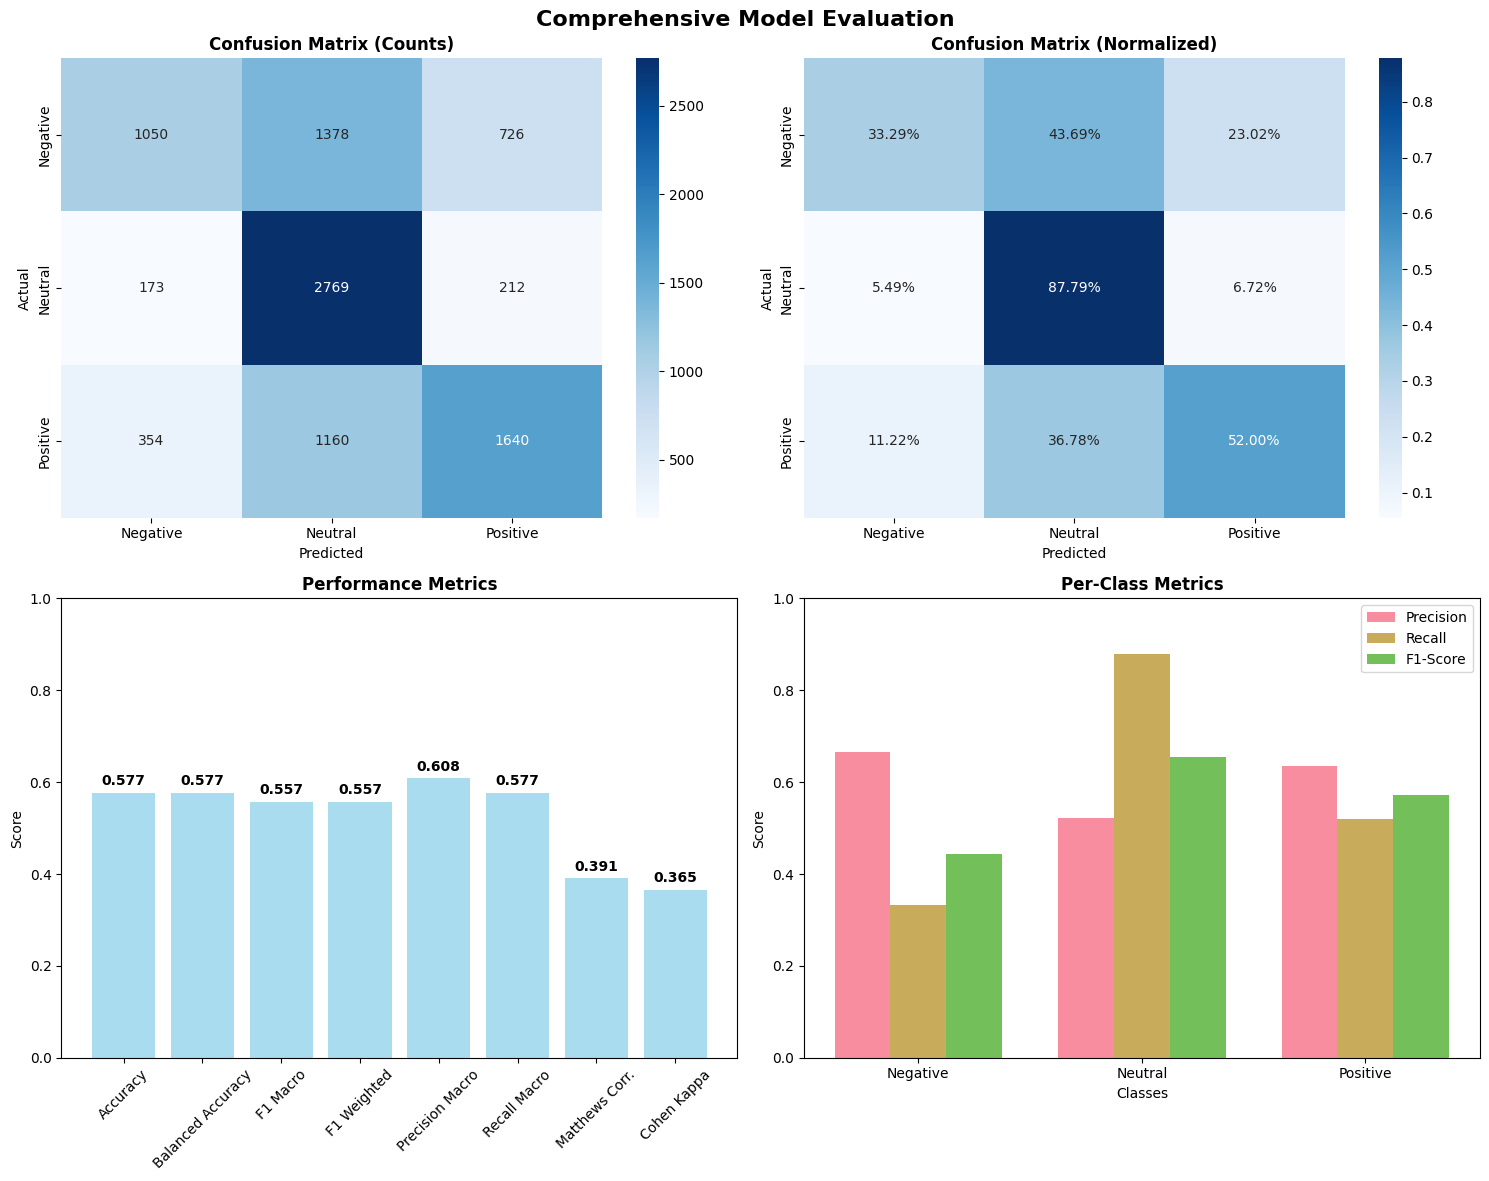

✓ Experiment completed successfully
  Accuracy: 0.5769
  Balanced Accuracy: 0.5769
  F1-Score (Macro): 0.5569

EXPERIMENT 22/30
Vectorizer: tfidf_trigram | Model: gradient_boosting
Vectorizing text...
  Feature matrix shape: (37848, 20000)
Training model...
Evaluating model...


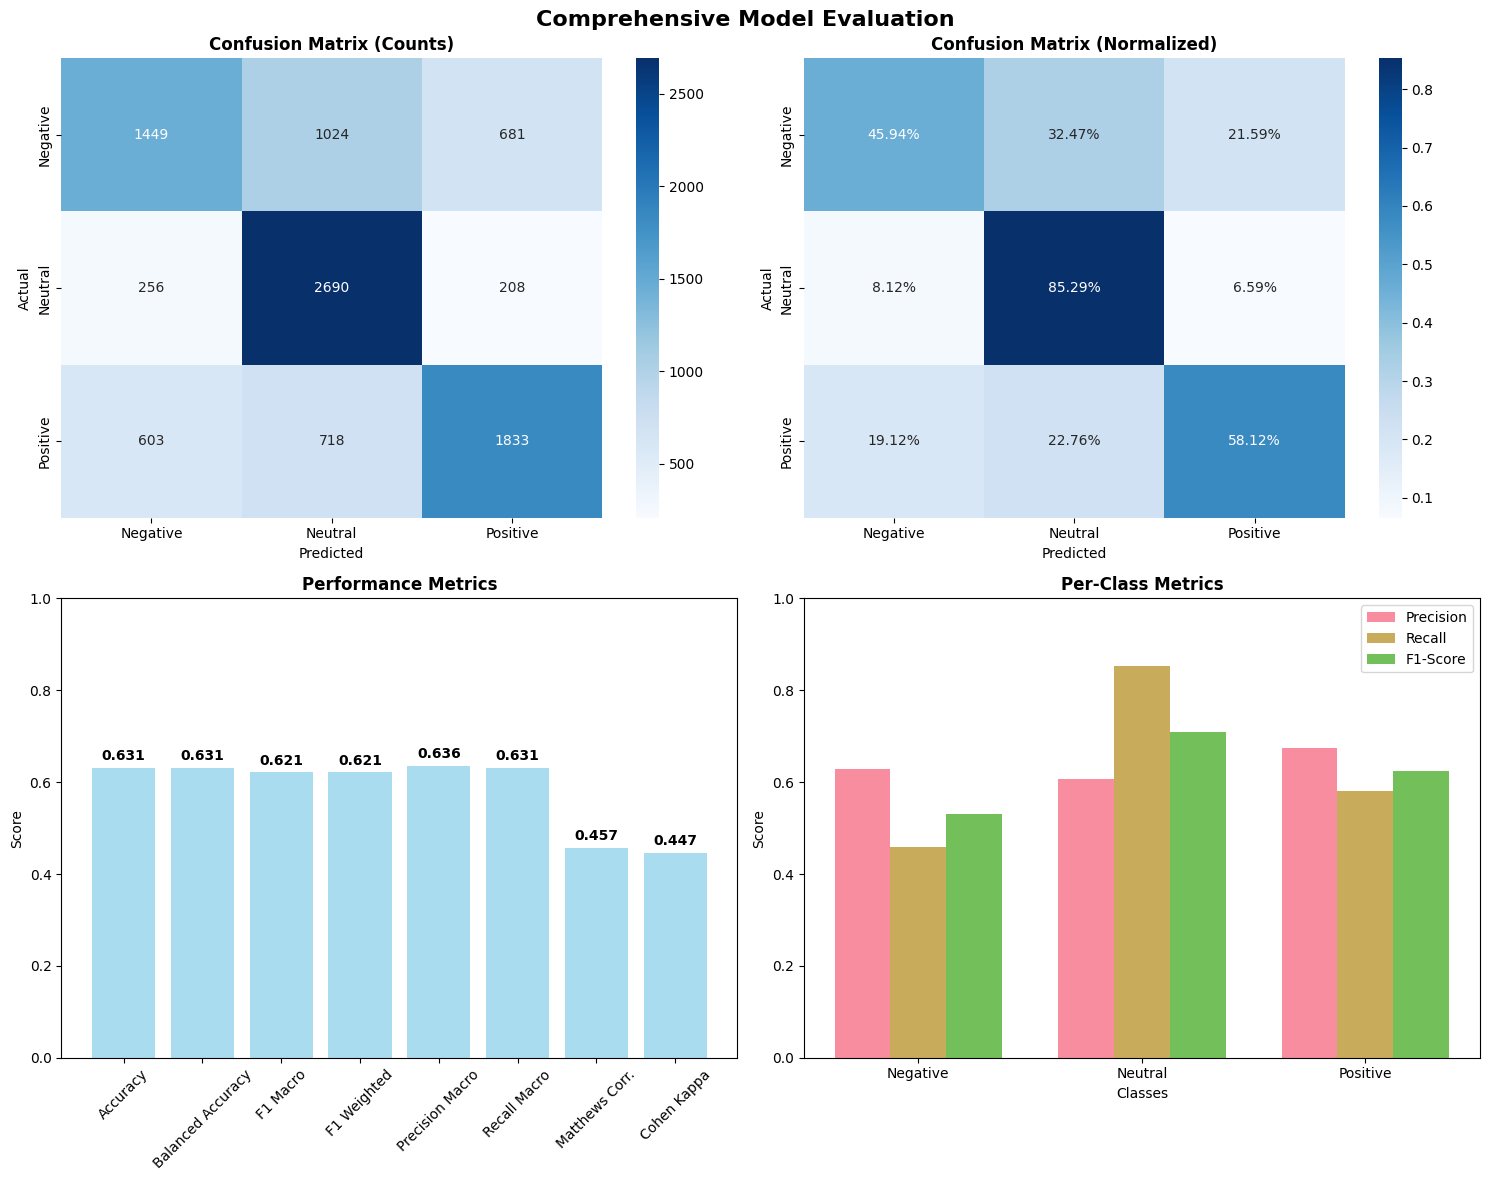

✓ Experiment completed successfully
  Accuracy: 0.6312
  Balanced Accuracy: 0.6312
  F1-Score (Macro): 0.6212

EXPERIMENT 23/30
Vectorizer: tfidf_trigram | Model: logistic_regression
Vectorizing text...
  Feature matrix shape: (37848, 20000)
Training model...
Evaluating model...


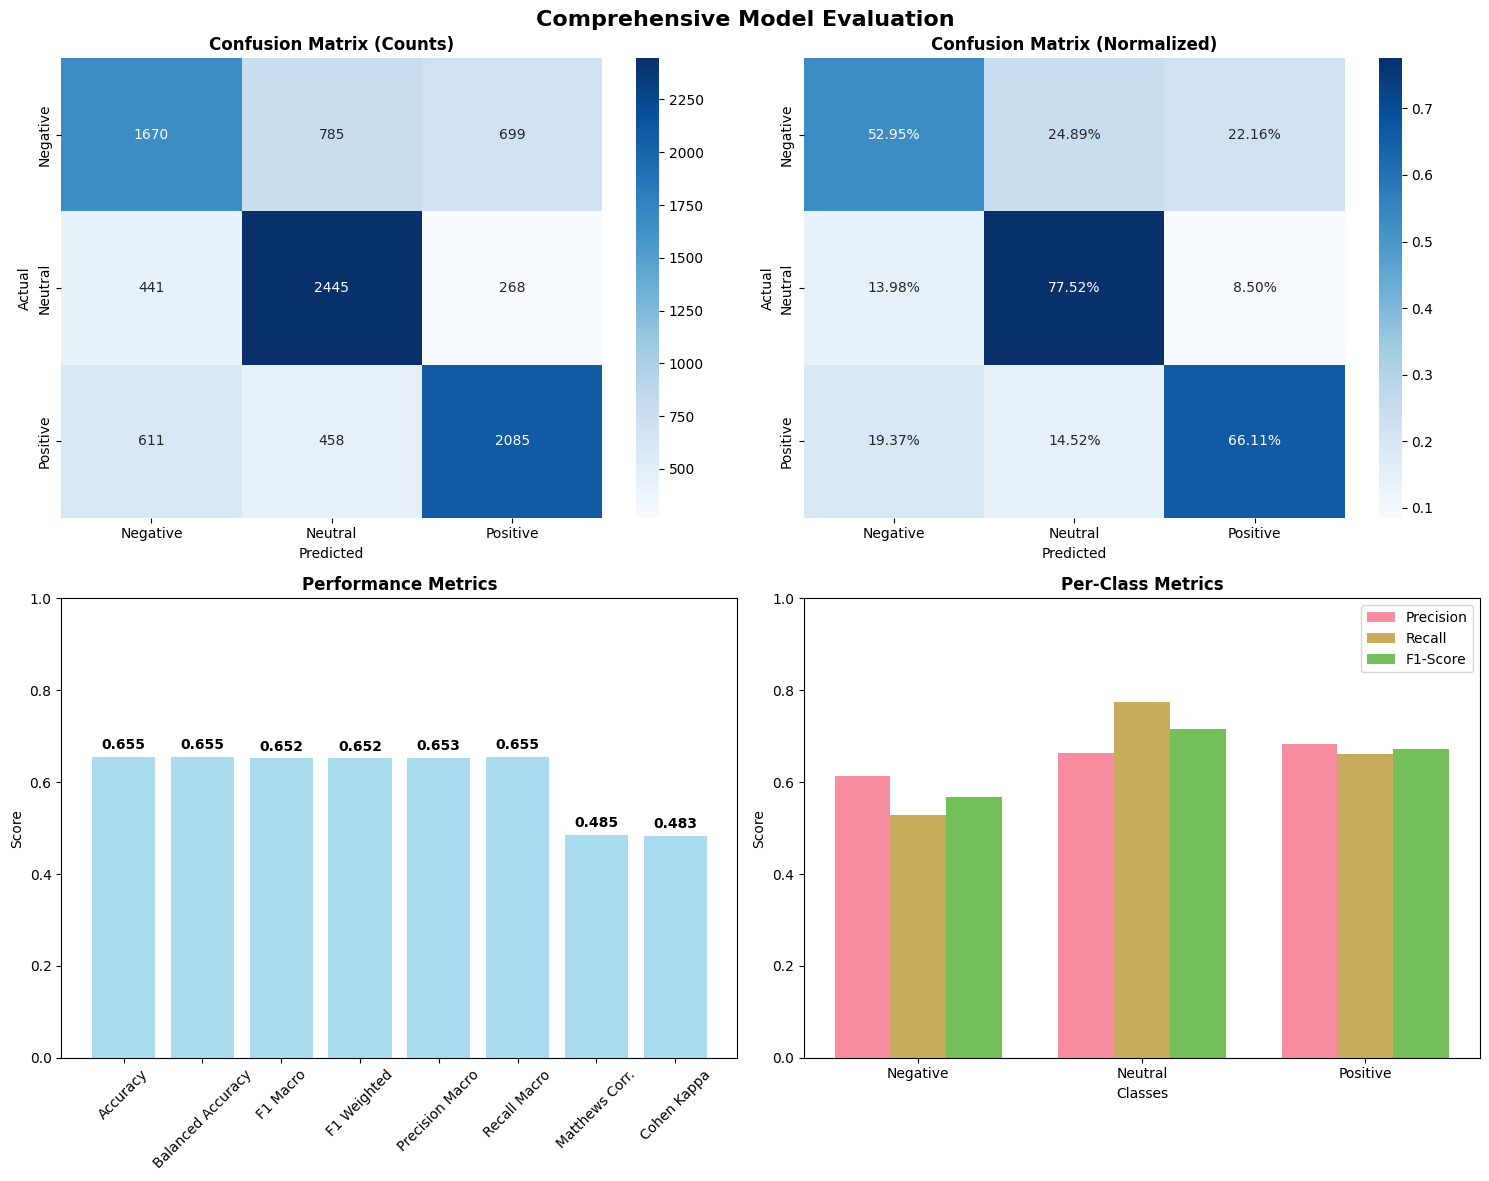

✓ Experiment completed successfully
  Accuracy: 0.6553
  Balanced Accuracy: 0.6553
  F1-Score (Macro): 0.6517

EXPERIMENT 24/30
Vectorizer: tfidf_trigram | Model: naive_bayes
Vectorizing text...
  Feature matrix shape: (37848, 20000)
Training model...
Evaluating model...


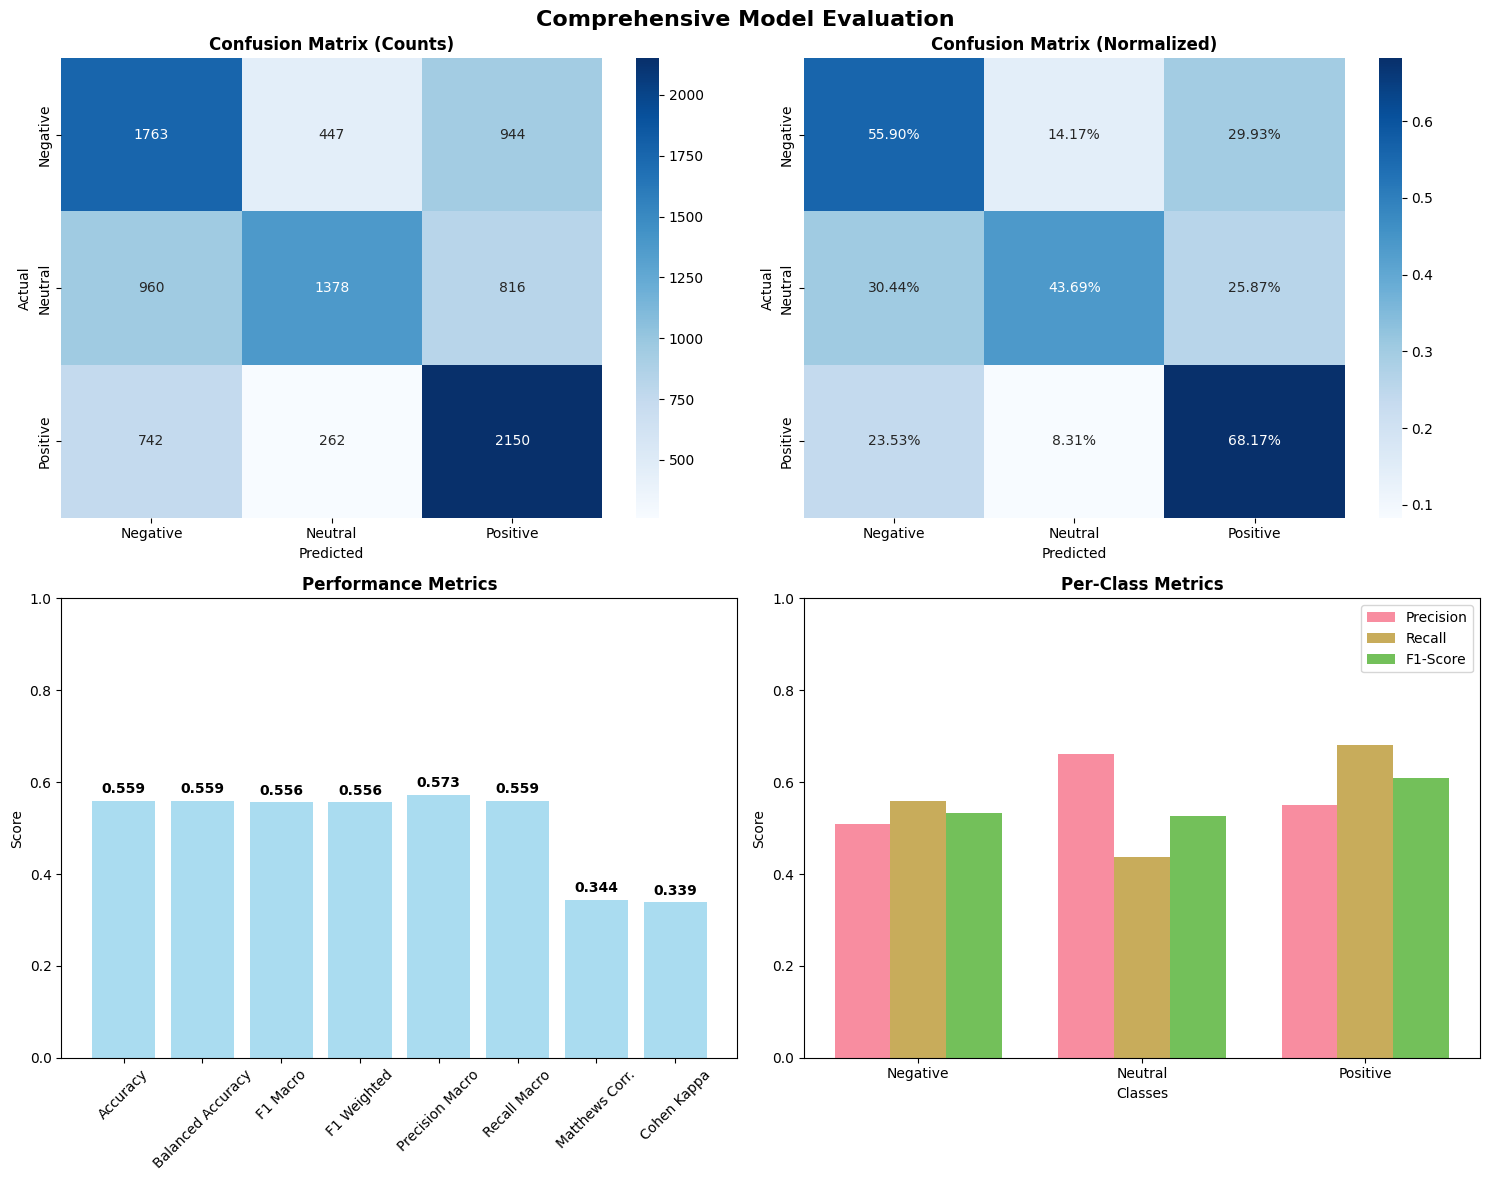

✓ Experiment completed successfully
  Accuracy: 0.5592
  Balanced Accuracy: 0.5592
  F1-Score (Macro): 0.5558

EXPERIMENT 25/30
Vectorizer: tfidf_trigram | Model: ensemble_voting
Vectorizing text...
  Feature matrix shape: (37848, 20000)
Training model...
Evaluating model...


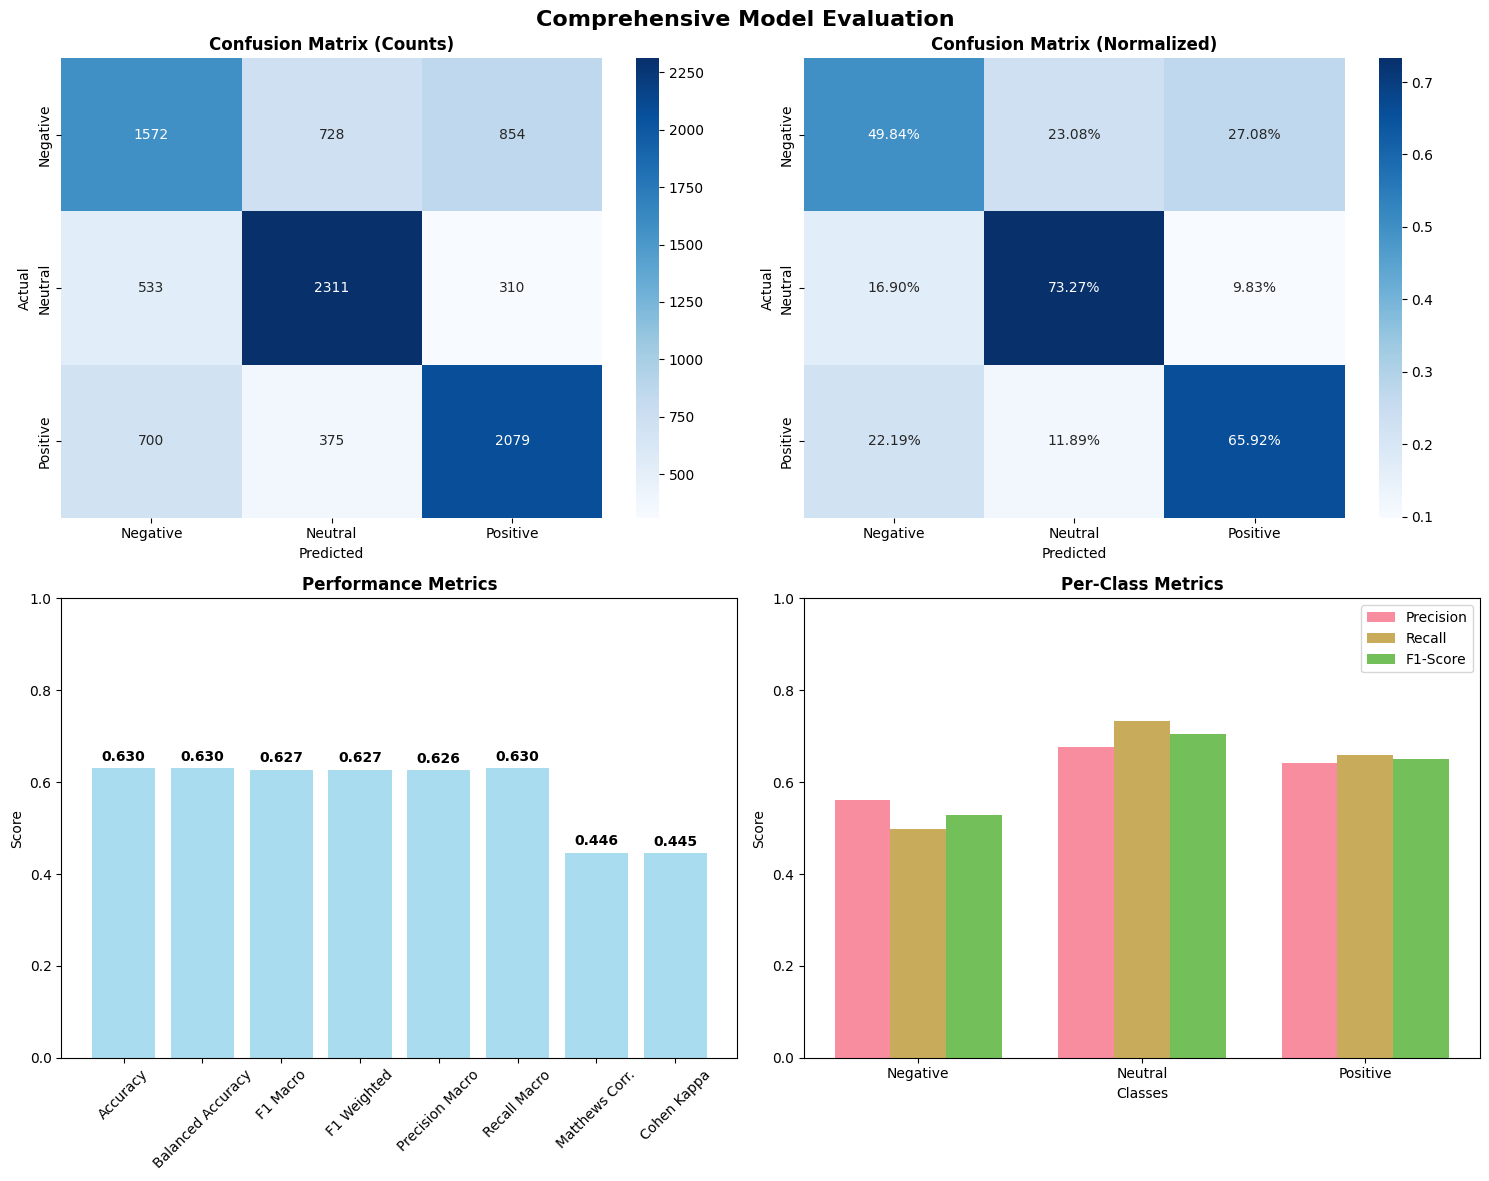

✓ Experiment completed successfully
  Accuracy: 0.6301
  Balanced Accuracy: 0.6301
  F1-Score (Macro): 0.6271

EXPERIMENT 26/30
Vectorizer: hashing | Model: random_forest
Vectorizing text...
  Feature matrix shape: (37848, 10000)
Training model...
Evaluating model...


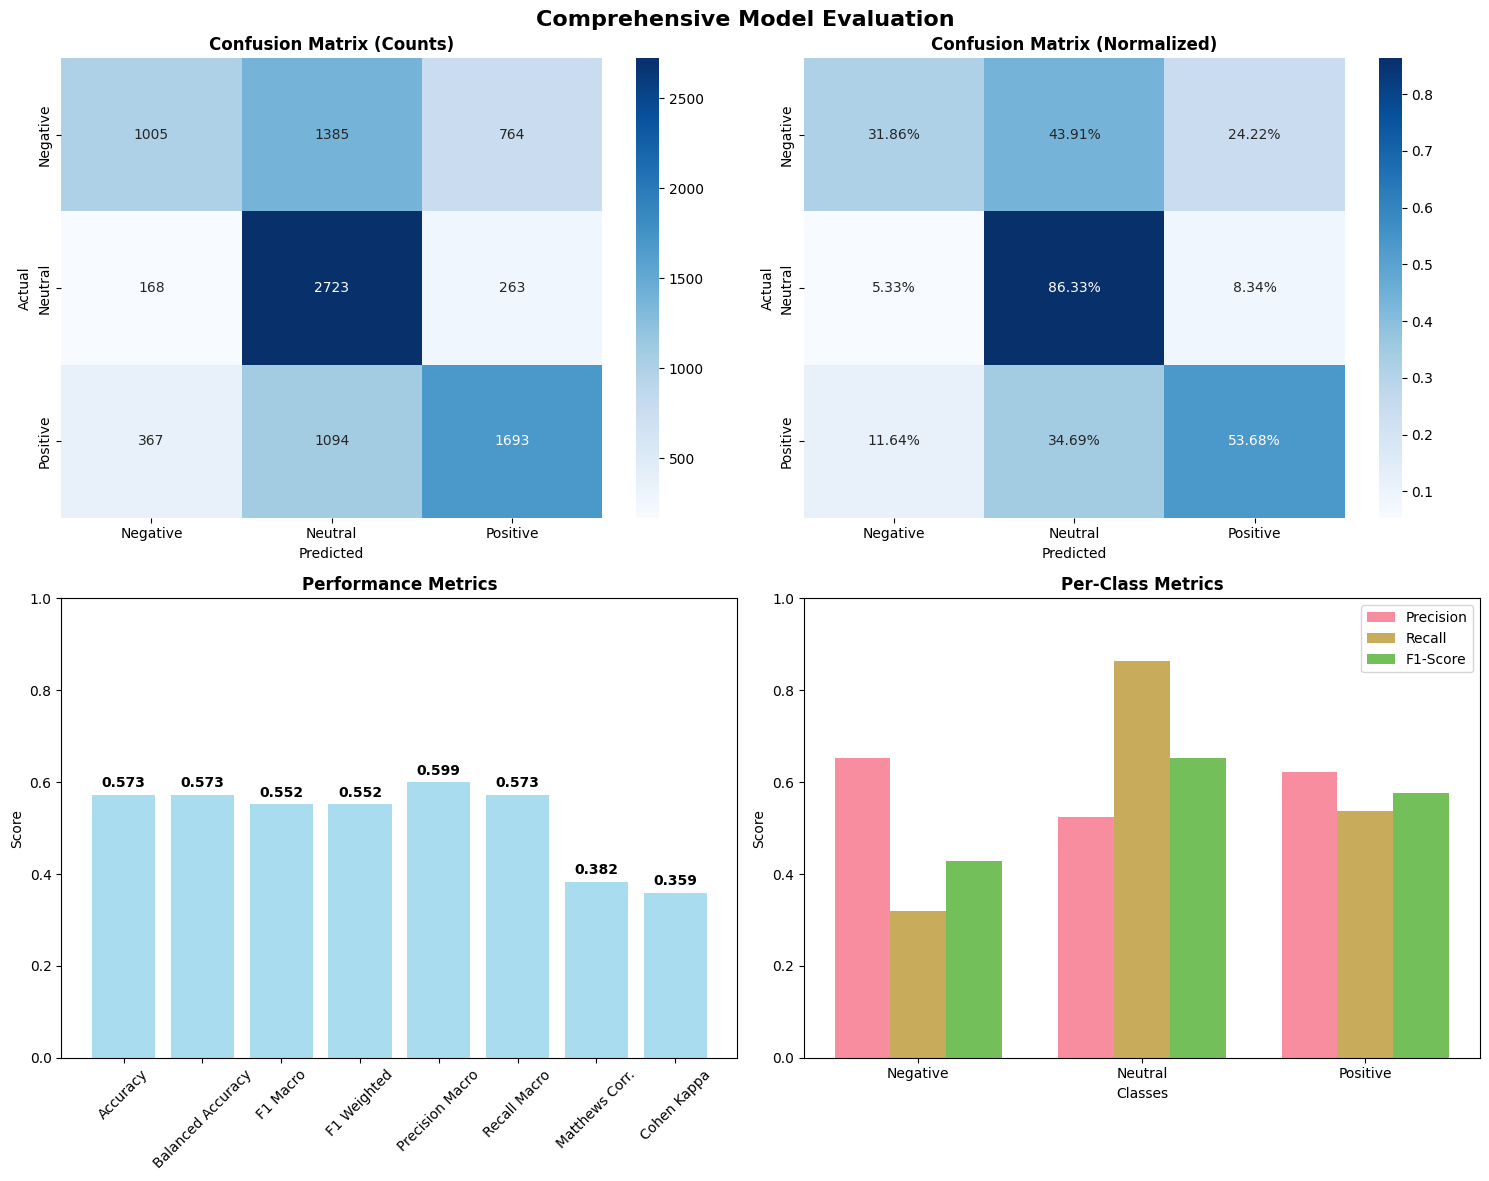

✓ Experiment completed successfully
  Accuracy: 0.5729
  Balanced Accuracy: 0.5729
  F1-Score (Macro): 0.5521

EXPERIMENT 27/30
Vectorizer: hashing | Model: gradient_boosting
Vectorizing text...
  Feature matrix shape: (37848, 10000)
Training model...
Evaluating model...


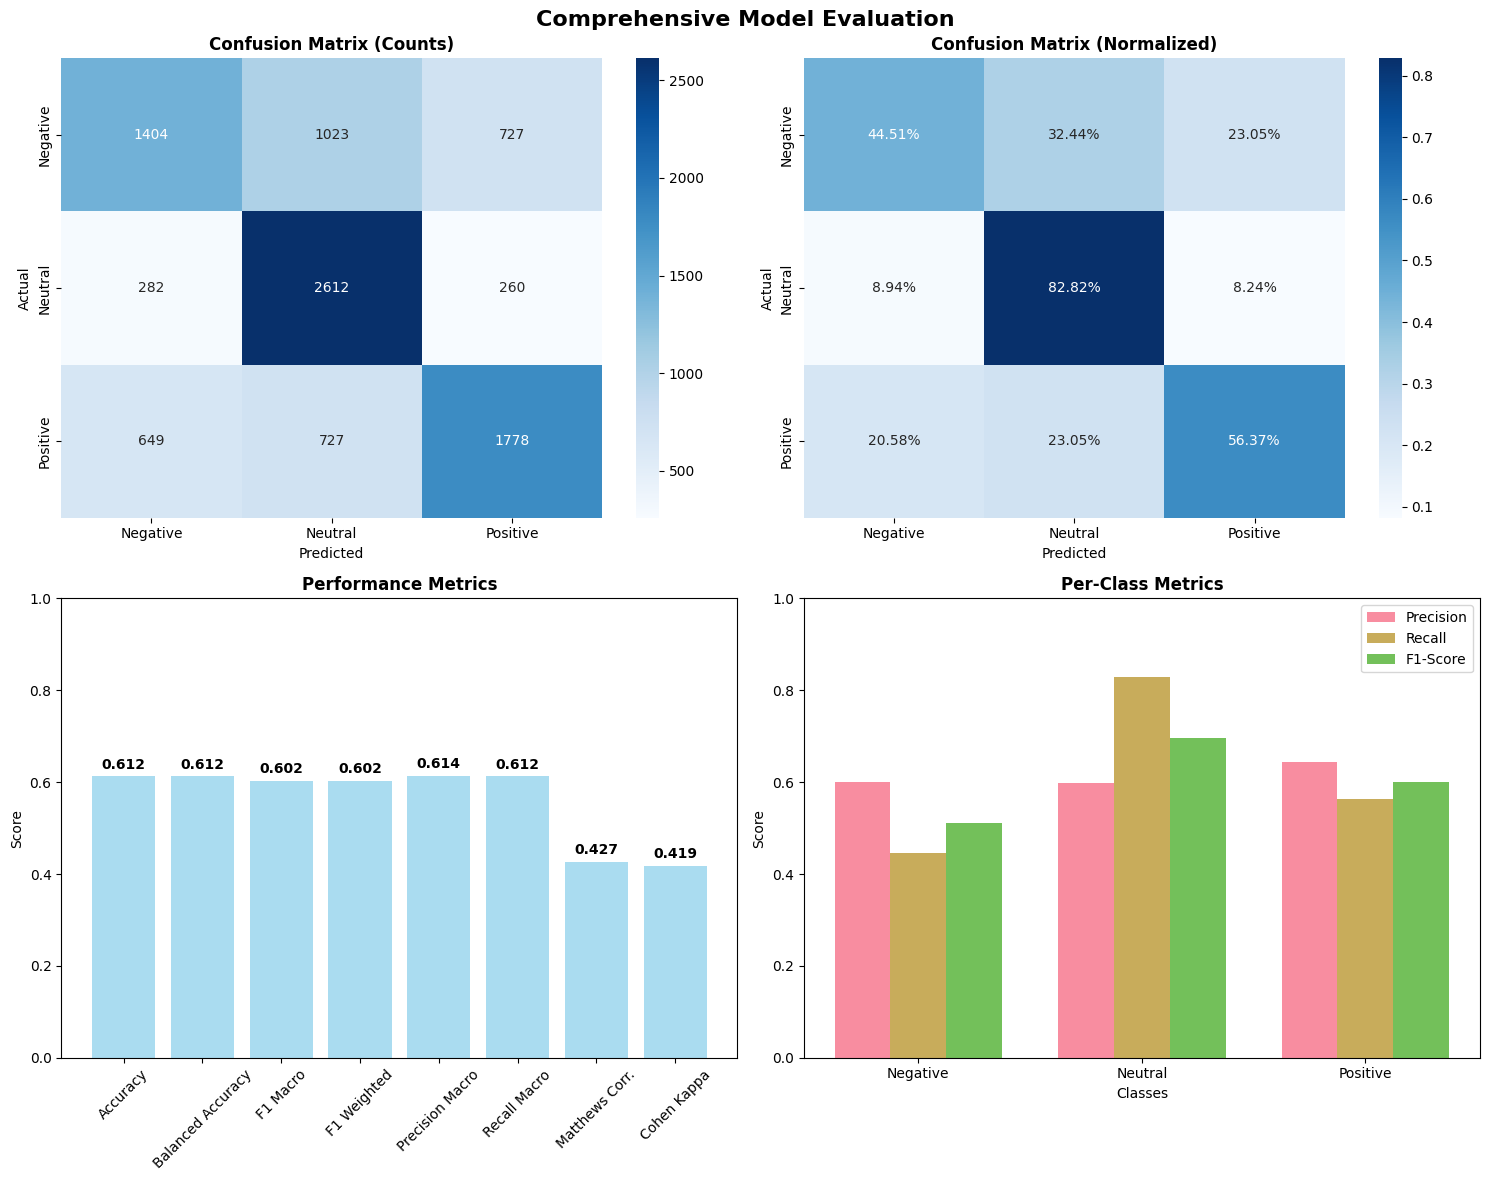

✓ Experiment completed successfully
  Accuracy: 0.6123
  Balanced Accuracy: 0.6123
  F1-Score (Macro): 0.6025

EXPERIMENT 28/30
Vectorizer: hashing | Model: logistic_regression
Vectorizing text...
  Feature matrix shape: (37848, 10000)
Training model...
Evaluating model...


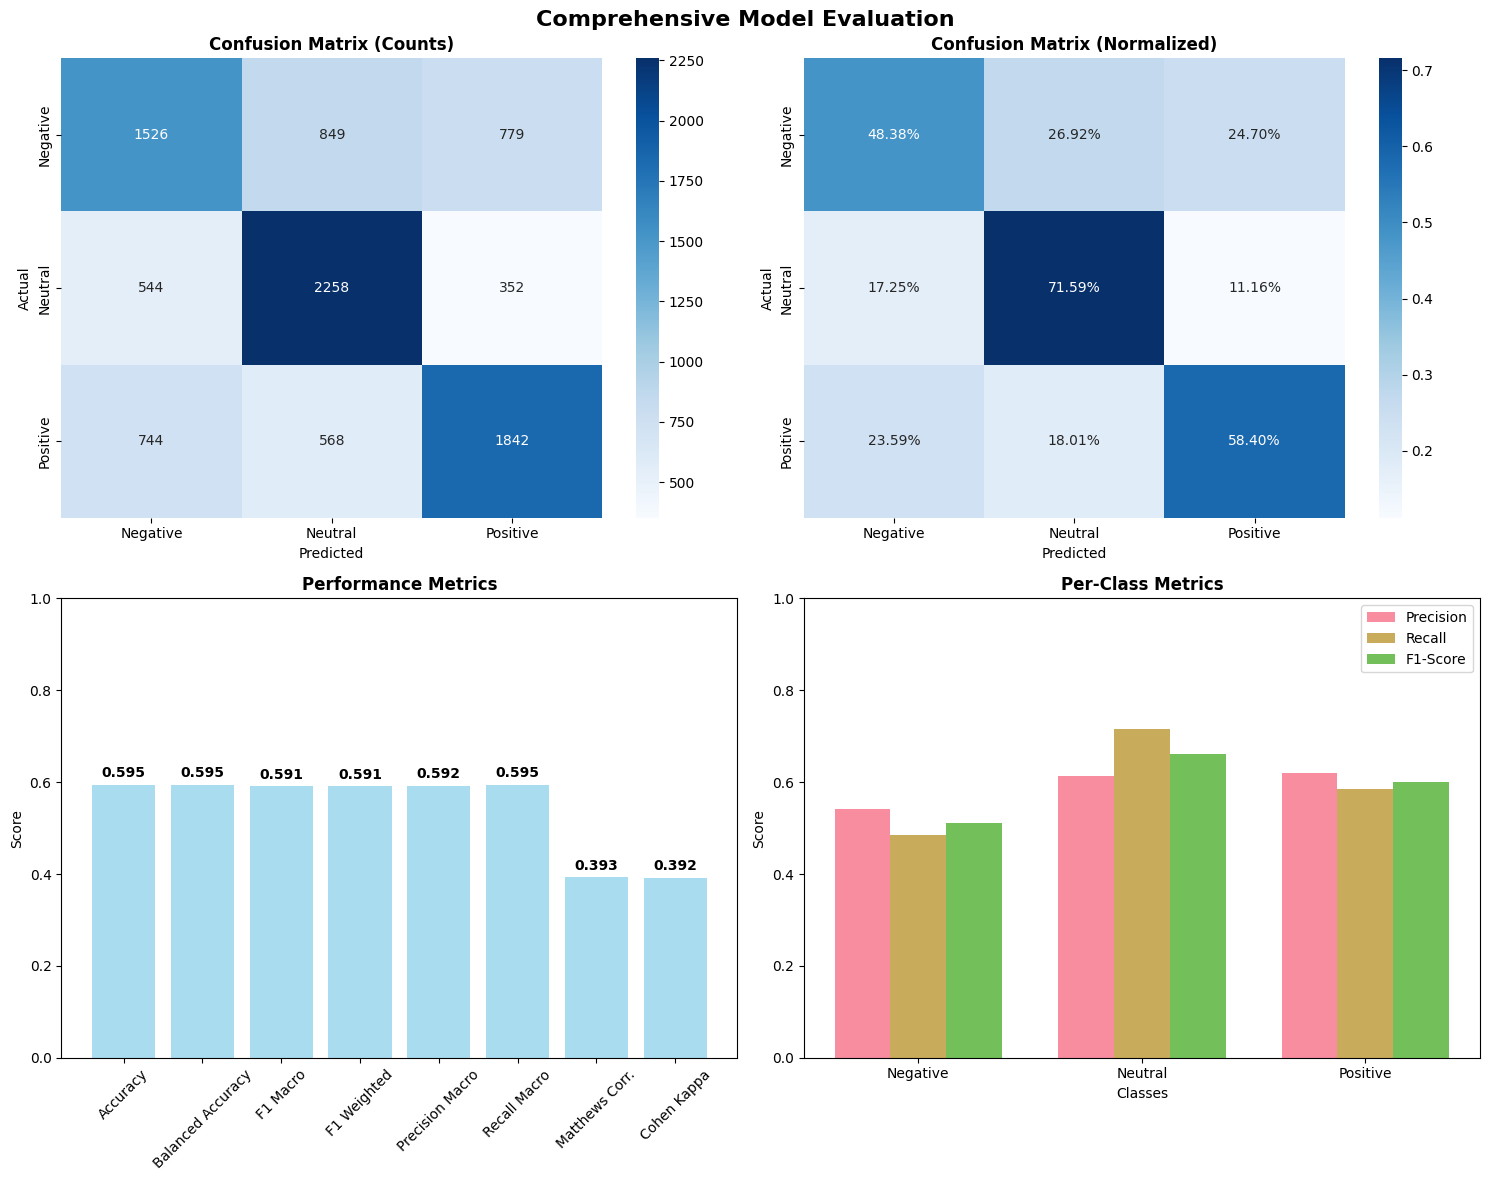

✓ Experiment completed successfully
  Accuracy: 0.5946
  Balanced Accuracy: 0.5946
  F1-Score (Macro): 0.5913

EXPERIMENT 29/30
Vectorizer: hashing | Model: naive_bayes
Vectorizing text...
  Feature matrix shape: (37848, 10000)
Training model...
✗ Experiment failed: Negative values in data passed to MultinomialNB (input X).

EXPERIMENT 30/30
Vectorizer: hashing | Model: ensemble_voting
Vectorizing text...
  Feature matrix shape: (37848, 10000)
Training model...
✗ Experiment failed: Negative values in data passed to MultinomialNB (input X).

ALL EXPERIMENTS COMPLETED
Successful experiments: 28/30


In [25]:
experiment_results = []
experiment_counter = 0

for vectorizer_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        experiment_counter += 1

        print(f"\n{'='*80}")
        print(f"EXPERIMENT {experiment_counter}/{total_experiments}")
        print(f"Vectorizer: {vectorizer_name} | Model: {model_name}")
        print(f"{'='*80}")

        with mlflow.start_run() as run:
            try:
                # Set run metadata
                run_name = f"{vectorizer_name}_{model_name}_{selected_method}"
                mlflow.set_tag("mlflow.runName", run_name)
                mlflow.set_tag("vectorizer", vectorizer_name)
                mlflow.set_tag("model", model_name)
                mlflow.set_tag("balancing_method", selected_method)

                # Log parameters
                mlflow.log_param("vectorizer_type", vectorizer_name)
                mlflow.log_param("model_type", model_name)
                mlflow.log_param("balancing_method", selected_method)
                mlflow.log_param("train_size", len(X_train))
                mlflow.log_param("test_size", len(X_test))

                # Vectorize text
                print("Vectorizing text...")
                X_train_vec = vectorizer.fit_transform(X_train)
                X_test_vec = vectorizer.transform(X_test)

                print(f"  Feature matrix shape: {X_train_vec.shape}")
                mlflow.log_param("feature_matrix_shape", str(X_train_vec.shape))

                # Train model
                print("Training model...")
                model.fit(X_train_vec, y_train)

                # Evaluate model
                print("Evaluating model...")
                evaluation_results = comprehensive_evaluation(model, X_test_vec, y_test)

                # Log all metrics
                for metric_name, value in evaluation_results.items():
                    if isinstance(value, (int, float)) and not np.isnan(value):
                        mlflow.log_metric(metric_name, value)

                # Log per-class metrics
                class_report = evaluation_results['classification_report']
                class_labels = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}

                for class_key, metrics in class_report.items():
                    if isinstance(metrics, dict) and class_key not in ['accuracy', 'macro avg', 'weighted avg', 'micro avg']:
                        try:
                            class_num = int(class_key)
                            class_name = class_labels.get(class_num, f'class_{class_key}')
                            for metric_name, value in metrics.items():
                                mlflow.log_metric(f"{class_name}_{metric_name}", value)
                        except:
                            continue

                # Create and save comprehensive visualizations
                viz_fig = create_comprehensive_visualizations(evaluation_results)
                viz_filename = f"evaluation_{vectorizer_name}_{model_name}.png"
                viz_fig.savefig(viz_filename, dpi=300, bbox_inches='tight')
                mlflow.log_artifact(viz_filename)
                plt.show()

                # Save model and vectorizer
                model_filename = f"model_{vectorizer_name}_{model_name}.pkl"
                vectorizer_filename = f"vectorizer_{vectorizer_name}_{model_name}.pkl"

                joblib.dump(model, model_filename)
                joblib.dump(vectorizer, vectorizer_filename)

                mlflow.log_artifact(model_filename)
                mlflow.log_artifact(vectorizer_filename)

                # Store results
                result = {
                    'run_id': run.info.run_id,
                    'vectorizer': vectorizer_name,
                    'model': model_name,
                    'balancing_method': selected_method,
                    **{k: v for k, v in evaluation_results.items()
                       if isinstance(v, (int, float)) and not np.isnan(v)}
                }
                experiment_results.append(result)

                print(f"✓ Experiment completed successfully")
                print(f"  Accuracy: {evaluation_results['accuracy']:.4f}")
                print(f"  Balanced Accuracy: {evaluation_results['balanced_accuracy']:.4f}")
                print(f"  F1-Score (Macro): {evaluation_results['f1_macro']:.4f}")

            except Exception as e:
                print(f"✗ Experiment failed: {e}")
                continue

print(f"\n{'='*80}")
print(f"ALL EXPERIMENTS COMPLETED")
print(f"Successful experiments: {len(experiment_results)}/{total_experiments}")
print(f"{'='*80}")

## 6. Results Analysis and Comparison


Top 10 Configurations by Balanced Accuracy:
   vectorizer               model  accuracy  balanced_accuracy  f1_macro  matthews_corrcoef
tfidf_unigram logistic_regression  0.662334           0.662334  0.658533           0.495839
 tfidf_bigram logistic_regression  0.659374           0.659374  0.655636           0.491212
tfidf_trigram logistic_regression  0.655253           0.655253  0.651683           0.484841
tfidf_unigram     ensemble_voting  0.635489           0.635489  0.632520           0.453999
tfidf_unigram   gradient_boosting  0.631685           0.631685  0.621423           0.458045
 tfidf_bigram     ensemble_voting  0.631368           0.631368  0.628160           0.447882
tfidf_trigram   gradient_boosting  0.631156           0.631156  0.621223           0.456537
 tfidf_bigram   gradient_boosting  0.630522           0.630522  0.620523           0.455613
tfidf_trigram     ensemble_voting  0.630099           0.630099  0.627104           0.445887
  bow_unigram     ensemble_voting  

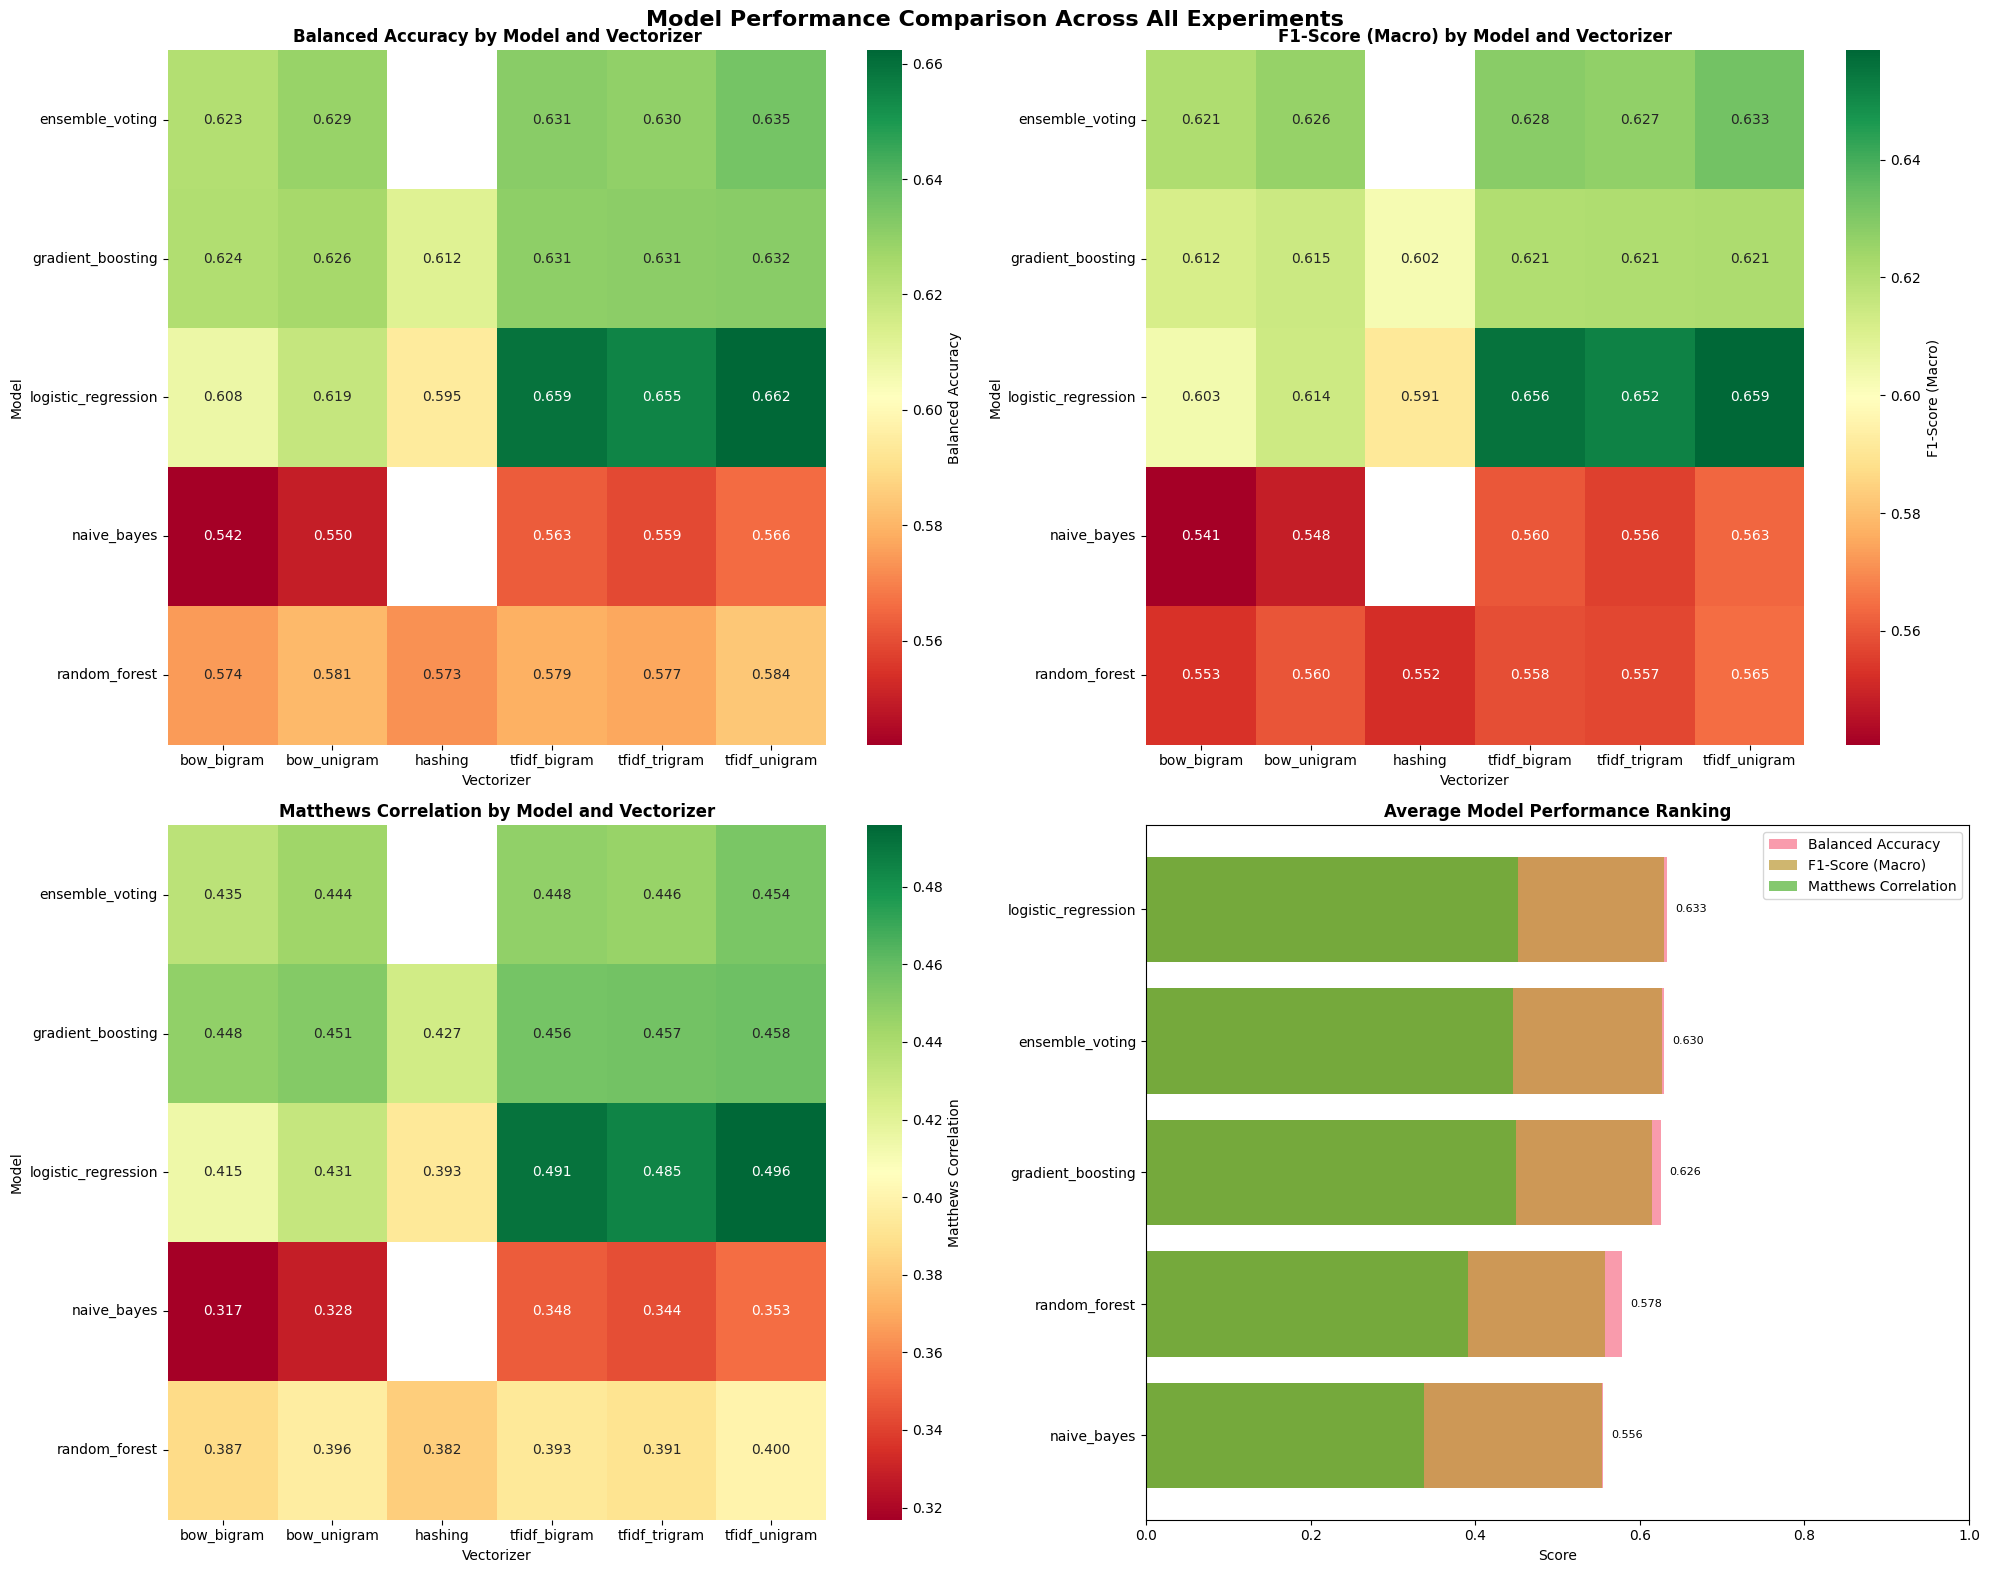


Vectorizer Performance Analysis:
              balanced_accuracy                 f1_macro                  \
                           mean     std     max     mean     std     max   
vectorizer                                                                 
bow_bigram               0.5942  0.0354  0.6235   0.5860  0.0365  0.6209   
bow_unigram              0.6009  0.0344  0.6288   0.5926  0.0358  0.6263   
hashing                  0.5933  0.0197  0.6123   0.5820  0.0264  0.6025   
tfidf_bigram             0.6126  0.0403  0.6594   0.6045  0.0434  0.6556   
tfidf_trigram            0.6105  0.0405  0.6553   0.6025  0.0437  0.6517   
tfidf_unigram            0.6159  0.0398  0.6623   0.6081  0.0425  0.6585   

              matthews_corrcoef                  
                           mean     std     max  
vectorizer                                       
bow_bigram               0.4003  0.0520  0.4480  
bow_unigram              0.4102  0.0504  0.4514  
hashing                  0.4008

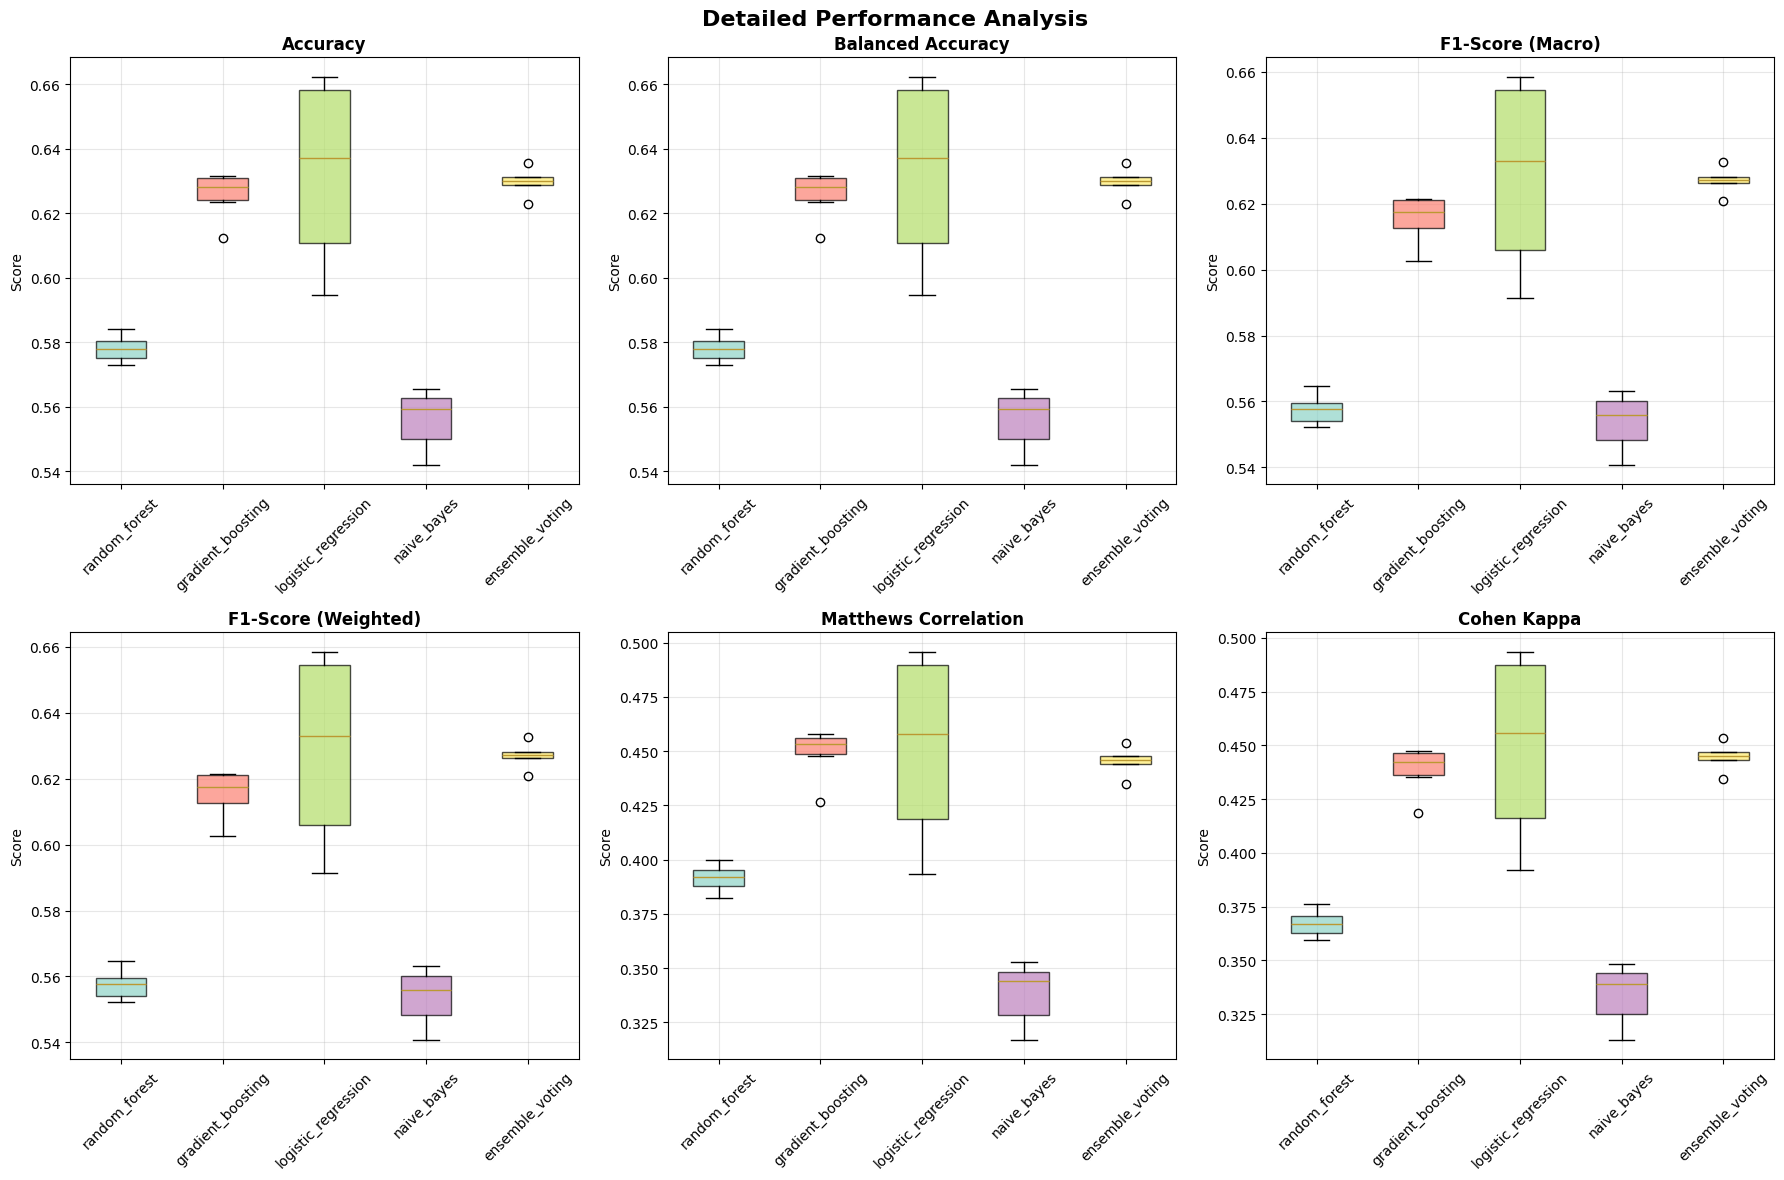


Feature Importance Analysis:
Analyzing feature importance for best Random Forest configuration:
  Vectorizer: tfidf_unigram
  Balanced Accuracy: 0.5841

Top 20 Most Important Features:
   1. good: 0.0277
   2. right: 0.0215
   3. great: 0.0198
   4. fuck: 0.0190
   5. people: 0.0170
   6. really: 0.0166
   7. like: 0.0155
   8. shit: 0.0152
   9. bad: 0.0150
  10. love: 0.0144
  11. lol: 0.0142
  12. best: 0.0137
  13. better: 0.0135
  14. hate: 0.0131
  15. bjp: 0.0129
  16. india: 0.0113
  17. new: 0.0113
  18. idiot: 0.0110
  19. ppr: 0.0105
  20. country: 0.0104


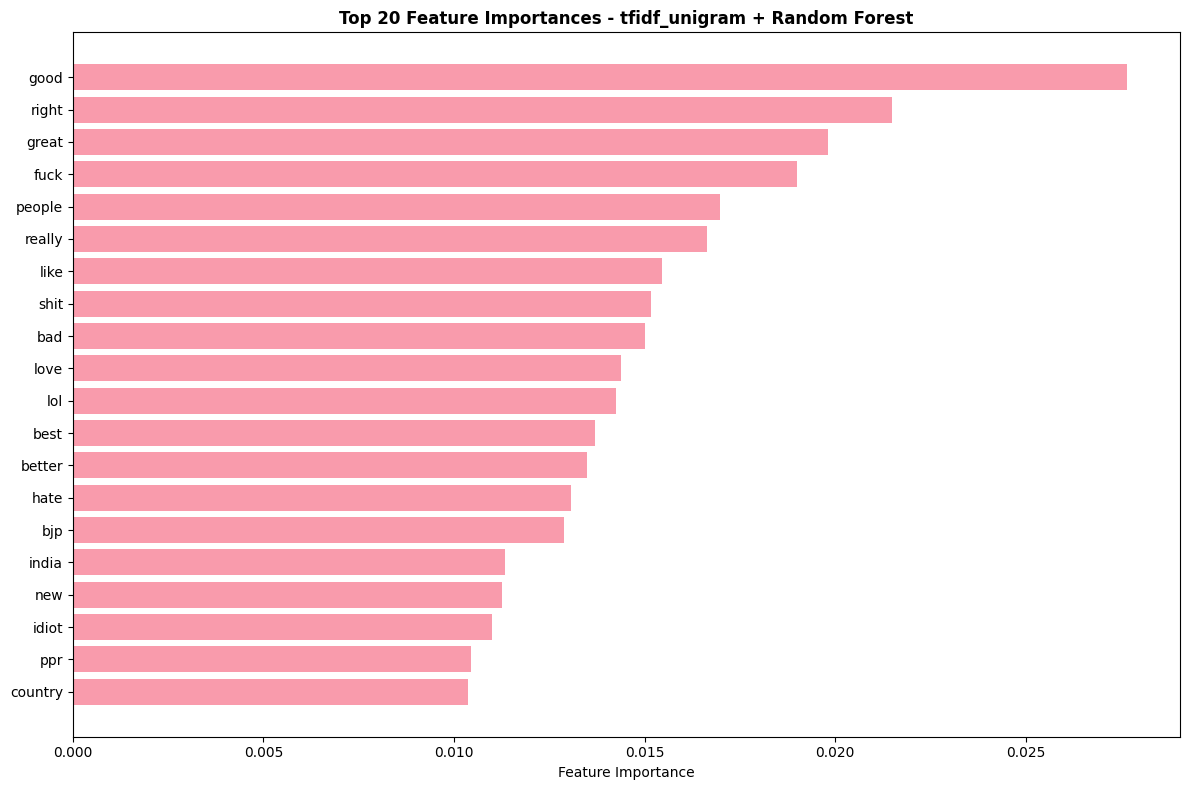


Cross-Validation Analysis for Best Configuration:
Configuration: tfidf_unigram + logistic_regression
5-Fold Cross-Validation Results:
  Accuracy: 0.6555 (±0.0128)
  Balanced Accuracy: 0.6555 (±0.0128)
  F1-Score (Macro): 0.6519 (±0.0129)


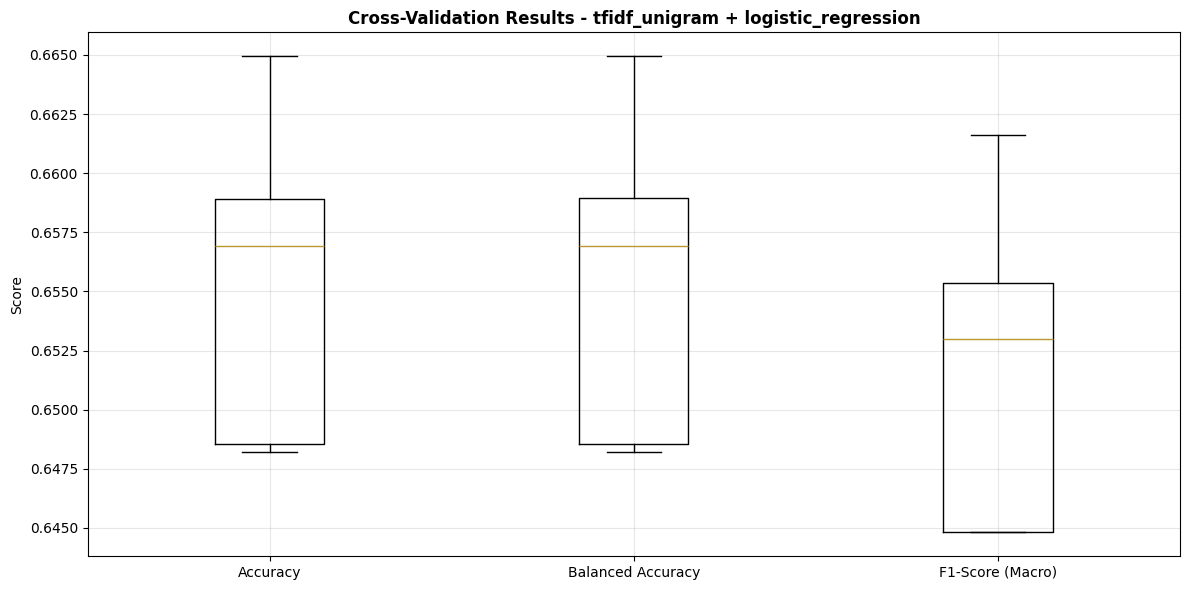


Learning Curve Analysis:


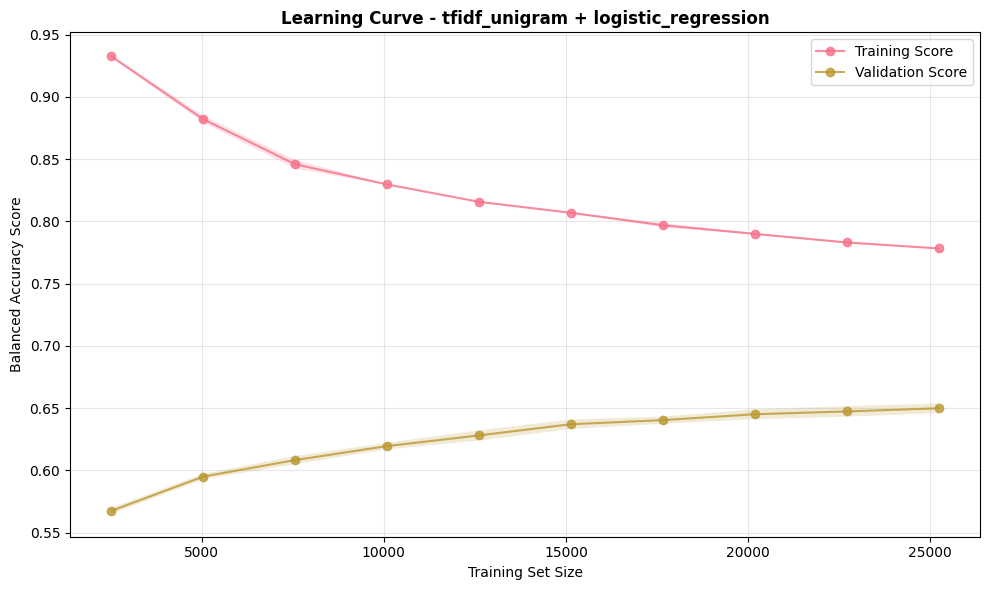

Learning curve analysis completed.
  Final training score: 0.7783 (±0.0004)
  Final validation score: 0.6499 (±0.0039)

EXPERIMENT ANALYSIS COMPLETED
✓ All results saved to MLflow
✓ Best configuration identified and analyzed
✓ Comprehensive visualizations created
✓ Statistical analysis completed

FINAL RECOMMENDATIONS AND SUMMARY

BEST PERFORMING CONFIGURATION:
   Vectorization: tfidf_unigram
   Model: logistic_regression
   Class Balancing: smote
   Balanced Accuracy: 0.6623
   F1-Score (Macro): 0.6585
   Matthews Correlation: 0.4958

KEY INSIGHTS:
   • Best vectorization method: tfidf_unigram (avg: 0.6159)
   • Worst vectorization method: hashing (avg: 0.5933)
   • Best model type: logistic_regression (avg: 0.6331)
   • Worst model type: naive_bayes (avg: 0.5559)
   • Class balancing method used: smote
   • Original imbalance ratio: 1.91:1

RECOMMENDATIONS:
   1. Use tfidf_unigram for text vectorization
   2. Use logistic_regression as the classification model
   3. Apply smote for c

In [26]:
if experiment_results:
    # Convert to DataFrame
    results_df = pd.DataFrame(experiment_results)

    # Save detailed results
    results_df.to_csv("enhanced_experiment_results.csv", index=False)

    print("\nTop 10 Configurations by Balanced Accuracy:")
    top_results = results_df.nlargest(10, 'balanced_accuracy')[
        ['vectorizer', 'model', 'accuracy', 'balanced_accuracy', 'f1_macro', 'matthews_corrcoef']
    ]
    print(top_results.to_string(index=False))

    # Best configuration
    best_idx = results_df['balanced_accuracy'].idxmax()
    best_config = results_df.loc[best_idx]

    print(f"\nBest Overall Configuration:")
    print(f"  Vectorizer: {best_config['vectorizer']}")
    print(f"  Model: {best_config['model']}")
    print(f"  Balancing: {best_config['balancing_method']}")
    print(f"  Accuracy: {best_config['accuracy']:.4f}")
    print(f"  Balanced Accuracy: {best_config['balanced_accuracy']:.4f}")
    print(f"  F1-Score (Macro): {best_config['f1_macro']:.4f}")
    print(f"  Matthews Correlation: {best_config['matthews_corrcoef']:.4f}")

    # Create comprehensive comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Model Performance Comparison Across All Experiments', fontsize=16, fontweight='bold')

    # 1. Heatmap of Balanced Accuracy
    pivot_balanced_acc = results_df.pivot_table(
        values='balanced_accuracy',
        index='model',
        columns='vectorizer',
        aggfunc='mean'
    )

    sns.heatmap(pivot_balanced_acc, annot=True, fmt='.3f', cmap='RdYlGn',
                cbar_kws={'label': 'Balanced Accuracy'}, ax=axes[0,0])
    axes[0,0].set_title('Balanced Accuracy by Model and Vectorizer', fontweight='bold')
    axes[0,0].set_xlabel('Vectorizer')
    axes[0,0].set_ylabel('Model')

    # 2. F1-Score Macro Heatmap
    pivot_f1_macro = results_df.pivot_table(
        values='f1_macro',
        index='model',
        columns='vectorizer',
        aggfunc='mean'
    )

    sns.heatmap(pivot_f1_macro, annot=True, fmt='.3f', cmap='RdYlGn',
                cbar_kws={'label': 'F1-Score (Macro)'}, ax=axes[0,1])
    axes[0,1].set_title('F1-Score (Macro) by Model and Vectorizer', fontweight='bold')
    axes[0,1].set_xlabel('Vectorizer')
    axes[0,1].set_ylabel('Model')

    # 3. Matthews Correlation Coefficient
    pivot_mcc = results_df.pivot_table(
        values='matthews_corrcoef',
        index='model',
        columns='vectorizer',
        aggfunc='mean'
    )

    sns.heatmap(pivot_mcc, annot=True, fmt='.3f', cmap='RdYlGn',
                cbar_kws={'label': 'Matthews Correlation'}, ax=axes[1,0])
    axes[1,0].set_title('Matthews Correlation by Model and Vectorizer', fontweight='bold')
    axes[1,0].set_xlabel('Vectorizer')
    axes[1,0].set_ylabel('Model')

    # 4. Model Performance Ranking
    model_performance = results_df.groupby('model').agg({
        'balanced_accuracy': 'mean',
        'f1_macro': 'mean',
        'matthews_corrcoef': 'mean'
    }).sort_values('balanced_accuracy', ascending=True)

    y_pos = np.arange(len(model_performance))
    axes[1,1].barh(y_pos, model_performance['balanced_accuracy'], alpha=0.7, label='Balanced Accuracy')
    axes[1,1].barh(y_pos, model_performance['f1_macro'], alpha=0.7, label='F1-Score (Macro)')
    axes[1,1].barh(y_pos, model_performance['matthews_corrcoef'], alpha=0.7, label='Matthews Correlation')

    axes[1,1].set_yticks(y_pos)
    axes[1,1].set_yticklabels(model_performance.index)
    axes[1,1].set_xlabel('Score')
    axes[1,1].set_title('Average Model Performance Ranking', fontweight='bold')
    axes[1,1].legend()
    axes[1,1].set_xlim(0, 1)

    # Add value labels
    for i, (idx, row) in enumerate(model_performance.iterrows()):
        axes[1,1].text(row['balanced_accuracy'] + 0.01, i, f'{row["balanced_accuracy"]:.3f}',
                      va='center', fontsize=8)

    plt.tight_layout()
    plt.savefig("comprehensive_model_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Vectorizer performance analysis
    print("\nVectorizer Performance Analysis:")
    vectorizer_performance = results_df.groupby('vectorizer').agg({
        'balanced_accuracy': ['mean', 'std', 'max'],
        'f1_macro': ['mean', 'std', 'max'],
        'matthews_corrcoef': ['mean', 'std', 'max']
    }).round(4)

    print(vectorizer_performance)

    # Model performance analysis
    print("\nModel Performance Analysis:")
    model_performance_stats = results_df.groupby('model').agg({
        'balanced_accuracy': ['mean', 'std', 'max'],
        'f1_macro': ['mean', 'std', 'max'],
        'matthews_corrcoef': ['mean', 'std', 'max']
    }).round(4)

    print(model_performance_stats)

    # Statistical significance testing
    print("\nStatistical Analysis:")
    from scipy import stats

    # Compare best vectorizer vs others
    best_vectorizer = results_df.groupby('vectorizer')['balanced_accuracy'].mean().idxmax()
    best_vec_scores = results_df[results_df['vectorizer'] == best_vectorizer]['balanced_accuracy']

    print(f"\nBest performing vectorizer: {best_vectorizer}")
    print(f"Average balanced accuracy: {best_vec_scores.mean():.4f} (±{best_vec_scores.std():.4f})")

    # Compare best model vs others
    best_model = results_df.groupby('model')['balanced_accuracy'].mean().idxmax()
    best_model_scores = results_df[results_df['model'] == best_model]['balanced_accuracy']

    print(f"\nBest performing model: {best_model}")
    print(f"Average balanced accuracy: {best_model_scores.mean():.4f} (±{best_model_scores.std():.4f})")

    # Create detailed performance plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Detailed Performance Analysis', fontsize=16, fontweight='bold')

    # Box plots for different metrics
    metrics = ['accuracy', 'balanced_accuracy', 'f1_macro', 'f1_weighted', 'matthews_corrcoef', 'cohen_kappa']
    metric_titles = ['Accuracy', 'Balanced Accuracy', 'F1-Score (Macro)',
                    'F1-Score (Weighted)', 'Matthews Correlation', 'Cohen Kappa']

    for idx, (metric, title) in enumerate(zip(metrics, metric_titles)):
        if metric in results_df.columns:
            row = idx // 3
            col = idx % 3

            # Create box plot by model
            model_data = [results_df[results_df['model'] == model][metric].values
                         for model in results_df['model'].unique()]

            bp = axes[row, col].boxplot(model_data, labels=results_df['model'].unique(),
                                       patch_artist=True)

            # Color the boxes
            colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)

            axes[row, col].set_title(title, fontweight='bold')
            axes[row, col].set_ylabel('Score')
            axes[row, col].tick_params(axis='x', rotation=45)
            axes[row, col].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("detailed_performance_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Feature importance analysis (for tree-based models)
    print("\nFeature Importance Analysis:")

    # Get the best performing Random Forest model
    rf_results = results_df[results_df['model'] == 'random_forest']
    if not rf_results.empty:
        best_rf_idx = rf_results['balanced_accuracy'].idxmax()
        best_rf_config = rf_results.loc[best_rf_idx]

        print(f"Analyzing feature importance for best Random Forest configuration:")
        print(f"  Vectorizer: {best_rf_config['vectorizer']}")
        print(f"  Balanced Accuracy: {best_rf_config['balanced_accuracy']:.4f}")

        # Load the corresponding model and vectorizer
        try:
            rf_model = joblib.load(f"model_{best_rf_config['vectorizer']}_random_forest.pkl")
            rf_vectorizer = joblib.load(f"vectorizer_{best_rf_config['vectorizer']}_random_forest.pkl")

            if hasattr(rf_model, 'feature_importances_'):
                # Get feature names
                if hasattr(rf_vectorizer, 'get_feature_names_out'):
                    feature_names = rf_vectorizer.get_feature_names_out()
                else:
                    feature_names = rf_vectorizer.get_feature_names()

                # Get top features
                importance_scores = rf_model.feature_importances_
                top_indices = np.argsort(importance_scores)[-20:][::-1]  # Top 20 features

                top_features = [(feature_names[i], importance_scores[i]) for i in top_indices]

                print(f"\nTop 20 Most Important Features:")
                for i, (feature, importance) in enumerate(top_features, 1):
                    print(f"  {i:2d}. {feature}: {importance:.4f}")

                # Visualize feature importance
                plt.figure(figsize=(12, 8))
                features, importances = zip(*top_features)

                plt.barh(range(len(features)), importances, alpha=0.7)
                plt.yticks(range(len(features)), features)
                plt.xlabel('Feature Importance')
                plt.title(f'Top 20 Feature Importances - {best_rf_config["vectorizer"]} + Random Forest',
                         fontweight='bold')
                plt.gca().invert_yaxis()
                plt.tight_layout()
                plt.savefig("feature_importance_analysis.png", dpi=300, bbox_inches='tight')
                plt.show()

        except Exception as e:
            print(f"Could not load model for feature importance analysis: {e}")

    # Cross-validation analysis for best configuration
    print(f"\nCross-Validation Analysis for Best Configuration:")
    print(f"Configuration: {best_config['vectorizer']} + {best_config['model']}")

    try:
        # Recreate best vectorizer and model
        best_vectorizer_obj = vectorizers[best_config['vectorizer']]
        best_model_obj = models[best_config['model']]

        # Vectorize the balanced training data
        X_train_vec_cv = best_vectorizer_obj.fit_transform(X_train)

        # Perform cross-validation
        cv_scores_accuracy = cross_val_score(best_model_obj, X_train_vec_cv, y_train,
                                           cv=5, scoring='accuracy')
        cv_scores_balanced = cross_val_score(best_model_obj, X_train_vec_cv, y_train,
                                           cv=5, scoring='balanced_accuracy')
        cv_scores_f1_macro = cross_val_score(best_model_obj, X_train_vec_cv, y_train,
                                           cv=5, scoring='f1_macro')

        print(f"5-Fold Cross-Validation Results:")
        print(f"  Accuracy: {cv_scores_accuracy.mean():.4f} (±{cv_scores_accuracy.std()*2:.4f})")
        print(f"  Balanced Accuracy: {cv_scores_balanced.mean():.4f} (±{cv_scores_balanced.std()*2:.4f})")
        print(f"  F1-Score (Macro): {cv_scores_f1_macro.mean():.4f} (±{cv_scores_f1_macro.std()*2:.4f})")

        # Plot CV results
        plt.figure(figsize=(12, 6))

        cv_results = {
            'Accuracy': cv_scores_accuracy,
            'Balanced Accuracy': cv_scores_balanced,
            'F1-Score (Macro)': cv_scores_f1_macro
        }

        positions = range(1, len(cv_results) + 1)
        plt.boxplot(cv_results.values(), positions=positions, labels=cv_results.keys())
        plt.title(f'Cross-Validation Results - {best_config["vectorizer"]} + {best_config["model"]}',
                 fontweight='bold')
        plt.ylabel('Score')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig("cross_validation_analysis.png", dpi=300, bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(f"Could not perform cross-validation analysis: {e}")

    # Learning curve analysis
    print(f"\nLearning Curve Analysis:")

    try:
        from sklearn.model_selection import learning_curve

        # Generate learning curve for best configuration
        train_sizes = np.linspace(0.1, 1.0, 10)
        train_sizes_abs, train_scores, val_scores = learning_curve(
            best_model_obj, X_train_vec_cv, y_train,
            train_sizes=train_sizes, cv=3, scoring='balanced_accuracy',
            n_jobs=-1, random_state=42
        )

        # Calculate mean and std
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        # Plot learning curve
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes_abs, train_mean, 'o-', label='Training Score', alpha=0.8)
        plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2)

        plt.plot(train_sizes_abs, val_mean, 'o-', label='Validation Score', alpha=0.8)
        plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2)

        plt.xlabel('Training Set Size')
        plt.ylabel('Balanced Accuracy Score')
        plt.title(f'Learning Curve - {best_config["vectorizer"]} + {best_config["model"]}',
                 fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig("learning_curve_analysis.png", dpi=300, bbox_inches='tight')
        plt.show()

        print(f"Learning curve analysis completed.")
        print(f"  Final training score: {train_mean[-1]:.4f} (±{train_std[-1]:.4f})")
        print(f"  Final validation score: {val_mean[-1]:.4f} (±{val_std[-1]:.4f})")

    except Exception as e:
        print(f"Could not perform learning curve analysis: {e}")

    # Save all artifacts to MLflow
    with mlflow.start_run() as summary_run:
        mlflow.set_tag("mlflow.runName", "Experiment_Summary")
        mlflow.set_tag("experiment_type", "summary")

        # Log summary metrics
        mlflow.log_metric("best_balanced_accuracy", best_config['balanced_accuracy'])
        mlflow.log_metric("best_f1_macro", best_config['f1_macro'])
        mlflow.log_metric("best_matthews_corrcoef", best_config['matthews_corrcoef'])

        # Log configuration
        mlflow.log_param("best_vectorizer", best_config['vectorizer'])
        mlflow.log_param("best_model", best_config['model'])
        mlflow.log_param("balancing_method", best_config['balancing_method'])
        mlflow.log_param("total_experiments", total_experiments)
        mlflow.log_param("successful_experiments", len(experiment_results))

        # Log all artifacts
        artifacts_to_log = [
            "enhanced_experiment_results.csv",
            "comprehensive_model_comparison.png",
            "detailed_performance_analysis.png",
            "cross_validation_analysis.png",
            "learning_curve_analysis.png"
        ]

        for artifact in artifacts_to_log:
            try:
                mlflow.log_artifact(artifact)
            except:
                pass

    print(f"\n{'='*80}")
    print("EXPERIMENT ANALYSIS COMPLETED")
    print(f"{'='*80}")
    print(f"✓ All results saved to MLflow")
    print(f"✓ Best configuration identified and analyzed")
    print(f"✓ Comprehensive visualizations created")
    print(f"✓ Statistical analysis completed")

else:
    print("No successful experiments to analyze.")

"""## 7. Final Recommendations and Summary"""

print(f"\n{'='*80}")
print("FINAL RECOMMENDATIONS AND SUMMARY")
print(f"{'='*80}")

if experiment_results:

    print(f"\nBEST PERFORMING CONFIGURATION:")
    print(f"   Vectorization: {best_config['vectorizer']}")
    print(f"   Model: {best_config['model']}")
    print(f"   Class Balancing: {best_config['balancing_method']}")
    print(f"   Balanced Accuracy: {best_config['balanced_accuracy']:.4f}")
    print(f"   F1-Score (Macro): {best_config['f1_macro']:.4f}")
    print(f"   Matthews Correlation: {best_config['matthews_corrcoef']:.4f}")

    print(f"\nKEY INSIGHTS:")

    # Vectorization insights
    vec_performance = results_df.groupby('vectorizer')['balanced_accuracy'].mean().sort_values(ascending=False)
    print(f"   • Best vectorization method: {vec_performance.index[0]} (avg: {vec_performance.iloc[0]:.4f})")
    print(f"   • Worst vectorization method: {vec_performance.index[-1]} (avg: {vec_performance.iloc[-1]:.4f})")

    # Model insights
    model_performance = results_df.groupby('model')['balanced_accuracy'].mean().sort_values(ascending=False)
    print(f"   • Best model type: {model_performance.index[0]} (avg: {model_performance.iloc[0]:.4f})")
    print(f"   • Worst model type: {model_performance.index[-1]} (avg: {model_performance.iloc[-1]:.4f})")

    # Class balancing impact
    print(f"   • Class balancing method used: {selected_method}")
    print(f"   • Original imbalance ratio: {original_imbalance:.2f}:1")

    print(f"\nRECOMMENDATIONS:")
    print(f"   1. Use {best_config['vectorizer']} for text vectorization")
    print(f"   2. Use {best_config['model']} as the classification model")
    print(f"   3. Apply {selected_method} for class balancing")
    print(f"   4. Consider ensemble methods for improved robustness")
    print(f"   5. Monitor model performance using balanced accuracy and F1-macro score")

    print(f"\nPERFORMANCE IMPROVEMENT:")
    # Compare with a baseline (assuming simple TF-IDF + Logistic Regression)
    baseline_results = results_df[
        (results_df['vectorizer'] == 'tfidf_unigram') &
        (results_df['model'] == 'logistic_regression')
    ]

    if not baseline_results.empty:
        baseline_acc = baseline_results['balanced_accuracy'].iloc[0]
        improvement = best_config['balanced_accuracy'] - baseline_acc
        improvement_pct = (improvement / baseline_acc) * 100

        print(f"   • Baseline (TF-IDF + Logistic Regression): {baseline_acc:.4f}")
        print(f"   • Best Configuration: {best_config['balanced_accuracy']:.4f}")
        print(f"   • Improvement: +{improvement:.4f} ({improvement_pct:+.1f}%)")

    print(f"\nEXPERIMENT STATISTICS:")
    print(f"   • Total experiments conducted: {total_experiments}")
    print(f"   • Successful experiments: {len(experiment_results)}")
    print(f"   • Vectorization methods tested: {len(vectorizers)}")
    print(f"   • Model types tested: {len(models)}")
    print(f"   • Class balancing methods tested: {len(balancing_methods)}")

    print(f"\nOUTPUT FILES GENERATED:")
    output_files = [
        "enhanced_experiment_results.csv",
        "comprehensive_model_comparison.png",
        "detailed_performance_analysis.png",
        "feature_importance_analysis.png",
        "cross_validation_analysis.png",
        "learning_curve_analysis.png"
    ]

    for file in output_files:
        print(f"   • {file}")

    print(f"\n🎉 EXPERIMENT COMPLETED SUCCESSFULLY!")
    print(f"   All results have been logged to MLflow and saved locally.")
    print(f"   Use the best configuration for production deployment.")

else:
    print("No successful experiments completed.")
    print("Please check the data and configuration parameters.")

print(f"\n{'='*80}")
print("END OF ENHANCED SENTIMENT ANALYSIS EXPERIMENT")
print(f"{'='*80}")

In [27]:
!pip install pyngrok

In [28]:
from google.colab import userdata
NGROK_AUTHTOKEN = userdata.get('NGROK_AUTHTOKEN')

In [30]:
!ngrok config add-authtoken NGROK_AUTHTOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [31]:
import subprocess
import threading
from pyngrok import ngrok

# Tracking URI
tracking_uri = "file:///content/drive/MyDrive/mlflow_logs"

def start_mlflow_ui():
    subprocess.run(["mlflow", "ui", "--backend-store-uri", tracking_uri, "--port", "5000"])

threading.Thread(target=start_mlflow_ui).start()

public_url = ngrok.connect(5000)
print(f"Open MLflow UI at: NgrokTunnel: {public_url}")

Open MLflow UI at: NgrokTunnel: NgrokTunnel: "https://518e24644467.ngrok-free.app" -> "http://localhost:5000"


## **Performance Summary**

In the initial experiments, the classification model struggled with imbalanced data, especially in correctly identifying the *Negative* class. Although the precision for Negative was high, the recall was extremely low, which means the model rarely predicted Negative samples correctly.

To improve performance, I applied **SMOTE** to balance the dataset and used **TF-IDF unigram** for text vectorization with a **Logistic Regression** model. This new configuration led to significant overall improvements:

* **Accuracy** increased from \~64.3% to **66.2%**
* **Balanced Accuracy** improved from \~56% to **66.2%**
* **Macro F1-score** increased from \~48.9% to **65.8%**

Most importantly, the model became more balanced in handling all three classes (Negative, Neutral, and Positive). Previously, the model focused heavily on Neutral and Positive classes, almost ignoring the Negative class. After balancing, it now performs more fairly across all categories.

### Class-wise F1-Scores:

* **Neutral** improved slightly in recall and maintained good precision, resulting in an F1-score of **0.72**
* **Positive** class became more stable, with precision and recall both around **0.66–0.69**, and an F1-score of **0.68**
* **Negative** showed the most noticeable improvement, rising from an F1-score of **0.015** to **0.575**

---

## **Next Steps**

Although performance has improved, there is still room for enhancement. Future experiments will explore:

* More advanced text embeddings (e.g., Word2Vec, BERT)
* Hyperparameter tuning
* Alternative balancing methods
* Different ensemble models for further robustness

